In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import spiceypy as sp

import collections
import struct

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

In [2]:
sp.furnsh('spice/de440.bsp')
sp.furnsh('spice/naif0012.tls')
sp.furnsh('spice/psyche_fk_v08.tf')
sp.furnsh('spice/psyche_sc_rec_231014_231015.bc')
sp.furnsh('spice/psyche_sc_rec_231016_231022.bc')
sp.furnsh('spice/psyche_sc-eph_231013-231112_230913_v1.bsp')
sp.furnsh('spice/ata.bsp')
sp.furnsh('spice/pck00010.tpc')
sp.furnsh('spice/earth_200101_990825_predict.bpc')
sp.furnsh('spice/PSYC_255_SCLKSCET.00008.tsc')
sp.boddef('ATA', 399999)

In [3]:
TMFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes,
)

In [4]:
frame_size = 1113
frames = np.concatenate((
    np.fromfile('Psyche_2023-10-13T15_51_16_128ksps_low_rate_frames.u8', dtype='uint8'),
    np.fromfile('Psyche_2023-10-13T16_43_57_128ksps_low_rate_frames.u8', dtype='uint8'),
    np.fromfile('Psyche_2023-10-13T18_10_43_high_rate_frames.u8', dtype='uint8'),
)).reshape(-1, frame_size)
frames.shape

(27558, 1113)

# AOS frames

The frames are AOS frames using spacecraft ID `0xff` (there doesn't appear to be an assignment for Psyche in SANA, but -255 is used by NAIF for Psyche).  Virtual channels 0, 1 and 2 are in used (virtual channel 1 is used only in the high rate signal). There is no OCF.

In [5]:
tm = [TMFrame.parse(f) for f in frames]
scid = [a.primary_header.spacecraft_id for a in tm]
vcid = np.array([a.primary_header.virtual_channel_id for a in tm])
vcfc = np.array([a.primary_header.virtual_channel_frame_count for a in tm])
[a.primary_header for a in tm[:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=0, virtual_channel_frame_count=89330, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=63, virtual_channel_frame_count=626873, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=63, virtual_channel_frame_count=626874, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=0, virtual_channel_frame_count=89331, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=0, virtual_channel_frame_count=89332, replay_flag=False, vc_frame_count_us

In [6]:
collections.Counter(scid)

Counter({255: 27558})

In [7]:
collections.Counter(vcid)

Counter({63: 13373, 1: 12323, 0: 1862})

In [8]:
np.average(vcid != 63)

0.5147325640467378

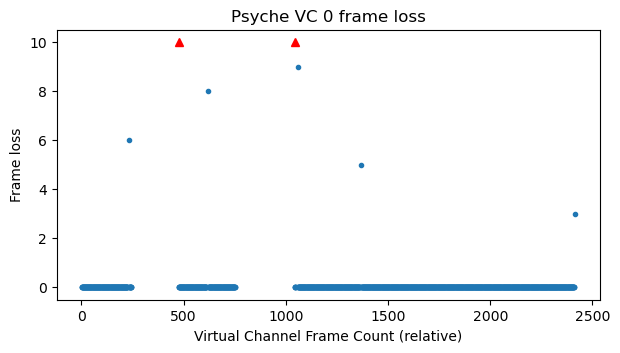

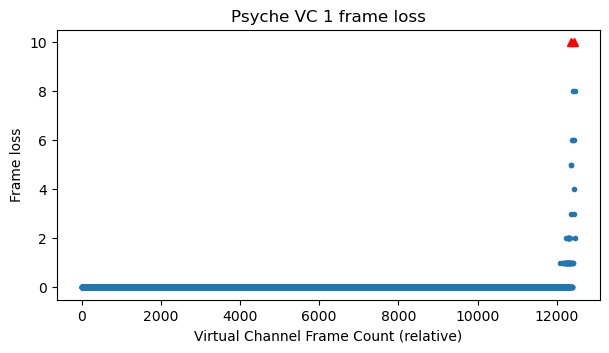

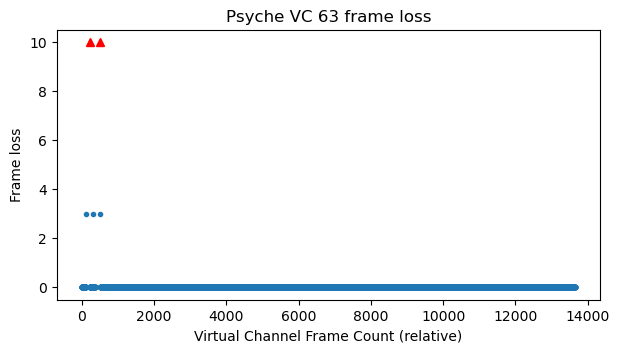

In [9]:
for v in set(vcid):
    relfn = vcfc[vcid == v][1:] - vcfc[vcid == v][0]
    loss = np.diff(vcfc[vcid == v]) - 1
    M = 10
    plt.figure()
    plt.plot(relfn[loss <= M], loss[loss <= M], '.')
    plt.plot(relfn[loss > M], [M] * np.sum(loss > M), '^', color='red')
    plt.title(f'Psyche VC {v} frame loss')
    plt.xlabel('Virtual Channel Frame Count (relative)')
    plt.ylabel('Frame loss');

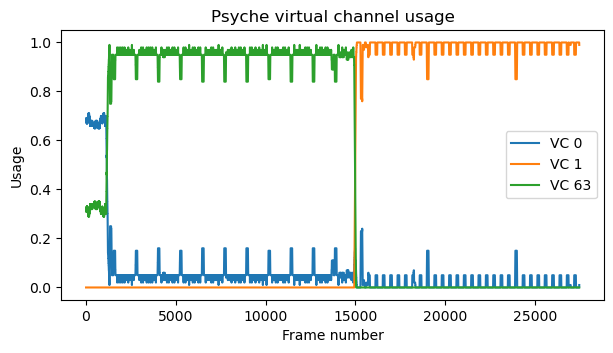

In [10]:
navg = 100
for v in set(vcid):
    plt.plot(np.convolve(vcid == v, np.ones(navg)/navg, mode='valid'), label=f'VC {v}')
plt.legend()
plt.title('Psyche virtual channel usage')
plt.xlabel('Frame number')
plt.ylabel('Usage');

# VC 0

Virtual channel 0 contains Space Packets using M_PDU. Non-idle packets have a secondary header containing a 48-bit timestamp in `2**-16` second units elapsed since the J2000 epoch. Idle packets do not have a secondary header and their payload contains an easter egg ASCII text. Most of the data is in APID 10, which contains real-time telemetry data in key-value format.

In [11]:
packets = list(ccsds.extract_space_packets(tm, 255, 0))

/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 0] Broken stream. Last frame count 89555, current frame count 89562
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 0] Broken stream. Last frame count 89573, current frame count 89805
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 0] Broken stream. Last frame count 89941, current frame count 89950
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame

In [12]:
headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]
apids = collections.Counter([p.APID for p in headers])
apids

Counter({10: 628, 2047: 549, 6: 130, 7: 72, 5: 42, 4: 2, 8: 2})

In [13]:
headers[:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12811, data_length=188),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=10, sequence_flags=3, packet_sequence_count_or_name=6097, data_length=3113),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12814, data_length=188),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=10, sequence_flags=3, packet_sequence_count_or_name=6098, data_length=3113),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12816, data_length=188),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=10, sequence_flags=3, packet_sequence_count_or_name=6099, data_length=3113),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, A

In [14]:
by_apid = {apid: [p for p, h in zip(packets, headers) if h.APID == apid]
           for apid in apids}

In [15]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid[2047][:5]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12811, data_length=188),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12814, data_length=188),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12816, data_length=188),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12819, data_length=188),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12821, data_length=188)]

In [16]:
collections.Counter([len(p) for p in by_apid[2047]])

Counter({195: 251,
         324: 15,
         329: 15,
         1054: 13,
         1056: 13,
         325: 12,
         327: 10,
         871: 7,
         95: 6,
         1007: 5,
         990: 4,
         1055: 4,
         970: 4,
         145: 3,
         80: 3,
         326: 3,
         617: 3,
         971: 3,
         980: 3,
         1064: 3,
         629: 3,
         984: 3,
         958: 3,
         930: 2,
         972: 2,
         601: 2,
         1022: 2,
         934: 2,
         964: 2,
         926: 2,
         973: 2,
         995: 2,
         599: 2,
         982: 2,
         950: 2,
         938: 2,
         931: 2,
         959: 2,
         653: 2,
         910: 2,
         647: 2,
         966: 2,
         945: 2,
         635: 2,
         944: 2,
         894: 2,
         873: 2,
         842: 2,
         818: 2,
         159: 1,
         715: 1,
         1006: 1,
         146: 1,
         364: 1,
         856: 1,
         260: 1,
         948: 1,
         122: 1,
 

In [17]:
by_apid[2047][0]

b'\x07\xff\xf2\x0b\x00\xbcA.Arslanian D.Beach M.Belete A.Bhosle Y.Brenman  \nD.Byrne R.Cheng P.Cheung M.Cisler D.Cummings     \nA.Dobrev P.Doronila B.Duckett D.Gaines L.Galdamez\nL.Hall S.Harris H.Hartounian D.Hecox Q.'

In [18]:
[p for p in by_apid[2047] if len(p) != 195][0]

b"\x07\xff\xf2\x1e\x03\xd7A.Arslanian D.Beach M.Belete A.Bhosle Y.Brenman  \nD.Byrne R.Cheng P.Cheung M.Cisler D.Cummings     \nA.Dobrev P.Doronila B.Duckett D.Gaines L.Galdamez\nL.Hall S.Harris H.Hartounian D.Hecox Q.Ho        \nJ.Hofman Z.Hua C.Jones W.Kaye D.Kou S.Kroese     \nD.Leang L.Manglapus J.Masci B.Morin R.Nemiroff   \nC.Oda J.Pavek V.Reddy J.Sawoniewicz              \nA.Shearer L.Stewart G.Sun J.Thoma D.Tran R.Tsao  \nM.Tuszynski I.Uchenik M.Wade V.Wong R.Woo M.Yang \nW.Yasin H.Yun ** Rohan the Destroyer b.12/9/21 **\n        @@&J!~...       ^$$~      ^JPG@@@        \n        @#7!: .       ..~$$~     ^Y ~PP@@        \n        &77:..      :$$J: '     .5:  !##@        \n        Y!~.:      !J^ ~P ''    J5    G#&        \n        77:    !. !Y:   ~7!!7JY^^!Y   $&#        \n        77:    !.:5!         :^. ~~   $##        \n        5!~    ~:!5J777$$!            G#&        \n        @$7^    .^!JJJ$:5P.       ^^ $##@        \n        @&J$^      :.   YG.     .:J7J##@@        \n     

In [19]:
apids

Counter({10: 628, 2047: 549, 6: 130, 7: 72, 5: 42, 4: 2, 8: 2})

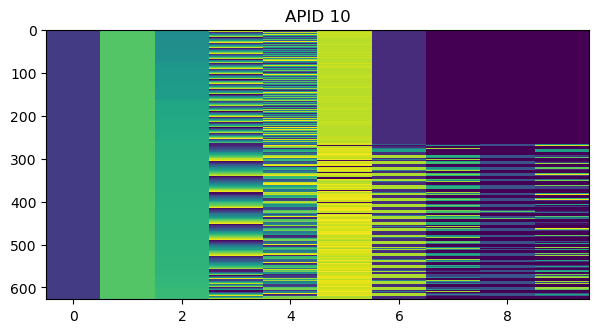

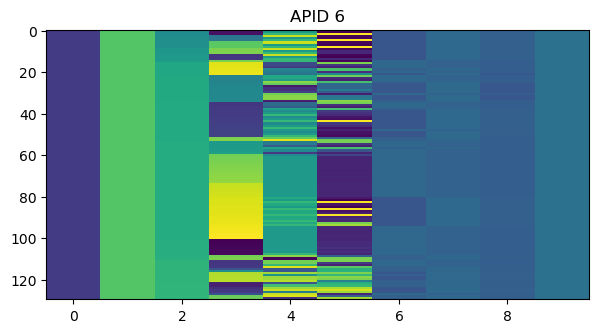

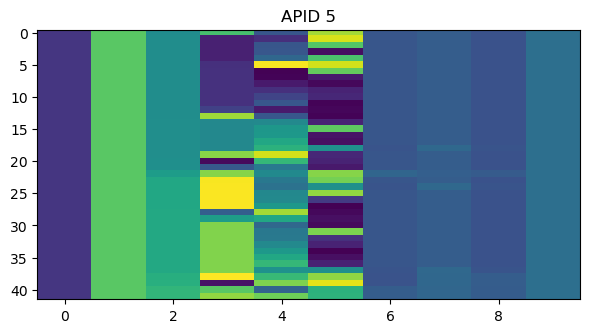

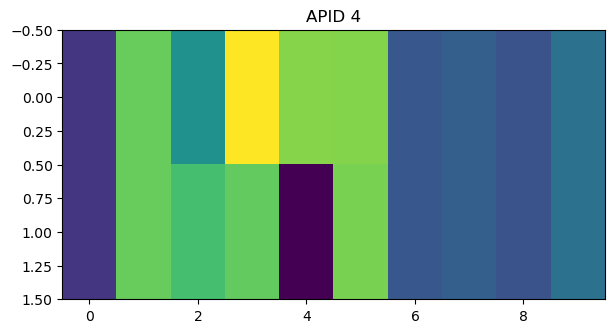

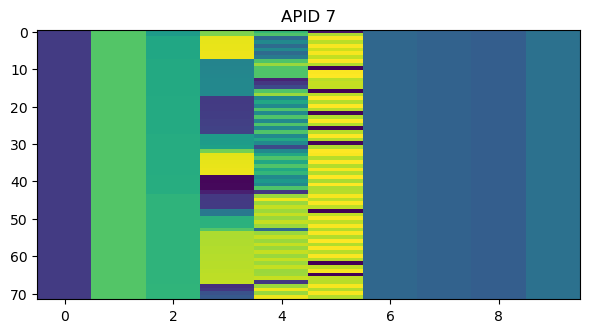

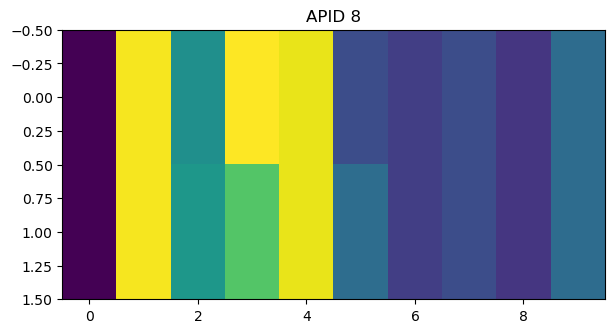

In [20]:
for apid in apids:
    if apid == 2047:
        continue
    A = np.array([np.frombuffer(p[6:6+6+4], 'uint8') for p, h in zip(packets, headers)
                  if h.APID == apid])

    plt.figure()
    plt.imshow(A, aspect='auto', interpolation='none')
    plt.title(f'APID {apid}')

In [21]:
sec_headers = np.array([np.frombuffer(p[6:6+6], 'uint8') for p, h in zip(packets, headers)
                        if h.secondary_header_flag])
timestamps = (sec_headers[:, :4].view('uint32').byteswap().ravel()
              + sec_headers[:, -2:].view('uint16').byteswap().ravel() / 2**16)
# https://naif.jpl.nasa.gov/pub/naif/PSYCHE/kernels/sclk/PSYC_255_SCLKSCET.00003.tsc
# *____SCLK0_____    ________SCET0________ _DUT__ __SCLKRATE__
# 536500870.000    2017-001T00:00:00.816 69.184  1.000000000

In [22]:
np.datetime64('2023-10-13T15:51:27.138273') - np.timedelta64(1, 'ns') * (1e9 * timestamps[0])

numpy.datetime64('2000-01-01T11:58:52.220655208')

In [23]:
np.datetime64('2000-01-01T12:00:00') + np.timedelta64(1, 's') * 536500870

numpy.datetime64('2017-01-01T00:01:10')

In [24]:
def timestamp_to_utc(t):
    return np.datetime64('2017-01-01T00:00:00.816') + np.timedelta64(1, 'ns') * (1e9 * (t - 536500870))

packet_timestamps = timestamp_to_utc(timestamps)
packet_timestamps[0]

numpy.datetime64('2023-10-13T15:51:25.733617792')

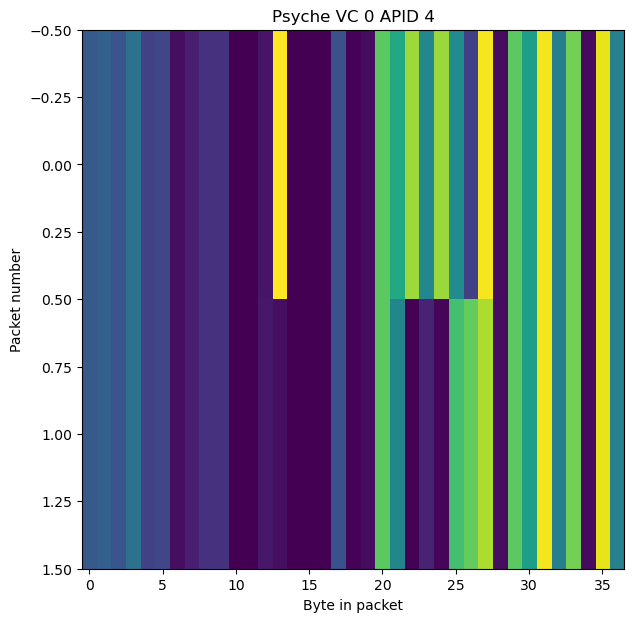

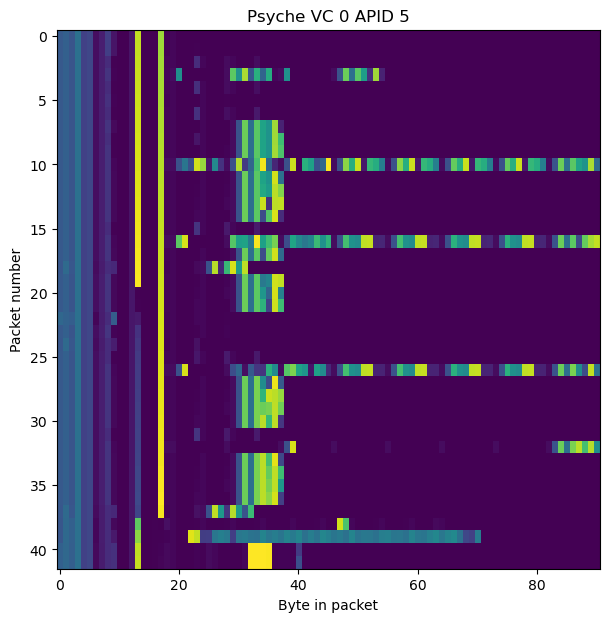

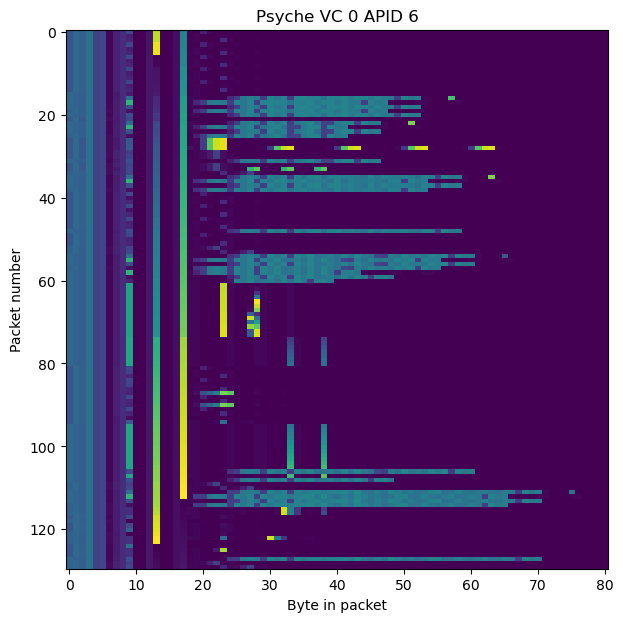

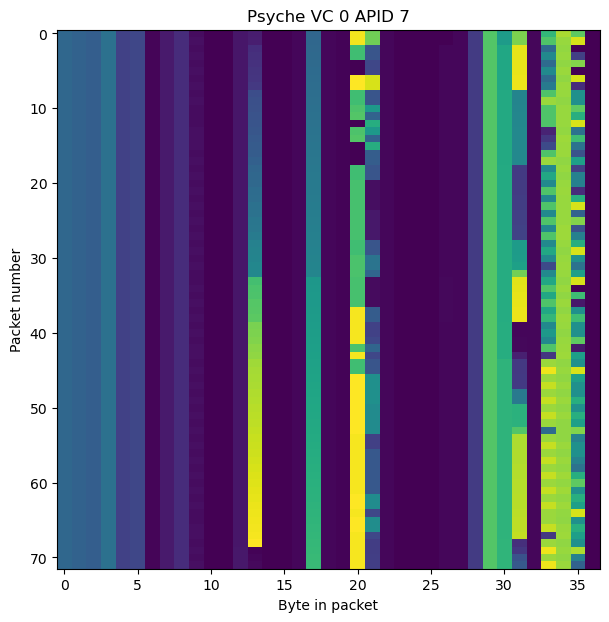

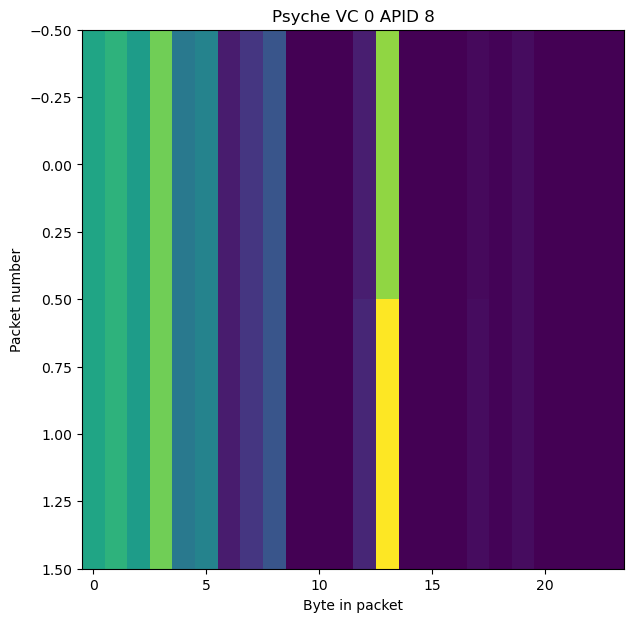

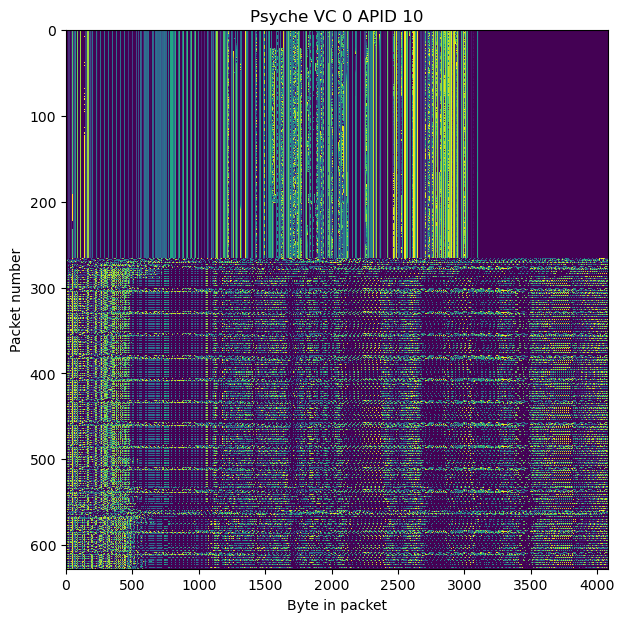

In [25]:
apid_array = {}
for apid in sorted(apids):
    if apid == 2047:
        continue
    ps = [np.frombuffer(p[6+6:], 'uint8') for p in by_apid[apid]]
    ml = max([len(p) for p in ps])
    plt.figure(figsize=(7, 7))
    apid_array[apid] = np.array([np.concatenate((p, np.zeros(ml - len(p), 'uint8'))) for p in ps])
    plt.imshow(apid_array[apid], aspect='auto', interpolation='none')
    plt.title(f'Psyche VC 0 APID {apid}')
    plt.xlabel('Byte in packet')
    plt.ylabel('Packet number')

In [26]:
headers_noidle = [h for h in headers if h.APID != 2047]
packets_noidle = [p for h, p in zip(headers, packets) if h.APID != 2047]

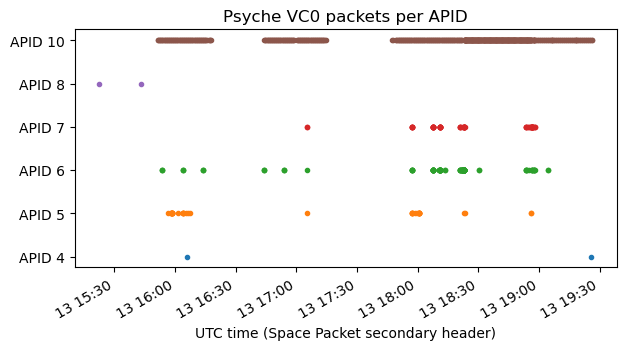

In [27]:
for j, apid in enumerate(sorted([a for a in apids if a != 2047])):
    tstamps = np.array([t for t, h in zip(packet_timestamps, headers_noidle) if h.APID == apid])
    plt.plot(tstamps, [j] * tstamps.size, '.')
yticks = [f'APID {a}' for a in sorted(apids) if a != 2047]
plt.yticks(np.arange(len(yticks)), yticks)
plt.gcf().autofmt_xdate()
plt.title('Psyche VC0 packets per APID')
plt.xlabel('UTC time (Space Packet secondary header)');

In [28]:
Tavg_s = 60
Tavg = Tavg_s * np.timedelta64(1, 's')
boundaries = packet_timestamps[0] + Tavg * np.arange(int(np.ceil((packet_timestamps[-1] - packet_timestamps[0])/Tavg)))

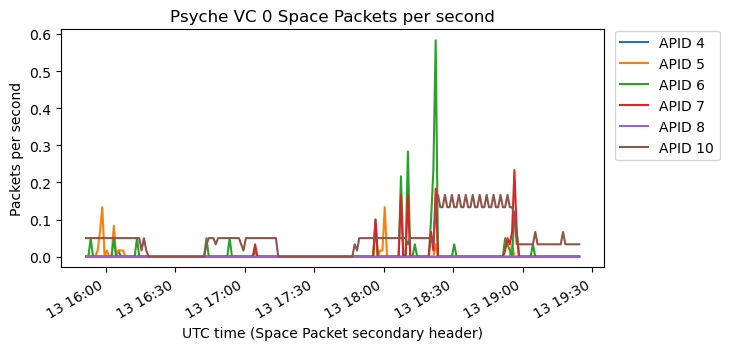

In [29]:
for apid in sorted(apids):
    if apid == 2047:
        continue
    packets_per_second = [sum([1 / Tavg_s for t, h in zip(packet_timestamps, headers_noidle)
                               if h.APID == apid and boundaries[j] <= t < boundaries[j+1]])
                          for j in range(len(boundaries)-1)]
    plt.plot(boundaries[:-1], packets_per_second, '-', label=f'APID {apid}')
plt.legend(loc=(1.02, 0.45))
plt.gcf().autofmt_xdate()
plt.title('Psyche VC 0 Space Packets per second')
plt.ylabel('Packets per second')
plt.xlabel('UTC time (Space Packet secondary header)');

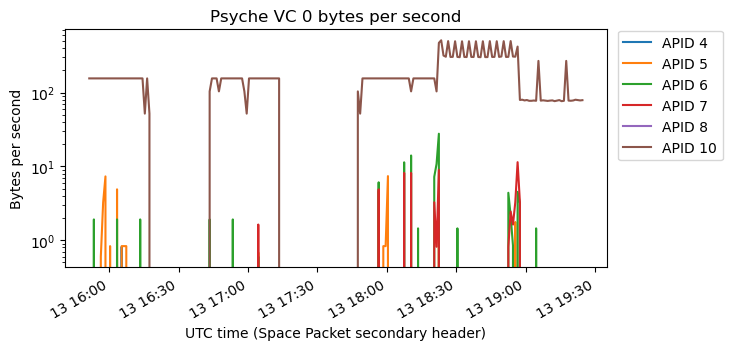

In [30]:
for apid in sorted(apids):
    if apid == 2047:
        continue
    packets_per_second = [sum([len(p) / Tavg_s for p, t, h in zip(packets_noidle, packet_timestamps, headers_noidle)
                               if h.APID == apid and boundaries[j] <= t < boundaries[j+1]])
                          for j in range(len(boundaries)-1)]
    plt.semilogy(boundaries[:-1], packets_per_second, '-', label=f'APID {apid}')
plt.legend(loc=(1.02, 0.45))
plt.gcf().autofmt_xdate()
plt.title('Psyche VC 0 bytes per second')
plt.ylabel('Bytes per second')
plt.xlabel('UTC time (Space Packet secondary header)');

In [31]:
[p[6+6:] for p in by_apid[4]]

[b'GNC_16\t\x15$%\x00\x00\x0e\xff\x00\x00\x00?\x02\x08\xbf\x9a\xdav\xd9{0\xfc\x08\xbf\x8e\xfbm\xca\x07\xf6o',
 b'GNC_16\t\x15$%\x00\x00\x10\t\x00\x00\x00@\x02\x08\xbfu\x01\x19\x04\xb3\xc3\xe0\x08\xbf\x8e\xfbm\xca\x07\xf6o']

In [32]:
[p[6+6:] for p in by_apid[5]]

[b'GNC_16\t\x15/\x0e\x00\x00\x0e\xe8\x00\x00\x00\xda\x01\x04\x00\x00\x00\x00',
 b'GNC_16\t\x15/\x0e\x00\x00\x0e\xe9\x00\x00\x00\xdb\x01\x04\x00\x00\x00\x01',
 b'GNC_16\t\x15 \x01\x00\x00\x0e\xea\x00\x00\x00\xdc\x03\x04\x00\x00\x00 \x04\x00\x00\x00\x07\x04\x00\x00\x00\x08',
 b'GNC_16\t\x15&\x02\x00\x00\x0e\xeb\x00\x00\x00\xdd\x04\x08\x80\x00\x00\x00\x00\x00\x00\x00\x08\xbf\x81\xdfF\xa2R\x9e\x04\x08\x80\x00\x00\x00\x00\x00\x00\x00\x08A\xc6]\xbe\x8e#\xdb\x18',
 b'GNC_16\t\x15 \x01\x00\x00\x0e\xec\x00\x00\x00\xde\x03\x04\x00\x00\x00"\x04\x00\x00\x00\x08\x04\x00\x00\x00\t',
 b'GNC_16\t\x15$\x02\x00\x00\x0e\xed\x00\x00\x00\xdf\x02\x04\x00\x00\x00\x00\x04\x00\x00\x00\x01',
 b'GNC_16\t\x15 \x01\x00\x00\x0e\xee\x00\x00\x00\xe0\x03\x04\x00\x00\x00$\x04\x00\x00\x00\t\x04\x00\x00\x00\x11',
 b'GNC_16\t\x15&\x06\x00\x00\x0e\xef\x00\x00\x00\xe1\x03\x04\x00\x00\x00\x00\x04\x00\x00\x00\x00\x08A\xc6]\xbe\x94\x83\xdb\x18',
 b'GNC_16\t\x15"\x01\x00\x00\x0e\xf0\x00\x00\x00\xe2\x03\x04\x00\x00\x00\x0e\x04\x

In [33]:
timestamp_to_utc(np.frombuffer(by_apid[5][-3][6:10], 'uint8').view('uint32').byteswap())

array(['2023-10-13T18:23:09.816000000'], dtype='datetime64[ns]')

In [34]:
[p[6+6:] for p in by_apid[6]]

[b'DWN_16\x04\x17 7\x00\x00\x0e\xe5\x00\x00\tr\x02\x01\x17\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x15\x00\x00\x0e\xe6\x00\x00\ts\x01\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x1b\x00\x00\x0e\xe7\x00\x00\tt\x02\x04\x00\x00\x00\x1f\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 7\x00\x00\x0e\xf6\x00\x00\tu\x02\x01\x17\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x15\x00\x00\x0e\xf7\x00\x00\tv\x01\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x1b\x00\x00\x0e\xf8\x00\x00\tw\x02\x04\x00\x00\x00\x1f\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 7\x00\x00\x0f\x02\x00\x00\tx\x02\x01\x17\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x15\x00\x00\x0f\x03\x00\x00\ty\x01\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x1b\x00\x00\x0f\x04\x00\x00\tz\x02\x04\x00\x00\x00\x1f\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 7\x00\x00\x0f\x0c\x00\x00\t\x82\x02\x01\x17\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x15\x00\x00\x0f\r\x00\x00\t\x83\x01\x04\x00\x00\x00\x02',
 b'DWN_16\x04\x17 \x1b\x00\x00\x0f\x0e\x00\x00\t\x84\x02\x04\x00\x00\x00\x1f\x04

In [35]:
[p[6+6:] for p in by_apid[7]]

[b'UPL_16\x03\x12 \x08\x00\x00\x0f\x14\x00\x00\x04T\x04\x02\xfb\xc8\x04\x00\x00\x00\x00\x04,\xbb\x8c\xcd\x04\xa9\xdf\xc0\x00',
 b'UPL_16\x03\x12 \n\x00\x00\x0f\x15\x00\x00\x04U\x04\x02\xfb\xc8\x04\x00\x00\x00\x00\x04,\xbb\x8c\xcd\x04\xb9\xd8\xf0\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\x0f!\x00\x00\x04V\x04\x02\xb1C\x04\x00\x00\x00\x04\x04,\xbb\x98\xf6\x04Y\xd6\x00\x00',
 b'UPL_16\x03\x12 \n\x00\x00\x0f#\x00\x00\x04W\x04\x02\xb1C\x04\x00\x00\x00\x04\x04,\xbb\x98\xf6\x04y\xd80\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\x0f$\x00\x00\x04X\x04\x02\x006\x04\x00\x00\x00\x04\x04,\xbb\x98\xf7\x04Y\xd5\xd0\x00',
 b'UPL_16\x03\x12 \n\x00\x00\x0f&\x00\x00\x04Y\x04\x02\x006\x04\x00\x00\x00\x04\x04,\xbb\x98\xf7\x04y\xd9\x00\x00',
 b"UPL_16\x03\x12 \x08\x00\x00\x0f'\x00\x00\x04Z\x04\x02\xff\xf0\x04\x00\x00\x00\x04\x04,\xbb\x98\xf8\x04Y\xd5\xf0\x00",
 b'UPL_16\x03\x12 \n\x00\x00\x0f*\x00\x00\x04[\x04\x02\xff\xf0\x04\x00\x00\x00\x04\x04,\xbb\x98\xf8\x04i\xd9 \x00',
 b'UPL_16\x03\x12 \x08\x00\x00\x0f<\x00\x00\x0

In [36]:
collections.Counter([len(p[6+6:]) for p in by_apid[7]])

Counter({37: 72})

In [37]:
apid7_timestamps = packet_timestamps[np.array([h.APID == 7 for h in headers if h.APID != 2047])]

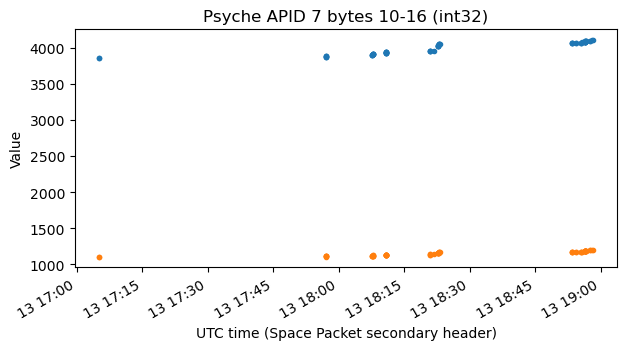

In [38]:
plt.plot(apid7_timestamps, apid_array[7][:, 10:][:, :2*4].view('int32').byteswap(), '.')
plt.gcf().autofmt_xdate()
plt.title('Psyche APID 7 bytes 10-16 (int32)')
plt.xlabel('UTC time (Space Packet secondary header)')
plt.ylabel('Value');

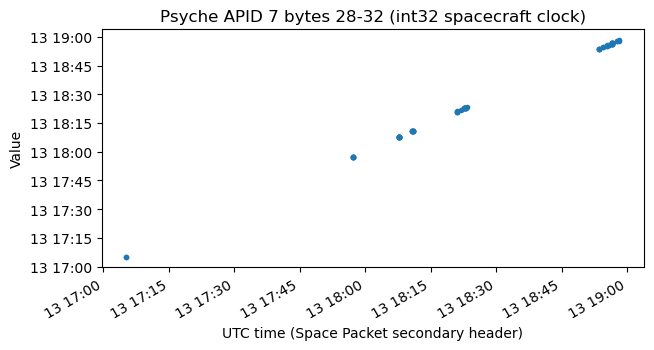

In [39]:
plt.plot(apid7_timestamps, timestamp_to_utc(apid_array[7][:, 28:][:, :4].view('int32').byteswap()), '.')
plt.gcf().autofmt_xdate()
plt.title('Psyche APID 7 bytes 28-32 (int32 spacecraft clock)')
plt.xlabel('UTC time (Space Packet secondary header)')
plt.ylabel('Value');

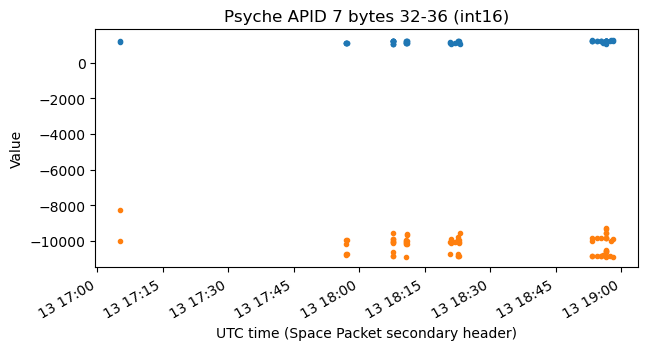

In [40]:
plt.plot(apid7_timestamps, apid_array[7][:, 32:][:, :4].view('int16').byteswap(), '.')
plt.gcf().autofmt_xdate()
plt.title('Psyche APID 7 bytes 32-36 (int16)')
plt.xlabel('UTC time (Space Packet secondary header)')
plt.ylabel('Value');

In [41]:
[p[6+6:] for p in by_apid[8]]

[b'GNC_16\t\x13 \x00\x00\x00\ne\x00\x00\x00\x03\x01\x04\x00\x00\x00\x00',
 b'GNC_16\t\x13 \x00\x00\x00\ry\x00\x00\x00\x04\x01\x04\x00\x00\x00\x00']

In [42]:
t_apid10 = np.array([t for t, h in zip(packet_timestamps, headers_noidle)
                     if h.APID == 10])

In [43]:
keys = {}
for j in range(3):
    keys[0*256+j] = 4
for j in range(2):
    keys[8*256+j] = 4
for j in [59]:
    keys[8*256+j] = 4
for j in range(62, 64):
    keys[8*256+j] = 4
for j in [64]:
    keys[8*256+j] = 1
for j in range(71, 74):
    keys[8*256+j] = 4
for j in [76]:
    keys[8*256+j] = 4
for j in range(81, 89):
    keys[8*256+j] = 4
for j in range(93, 101):
    keys[8*256+j] = 4
for j in range(127, 158):
    keys[8*256+j] = 4
for j in range(160, 164):
    keys[8*256+j] = 4
for j in range(165, 171):
    keys[8*256+j] = 4
for j in [171, 172]:
    keys[8*256+j] = 1
for j in [173]:
    keys[8*256+j] = 4
for j in [174]:
    keys[8*256+j] = 1
for j in range(185, 206):
    keys[8*256+j] = 4
for j in range(209, 226):
    keys[8*256+j] = 4
for j in range(8):
    keys[16*256+j] = 4
for j in [8]:
    keys[16*256+j] = 1
for j in range(9, 19):
    keys[16*256+j] = 4
for j in [19]:
    keys[16*256+j] = 1
for j in range(20, 35):
    keys[16*256+j] = 4
for j in range(1, 3):
    keys[24*256+j] = 1
for j in range(3, 6):
    keys[24*256+j] = 4
for j in range(7, 10):
    keys[24*256+j] = 4
for j in range(7):
    keys[32*256+j] = 4
for j in range(8, 10):
    keys[32*256+j] = 2
for j in range(10, 12):
    keys[32*256+j] = 4
for j in [12]:
    keys[32*256+j] = 2
for j in range(13, 17):
    keys[32*256+j] = 4
for j in range(17, 19):
    keys[32*256+j] = 2
for j in range(19, 23):
    keys[32*256+j] = 4
for j in [23]:
    keys[32*256+j] = 2
for j in range(24, 26):
    keys[32*256+j] = 4
for j in range(26, 27):
    keys[32*256+j] = 4
for j in [27]:
    keys[32*256+j] = 2
for j in range(28, 32):
    keys[32*256+j] = 4
for j in [0]:
    keys[40*256+j] = 4
for j in range(1, 10):
    keys[40*256+j] = 1
for j in [10]:
    keys[40*256+j] = 2
for j in [11]:
    keys[40*256+j] = 1
for j in [12, 13]:
    keys[40*256+j] = 4
for j in [14]:
    keys[40*256+j] = 2
for j in range(15, 24):
    keys[40*256+j] = 4
for j in range(24, 26):
    keys[40*256+j] = 2
for j in range(26, 29):
    keys[40*256+j] = 1
for j in range(29, 38):
    keys[40*256+j] = 4
for j in range(38, 40):
    keys[40*256+j] = 1
for j in range(4):
    keys[56*256+j] = 4
for j in range(4, 7):
    keys[56*256+j] = 2
for j in range(7, 9):
    keys[56*256+j] = 4
for j in [9]:
    keys[56*256+j] = 2
for j in [10]:
    keys[56*256+j] = 4
for j in [11]:
    keys[56*256+j] = 2
for j in [12]:
    keys[56*256+j] = 4
for j in [13]:
    keys[56*256+j] = 2
for j in [14]:
    keys[56*256+j] = 4
for j in [15]:
    keys[56*256+j] = 2
for j in range(16, 19):
    keys[56*256+j] = 4
for j in [19]:
    keys[56*256+j] = 1
for j in range(230, 234):
    keys[64*256+j] = 1
for j in range(59, 85):
    keys[65*256+j] = 4
for j in [85]:
    keys[65*256+j] = 1
for j in range(86, 89):
    keys[65*256+j] = 4
for j in range(96, 99):
    keys[65*256+j] = 4
for j in range(14):
    keys[72*256+j] = 4
for j in range(16, 19):
    keys[72*256+j] = 4
for j in range(21, 56):
    keys[72*256+j] = 4
for j in range(70, 73):
    keys[72*256+j] = 4
for j in range(73, 74):
    keys[72*256+j] = 1
for j in range(4):
    keys[80*256+j] = 4
for j in [5]:
    keys[80*256+j] = 4
for j in range(6, 8):
    keys[80*256+j] = 2
for j in range(8, 14):
    keys[80*256+j] = 4
for j in [15]:
    keys[80*256+j] = 4
for j in range(16, 18):
    keys[80*256+j] = 2
for j in range(18, 26):
    keys[80*256+j] = 4
for j in range(26, 30):
    keys[80*256+j] = 2
for j in range(30, 38):
    keys[80*256+j] = 4
for j in range(38, 40):
    keys[80*256+j] = 1
for j in range(40, 52):
    keys[80*256+j] = 4
for j in [2, 4]:
    keys[88*256+j] = 2
for j in [3, 11, 12]:
    keys[88*256+j] = 1
for j in range(8, 11):
    keys[88*256+j] = 4
for j in range(13, 19):
    keys[88*256+j] = 4
for j in range(64):
    keys[96*256+j] = 4
for j in [64]:
    keys[96*256+j] = 1
for j in [65]:
    keys[96*256+j] = 2
for j in range(66, 119):
    keys[96*256+j] = 4
for j in range(124, 129):
    keys[96*256+j] = 4
for j in range(141, 147):
    keys[96*256+j] = 4
for j in range(147, 157):
    keys[96*256+j] = 2
for j in range(157, 193):
    keys[96*256+j] = 4
for j in range(195, 201):
    keys[96*256+j] = 4
for j in [205]:
    keys[96*256+j] = 4
for j in range(210, 234):
    keys[96*256+j] = 4
for j in range(44, 121):
    keys[97*256+j] = 2
for j in range(122, 128):
    keys[97*256+j] = 2
for j in range(129, 134):
    keys[97*256+j] = 2
for j in range(135, 143):
    keys[97*256+j] = 2
for j in range(144, 151):
    keys[97*256+j] = 2
for j in range(152, 155):
    keys[97*256+j] = 2
for j in range(156, 256):
    keys[97*256+j] = 2
for j in range(10):
    keys[98*256+j] = 2
for j in [11]:
    keys[98*256+j] = 2
for j in range(14, 50):
    keys[98*256+j] = 2
for j in range(52, 96):
    keys[98*256+j] = 2
for j in range(96, 98):
    keys[98*256+j] = 4
for j in [98]:
    keys[98*256+j] = 2
for j in range(100, 148):
    keys[98*256+j] = 2
for j in [148]:
    keys[98*256+j] = 4
for j in range(149, 151):
    keys[98*256+j] = 2
for j in [151]:
    keys[98*256+j] = 4
for j in range(152, 194):
    keys[98*256+j] = 2
for j in range(194, 196):
    keys[98*256+j] = 4
for j in range(196, 198):
    keys[98*256+j] = 2
for j in range(198, 200):
    keys[98*256+j] = 4
for j in range(200, 209):
    keys[98*256+j] = 2
for j in range(210, 241):
    keys[98*256+j] = 2
for j in range(242, 256):
    keys[98*256+j] = 2
for j in range(5):
    keys[99*256+j] = 2
for j in range(5, 9):
    keys[99*256+j] = 4
for j in range(9, 28):
    keys[99*256+j] = 2
for j in range(232, 256):
    keys[99*256+j] = 4
for j in [0]:
    keys[100*256+j] = 2
for j in range(1, 4):
    keys[100*256+j] = 4
for j in range(4, 14):
    keys[100*256+j] = 2
for j in range(18, 22):
    keys[100*256+j] = 4
for j in range(22, 28):
    keys[100*256+j] = 2
for j in [28]:
    keys[100*256+j] = 4
for j in range(29, 35):
    keys[100*256+j] = 2
for j in range(35, 47):
    keys[100*256+j] = 4
for j in range(47, 56):
    keys[100*256+j] = 2
for j in range(56, 61):
    keys[100*256+j] = 4
for j in range(61, 63):
    keys[100*256+j] = 2
for j in [63]:
    keys[100*256+j] = 4
for j in range(64, 66):
    keys[100*256+j] = 2
for j in range(66, 69):
    keys[100*256+j] = 4
for j in range(0, 8):
    keys[104*256+j] = 4
for j in [16]:
    keys[104*256+j] = 1
for j in [17]:
    keys[104*256+j] = 8
for j in range(20, 22):
    keys[104*256+j] = 4
for j in [22]:
    keys[104*256+j] = 1
for j in range(40, 101):
    keys[104*256+j] = 4
for j in [101]:
    keys[104*256+j] = 1
for j in range(102, 120):
    keys[104*256+j] = 4
for j in range(120, 123):
    keys[104*256+j] = 2
for j in range(123, 125):
    keys[104*256+j] = 4
for j in [125]:
    keys[104*256+j] = 4
for j in [126]:
    keys[104*256+j] = 1
for j in range(127, 145):
    keys[104*256+j] = 4
for j in range(148, 158):
    keys[104*256+j] = 4
for j in range(161, 194):
    keys[104*256+j] = 4
for j in [197]:
    keys[104*256+j] = 4
for j in range(198, 200):
    keys[104*256+j] = 1
for j in [225]:
    keys[104*256+j] = 1
for j in [226]:
    keys[104*256+j] = 2
for j in [254]:
    keys[104*256+j] = 1
for j in [255]:
    keys[104*256+j] = 2
for j in range(2, 4):
    keys[105*256+j] = 1
for j in range(4, 15):
    keys[105*256+j] = 8
for j in [15]:
    keys[105*256+j] = 2
for j in range(16, 22):
    keys[105*256+j] = 8
for j in [22]:
    keys[105*256+j] = 2
for j in [23]:
    keys[105*256+j] = 8
for j in [24]:
    keys[105*256+j] = 2
for j in [25]:
    keys[105*256+j] = 4
for j in range(68, 72):
    keys[105*256+j] = 1
for j in range(72, 76):
    keys[105*256+j] = 4
for j in range(144, 156):
    keys[105*256+j] = 4
for j in range(156, 160):
    keys[105*256+j] = 2
for j in range(160, 172):
    keys[105*256+j] = 1
for j in range(176, 180):
    keys[105*256+j] = 2
for j in range(180, 184):
    keys[105*256+j] = 4
for j in [184, 186]:
    keys[105*256+j] = 1
for j in [188, 190]:
    keys[105*256+j] = 2
for j in range(244, 251):
    keys[105*256+j] = 4
for j in range(251, 253):
    keys[105*256+j] = 2
for j in range(253, 255):
    keys[105*256+j] = 1
for j in [255]:
    keys[105*256+j] = 2
for j in range(3):
    keys[106*256+j] = 2
for j in range(3, 33):
    keys[106*256+j] = 4
for j in range(33, 35):
    keys[106*256+j] = 1
for j in [38]:
    keys[106*256+j] = 1
for j in range(41, 72):
    keys[106*256+j] = 8
for j in range(86, 88):
    keys[106*256+j] = 1
for j in range(88, 99):
    keys[106*256+j] = 4
for j in range(99, 102):
    keys[106*256+j] = 1
for j in range(102, 138):
    keys[106*256+j] = 4
for j in range(138, 140):
    keys[106*256+j] = 1
for j in range(140, 158):
    keys[106*256+j] = 4
for j in range(158, 162):
    keys[106*256+j] = 1
for j in [162]:
    keys[106*256+j] = 8
for j in range(163, 165):
    keys[106*256+j] = 1
for j in range(189, 206):
    keys[106*256+j] = 4
for j in range(206, 230):
    keys[106*256+j] = 4
for j in range(230, 238):
    keys[106*256+j] = 1
for j in range(7, 10):
    keys[107*256+j] = 4
for j in range(10, 16):
    keys[107*256+j] = 1
for j in range(16, 24):
    keys[107*256+j] = 4
for j in range(24, 32):
    keys[107*256+j] = 1
for j in [32]:
    keys[107*256+j] = 2
for j in [33]:
    keys[107*256+j] = 4
for j in [34]:
    keys[107*256+j] = 1
for j in range(35, 53):
    keys[107*256+j] = 4
for j in [53]:
    keys[107*256+j] = 1
for j in range(54, 66):
    keys[107*256+j] = 4
for j in range(66, 82):
    keys[107*256+j] = 8
for j in range(82, 84):
    keys[107*256+j] = 1
for j in [84]:
    keys[107*256+j] = 4
for j in range(85, 93):
    keys[107*256+j] = 8
for j in range(97, 101):
    keys[107*256+j] = 8
for j in range(104, 107):
    keys[107*256+j] = 4
for j in range(116, 118):
    keys[107*256+j] = 4
for j in range(118, 121):
    keys[107*256+j] = 1
for j in range(121, 127):
    keys[107*256+j] = 4
for j in range(133, 136):
    keys[107*256+j] = 4
for j in range(136, 146):
    keys[107*256+j] = 1
for j in range(146, 169):
    keys[107*256+j] = 4
for j in range(172, 174):
    keys[107*256+j] = 4
for j in range(177, 180):
    keys[107*256+j] = 1
for j in range(180, 184):
    keys[107*256+j] = 4
for j in range(184, 188):
    keys[107*256+j] = 8
for j in range(188, 192):
    keys[107*256+j] = 4
for j in range(192, 208):
    keys[107*256+j] = 1
for j in range(208, 233):
    keys[107*256+j] = 4
for j in [233, 235]:
    keys[107*256+j] = 1
for j in [234, 236]:
    keys[107*256+j] = 2
for j in range(237, 243):
    keys[107*256+j] = 1
for j in range(243, 248):
    keys[107*256+j] = 4
for j in range(248, 250):
    keys[107*256+j] = 1
for j in range(250, 255):
    keys[107*256+j] = 4
for j in [255]:
    keys[107*256+j] = 1
for j in [0]:
    keys[108*256+j] = 1
for j in range(1, 21):
    keys[108*256+j] = 4
for j in [21]:
    keys[108*256+j] = 1
for j in range(22, 30):
    keys[108*256+j] = 4
for j in [30]:
    keys[108*256+j] = 1
for j in range(33, 60):
    keys[108*256+j] = 4
for j in range(60, 69):
    keys[108*256+j] = 1
for j in range(77, 96):
    keys[108*256+j] = 4
for j in range(108, 112):
    keys[108*256+j] = 4
for j in range(127, 133):
    keys[108*256+j] = 1
for j in range(133, 160):
    keys[108*256+j] = 4
for j in range(160, 164):
    keys[108*256+j] = 1
for j in range(182, 195):
    keys[108*256+j] = 1
for j in range(195, 200):
    keys[108*256+j] = 4
for j in [200]:
    keys[108*256+j] = 1
for j in range(201, 206):
    keys[108*256+j] = 4
for j in [206]:
    keys[108*256+j] = 1
for j in range(207, 233):
    keys[108*256+j] = 4
for j in range(237, 239):
    keys[108*256+j] = 1
for j in range(207, 233):
    keys[108*256+j] = 4
for j in range(247, 256):
    keys[108*256+j] = 4
for j in range(8):
    keys[109*256+j] = 1
for j in range(8, 12):
    keys[109*256+j] = 4
for j in range(12, 18):
    keys[109*256+j] = 1
for j in range(18, 21):
    keys[109*256+j] = 4
for j in [21]:
    keys[109*256+j] = 1
for j in range(22, 35):
    keys[109*256+j] = 4
for j in [35]:
    keys[109*256+j] = 1
for j in range(36, 38):
    keys[109*256+j] = 4
for j in range(38, 40):
    keys[109*256+j] = 1
for j in range(80, 83):
    keys[109*256+j] = 4
for j in [83]:
    keys[109*256+j] = 1
for j in range(77, 80):
    keys[109*256+j] = 4
for j in range(84, 87):
    keys[109*256+j] = 4
for j in range(87, 102):
    keys[109*256+j] = 4
for j in [102]:
    keys[109*256+j] = 1
for j in range(103, 109):
    keys[109*256+j] = 4
for j in [109]:
    keys[109*256+j] = 1
for j in range(110, 128):
    keys[109*256+j] = 4
for j in range(128, 132):
    keys[109*256+j] = 1
for j in range(132, 157):
    keys[109*256+j] = 4
for j in range(157, 160):
    keys[109*256+j] = 1
for j in [160]:
    keys[109*256+j] = 4
for j in range(161, 165):
    keys[109*256+j] = 8
for j in range(165, 169):
    keys[109*256+j] = 1
for j in range(169, 173):
    keys[109*256+j] = 4
for j in range(173, 175):
    keys[109*256+j] = 1
for j in range(175, 193):
    keys[109*256+j] = 4
for j in range(209, 213):
    keys[109*256+j] = 4
for j in range(214, 216):
    keys[109*256+j] = 4
for j in range(217, 219):
    keys[109*256+j] = 4
for j in range(225, 227):
    keys[109*256+j] = 8
for j in [228]:
    keys[109*256+j] = 1
for j in [229]:
    keys[109*256+j] = 8
for j in [230, 232]:
    keys[109*256+j] = 1
for j in [233]:
    keys[109*256+j] = 8
for j in [234]:
    keys[109*256+j] = 1
for j in range(235, 237):
    keys[109*256+j] = 8
for j in range(237, 256):
    keys[109*256+j] = 4
for j in range(4):
    keys[110*256+j] = 4
for j in range(4, 7):
    keys[110*256+j] = 1
for j in [7]:
    keys[110*256+j] = 4
for j in range(8, 12):
    keys[110*256+j] = 8
for j in range(12, 16):
    keys[110*256+j] = 1
for j in range(16, 41):
    keys[110*256+j] = 4
for j in range(41, 44):
    keys[110*256+j] = 1
for j in [44]:
    keys[110*256+j] = 4
for j in [45]:
    keys[110*256+j] = 1
for j in range(49, 53):
    keys[110*256+j] = 8
for j in [53]:
    keys[110*256+j] = 1
for j in range(54, 58):
    keys[110*256+j] = 8
for j in range(58, 61):
    keys[110*256+j] = 4
for j in [61]:
    keys[110*256+j] = 1
for j in range(62, 66):
    keys[110*256+j] = 2
for j in [66]:
    keys[110*256+j] = 8
for j in range(67, 75):
    keys[110*256+j] = 4
for j in [75]:
    keys[110*256+j] = 1
for j in range(76, 80):
    keys[110*256+j] = 4
for j in range(80, 88):
    keys[110*256+j] = 8
for j in range(88, 90):
    keys[110*256+j] = 1
for j in [90]:
    keys[110*256+j] = 4
for j in [91]:
    keys[110*256+j] = 1
for j in [92]:
    keys[110*256+j] = 4
for j in range(93, 98):
    keys[110*256+j] = 1
for j in range(98, 104):
    keys[110*256+j] = 8
for j in [104]:
    keys[110*256+j] = 1
for j in [105]:
    keys[110*256+j] = 8
for j in [106]:
    keys[110*256+j] = 4
for j in range(108, 112):
    keys[110*256+j] = 1
for j in range(124, 127):
    keys[110*256+j] = 8
for j in range(140, 165):
    keys[110*256+j] = 4
for j in range(171, 173):
    keys[110*256+j] = 1
for j in range(173, 190):
    keys[110*256+j] = 4
for j in range(190, 194):
    keys[110*256+j] = 8
for j in range(200, 239):
    keys[110*256+j] = 4
for j in range(239, 246):
    keys[110*256+j] = 1
for j in range(246, 256):
    keys[110*256+j] = 4
for j in range(9):
    keys[111*256+j] = 4
for j in range(38, 41):
    keys[111*256+j] = 4
for j in range(41, 45):
    keys[111*256+j] = 1
for j in range(81, 84):
    keys[111*256+j] = 1
for j in range(84, 108):
    keys[111*256+j] = 4
for j in range(109, 113):
    keys[111*256+j] = 2
for j in range(113, 133):
    keys[111*256+j] = 4
for j in range(137, 141):
    keys[111*256+j] = 4
for j in range(145, 165):
    keys[111*256+j] = 4
for j in range(179, 186):
    keys[111*256+j] = 4
for j in [198]:
    keys[111*256+j] = 4
for j in range(199, 201):
    keys[111*256+j] = 1
for j in range(210, 221):
    keys[111*256+j] = 1
for j in [221]:
    keys[111*256+j] = 4
for j in range(248, 252):
    keys[111*256+j] = 2
for j in [222, 252, 253]:
    keys[111*256+j] = 1
for j in range(224, 248):
    keys[111*256+j] = 4
for j in range(254, 256):
    keys[111*256+j] = 8
for j in range(82, 85):
    keys[112*256+j] = 4
for j in range(88, 94):
    keys[112*256+j] = 4
for j in range(96, 98):
    keys[112*256+j] = 1
for j in range(103, 106):
    keys[112*256+j] = 4
for j in [0]:
    keys[120*256+j] = 4
for j in range(1, 3):
    keys[120*256+j] = 1
for j in range(3, 5):
    keys[120*256+j] = 2
for j in range(5, 7):
    keys[120*256+j] = 4
for j in range(7, 9):
    keys[120*256+j] = 2
for j in [9]:
    keys[120*256+j] = 1
for j in range(10, 12):
    keys[120*256+j] = 4
for j in range(12, 14):
    keys[120*256+j] = 1
for j in range(14, 16):
    keys[120*256+j] = 2
for j in range(16, 18):
    keys[120*256+j] = 4
for j in range(18, 20):
    keys[120*256+j] = 2
for j in [20]:
    keys[120*256+j] = 1
for j in range(21, 58):
    keys[120*256+j] = 4
for j in [99, 130]:
    keys[136*256+j] = 1
for j in range(131, 155):
    keys[136*256+j] = 4
for j in range(2):
    keys[144*256+j] = 2
for j in range(5, 40):
    keys[144*256+j] = 1
for j in [42]:
    keys[144*256+j] = 1
for j in range(44, 47):
    keys[144*256+j] = 1
for j in range(48, 51):
    keys[144*256+j] = 1
for j in range(52, 54):
    keys[144*256+j] = 1
for j in range(54, 56):
    keys[144*256+j] = 1
for j in [58]:
    keys[144*256+j] = 1
for j in range(60, 63):
    keys[144*256+j] = 1
for j in [64]:
    keys[144*256+j] = 1
for j in range(67, 69):
    keys[144*256+j] = 1
for j in range(70, 102):
    keys[144*256+j] = 1
for j in range(104, 130):
    keys[144*256+j] = 1
for j in range(130, 132):
    keys[144*256+j] = 2
for j in range(132, 135):
    keys[144*256+j] = 4
for j in range(135, 138):
    keys[144*256+j] = 2
for j in range(138, 144):
    keys[144*256+j] = 2
for j in [144]:
    keys[144*256+j] = 1
for j in range(145, 147):
    keys[144*256+j] = 4
for j in range(147, 153):
    keys[144*256+j] = 2
for j in range(153, 161):
    keys[144*256+j] = 4
for j in range(161, 166):
    keys[144*256+j] = 2
for j in range(197, 205):
    keys[144*256+j] = 4
for j in range(213, 256):
    keys[144*256+j] = 1
for j in range(15):
    keys[145*256+j] = 1
for j in [15]:
    keys[145*256+j] = 1
for j in range(16, 20):
    keys[145*256+j] = 2
for j in [23]:
    keys[145*256+j] = 4
for j in range(26, 32):
    keys[145*256+j] = 4
for j in range(32, 35):
    keys[145*256+j] = 4
for j in range(35, 37):
    keys[145*256+j] = 2
for j in range(37, 51):
    keys[145*256+j] = 4
for j in [61, 63, 65, 67]:
    keys[145*256+j] = 4
for j in range(48, 51):
    keys[152*256+j] = 4
for j in range(54, 60):
    keys[152*256+j] = 4
for j in [61]:
    keys[152*256+j] = 4
for j in [62]:
    keys[152*256+j] = 1
for j in [63, 65, 67]:
    keys[152*256+j] = 4
for j in range(68, 71):
    keys[152*256+j] = 4
for j in range(3):
    keys[160*256+j] = 2
for j in range(5, 58):
    keys[160*256+j] = 4
for j in range(63, 67):
    keys[160*256+j] = 4
for j in range(68, 96):
    keys[160*256+j] = 4
for j in range(96, 98):
    keys[160*256+j] = 2
for j in range(98, 118):
    keys[160*256+j] = 4
for j in [117, 163]:
    keys[160*256+j] = 4
for j in range(132, 136):
    keys[160*256+j] = 4
for j in range(136, 140):
    keys[160*256+j] = 1
for j in range(140, 144):
    keys[160*256+j] = 2
for j in range(144, 146):
    keys[160*256+j] = 1
for j in range(146, 159):
    keys[160*256+j] = 4
for j in [161]:
    keys[160*256+j] = 4
for j in range(164, 166):
    keys[160*256+j] = 1
for j in range(207, 211):
    keys[160*256+j] = 4
for j in [0]:
    keys[168*256+j] = 1
for j in range(1, 7):
    keys[168*256+j] = 4
for j in range(213):
    keys[176*256+j] = 4
for j in range(213, 237):
    keys[176*256+j] = 2
for j in range(237, 239):
    keys[176*256+j] = 4
for j in range(241, 249):
    keys[176*256+j] = 4
for j in range(249, 256):
    keys[176*256+j] = 2
for j in range(14):
    keys[177*256+j] = 2
for j in [14]:
    keys[177*256+j] = 4
for j in range(24, 26):
    keys[177*256+j] = 2
for j in [26]:
    keys[177*256+j] = 4
for j in range(27, 31):
    keys[177*256+j] = 2
for j in [31]:
    keys[177*256+j] = 4
for j in range(32, 82):
    keys[177*256+j] = 2
for j in range(82, 84):
    keys[177*256+j] = 4
for j in [100]:
    keys[177*256+j] = 2
for j in range(112, 256):
    keys[177*256+j] = 4
for j in range(69):
    keys[178*256+j] = 4
for j in range(69, 81):
    keys[178*256+j] = 2
for j in range(84, 96):
    keys[178*256+j] = 2
for j in range(96, 102):
    keys[178*256+j] = 4
for j in [108]:
    keys[178*256+j] = 4
for j in range(109, 141):
    keys[178*256+j] = 2
for j in [141]:
    keys[178*256+j] = 4
for j in [142]:
    keys[178*256+j] = 1
for j in range(6):
    keys[184*256+j] = 2
for j in range(6, 15):
    keys[184*256+j] = 4
for j in range(15, 18):
    keys[184*256+j] = 2
for j in range(14):
    keys[192*256+j] = 2
for j in range(14, 20):
    keys[192*256+j] = 4
for j in range(20, 38):
    keys[192*256+j] = 2
for j in range(38, 46):
    keys[192*256+j] = 4
for j in range(46, 58):
    keys[192*256+j] = 2
for j in range(58, 73):
    keys[192*256+j] = 4
for j in range(73, 79):
    keys[192*256+j] = 1
for j in range(79, 83):
    keys[192*256+j] = 2
for j in [83]:
    keys[192*256+j] = 1
for j in range(93, 95):
    keys[192*256+j] = 1
for j in range(97, 101):
    keys[192*256+j] = 2
for j in [101]:
    keys[192*256+j] = 4
for j in range(102, 106):
    keys[192*256+j] = 2
for j in [106]:
    keys[192*256+j] = 4
for j in range(107, 109):
    keys[192*256+j] = 2
for j in range(109, 127):
    keys[192*256+j] = 4
for j in [127]:
    keys[192*256+j] = 1
for j in range(2):
    keys[200*256+j] = 4
for j in range(2, 98):
    keys[200*256+j] = 2
for j in range(98, 134):
    keys[200*256+j] = 4
for j in [134]:
    keys[200*256+j] = 2
for j in [135]:
    keys[200*256+j] = 1
for j in range(136, 147):
    keys[200*256+j] = 4
for j in range(147, 179):
    keys[200*256+j] = 1
for j in range(179, 186):
    keys[200*256+j] = 4
for j in range(2):
    keys[208*256+j] = 1
for j in [2]:
    keys[208*256+j] = 2
for j in range(3, 5):
    keys[208*256+j] = 1
for j in range(5, 9):
    keys[208*256+j] = 2
for j in range(9, 13):
    keys[208*256+j] = 4
for j in range(29):
    keys[216*256+j] = 2
for j in range(29, 31):
    keys[216*256+j] = 4
for j in range(31, 60):
    keys[216*256+j] = 2
for j in range(60, 62):
    keys[216*256+j] = 4
for j in [70, 71, 82, 84]:
    keys[216*256+j] = 2
for j in [72, 73, 83, 85]:
    keys[216*256+j] = 4
for j in range(86, 88):
    keys[216*256+j] = 1
for j in range(88, 90):
    keys[216*256+j] = 1
for j in range(90, 96):
    keys[216*256+j] = 1
for j in [96]:
    keys[216*256+j] = 4
for j in range(97, 110):
    keys[216*256+j] = 1
for j in range(110, 111):
    keys[216*256+j] = 4
for j in range(111, 124):
    keys[216*256+j] = 1
for j in range(124, 126):
    keys[216*256+j] = 4
for j in range(126, 134):
    keys[216*256+j] = 1
for j in range(134, 136):
    keys[216*256+j] = 4
for j in range(12):
    keys[224*256+j] = 2
for j in [12]:
    keys[224*256+j] = 1
for j in range(13, 256):
    keys[224*256+j] = 4
for j in range(58):
    keys[225*256+j] = 4
for j in range(59, 133):
    keys[225*256+j] = 4
for j in range(133, 135):
    keys[225*256+j] = 1
for j in range(135, 139):
    keys[225*256+j] = 4
for j in range(144, 197):
    keys[225*256+j] = 4
for j in range(8):
    keys[232*256+j] = 4
for j in [8]:
    keys[232*256+j] = 1
for j in [9]:
    keys[232*256+j] = 4
for j in range(22):
    keys[240*256+j] = 2
for j in range(30, 57):
    keys[240*256+j] = 4
for j in range(57, 60):
    keys[240*256+j] = 2
for j in [60]:
    keys[240*256+j] = 4
for j in [61]:
    keys[240*256+j] = 1
for j in range(62, 98):
    keys[240*256+j] = 4
for j in range(3):
    keys[248*256+j] = 4
for j in [3]:
    keys[248*256+j] = 1
for j in range(4, 6):
    keys[248*256+j] = 4
for j in range(8, 13):
    keys[248*256+j] = 4
for j in [13]:
    keys[248*256+j] = 1
for j in [14]:
    keys[248*256+j] = 4
for j in [15]:
    keys[248*256+j] = 1
for j in range(16, 21):
    keys[248*256+j] = 4
for j in [22, 24]:
    keys[248*256+j] = 4
for j in [25]:
    keys[248*256+j] = 1
for j in range(26, 42):
    keys[248*256+j] = 4
for j in range(43, 46):
    keys[248*256+j] = 4
for j in range(46, 47):
    keys[248*256+j] = 2
for j in range(47, 51):
    keys[248*256+j] = 4

def extract_values(apid):
    data = {}
    timestamps = {}
    for j, packet in enumerate(by_apid[apid]):
        sec_header = np.frombuffer(packet[6:6+6], 'uint8')
        timestamp = (sec_header[:4].view('uint32').byteswap().ravel()
                     + sec_header[-2:].view('uint16').byteswap().ravel() / 2**16)
        timestamp = np.datetime64('2017-01-01T00:00:00.816') + np.timedelta64(1, 'ns') * (1e9 * (timestamp - 536500870))
        buff = np.frombuffer(packet[6+6:], 'uint8')
        while buff.size:
            key = buff[:2].view('uint16').byteswap()[0]
            len = keys[key]
            data.setdefault(key, []).append(buff[2:][:len])
            timestamps.setdefault(key, []).append(timestamp)
            buff = buff[2+len:]
    for k, v in data.items():
        data[k] = np.array(v)
    for k, v in timestamps.items():
        timestamps[k] = np.array(v)
    return data, timestamps

In [44]:
extracted = {apid: extract_values(apid) for apid in [10]}
values_by_apid = {k: v[0] for k, v in extracted.items()}
timestamps_by_apid = {k: v[1] for k, v in extracted.items()}

In [45]:
len(values_by_apid[10])

4748

In [46]:
len({k for k, v in timestamps_by_apid[10].items() if v[0] <= np.datetime64('2023-10-13T18:00')})

553

In [47]:
def plot_keys(key_range, key_format, apid=10, legend=True, **kwargs):
    plt.figure()
    tstamps = timestamps_apid30 if apid == 30 else timestamps_by_apid[apid]
    vals = values_apid30 if apid == 30 else values_by_apid[apid]
    for k in key_range:
        plt.plot(tstamps[k], vals[k].view(key_format).byteswap(), '.',
                 label=f'Key {k}', **kwargs)
    if legend:
        plt.legend(loc=(1.01, 0))
    plt.gcf().autofmt_xdate()
    plt.title(f'Psyche APID {apid} telemetry')
    plt.xlabel('UTC time (Space Packet secondary header)')
    plt.ylabel(f'Value ({key_format})')

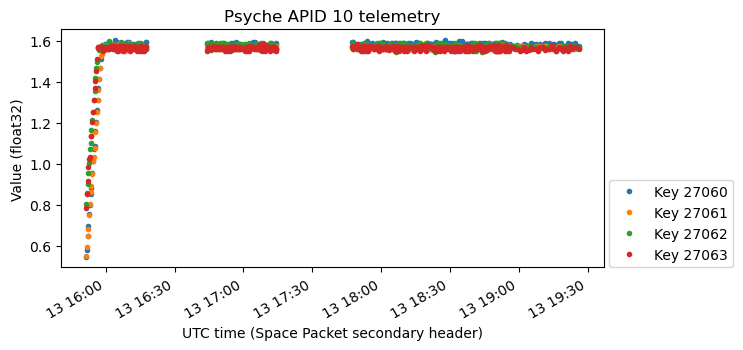

In [48]:
plot_keys(105*256+180+np.arange(4), 'float32')

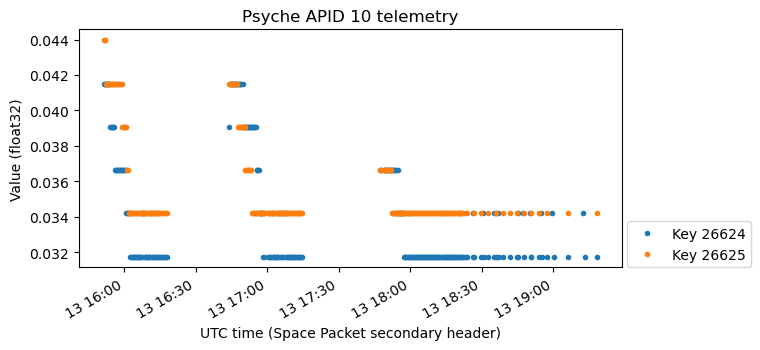

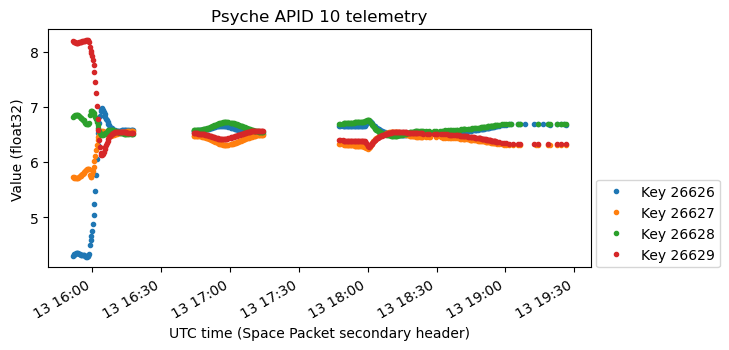

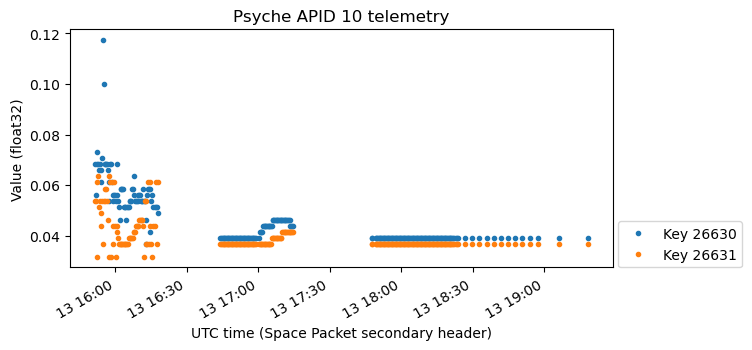

In [49]:
plot_keys(104*256+np.arange(2), 'float32')
plot_keys(104*256+np.arange(2, 6), 'float32')
plot_keys(104*256+np.arange(6, 8), 'float32')

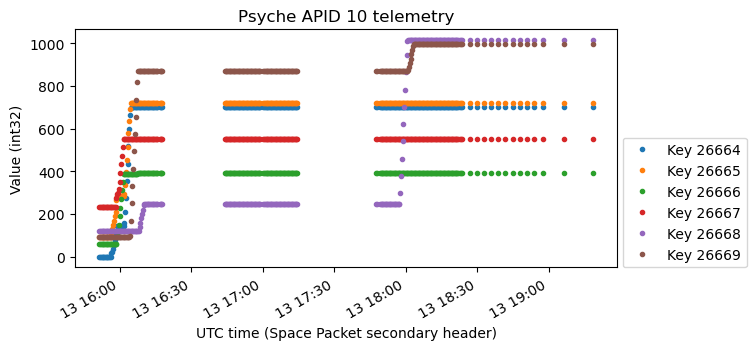

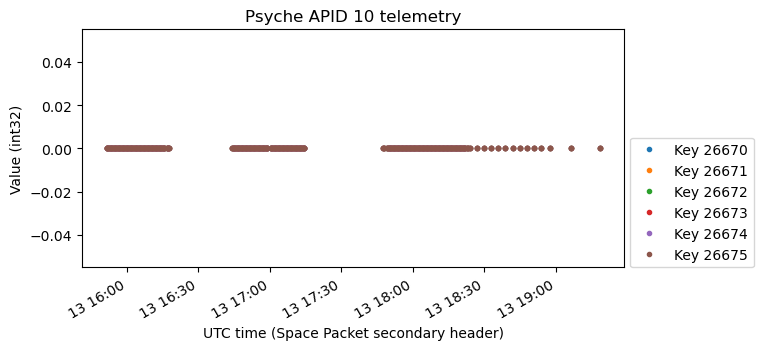

In [50]:
plot_keys(104*256+40+np.arange(6), 'int32')
plot_keys(104*256+40+np.arange(6, 12), 'int32')

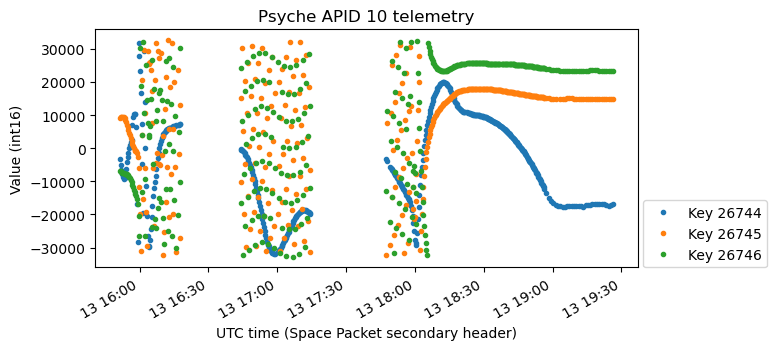

In [51]:
plot_keys(104*256+120+np.arange(3), 'int16')

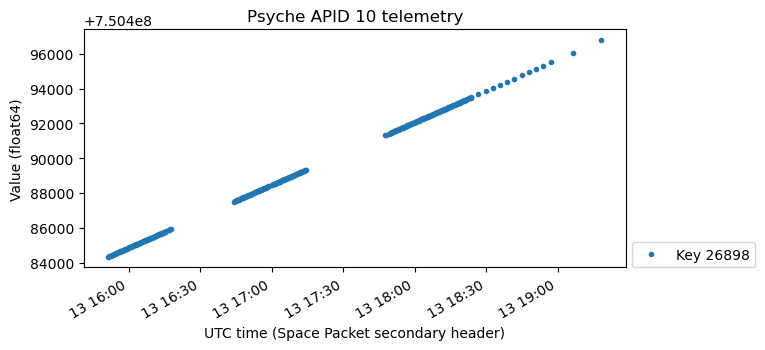

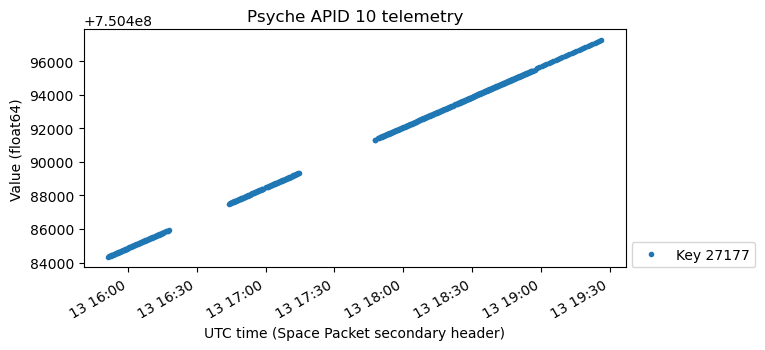

In [52]:
plot_keys([105*256+18], 'float64')
plot_keys([106*256+41], 'float64')

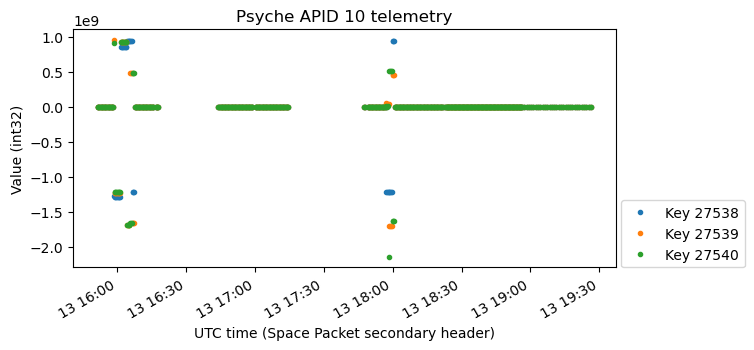

In [53]:
plot_keys(107*256+146+np.arange(3), 'int32')

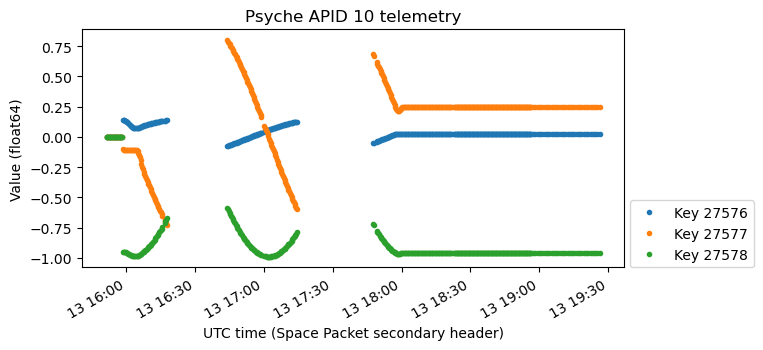

In [54]:
plot_keys(107*256+184+np.arange(3), 'float64')

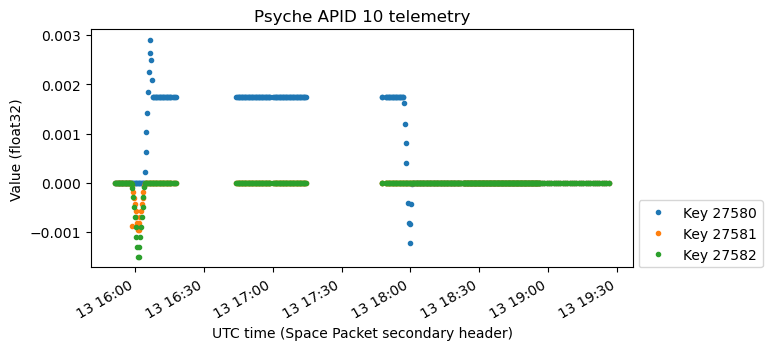

In [55]:
plot_keys(107*256+188+np.arange(3), 'float32')

In [56]:
tstamps = timestamps_by_apid[10][107*256+188]
tsel = (tstamps >= np.datetime64('2023-10-13T16:30')) & (tstamps <= np.datetime64('2023-10-13T17:30'))
xval = np.average(values_by_apid[10][107*256+188].view('float32').byteswap()[tsel])
xval

0.001745329

In [57]:
xval / (2 * np.pi) * 360

0.0999999858851501

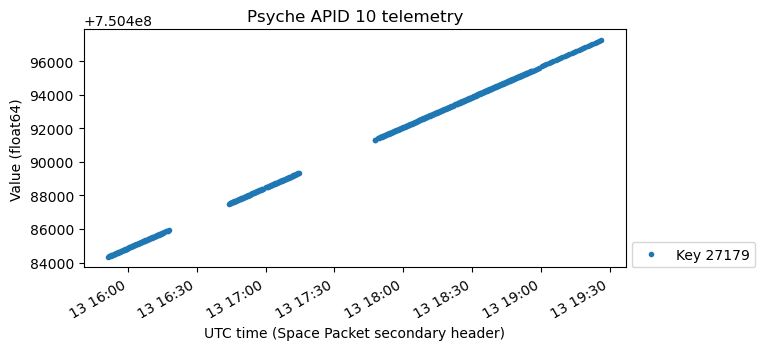

In [58]:
plot_keys([106*256+43], 'float64')

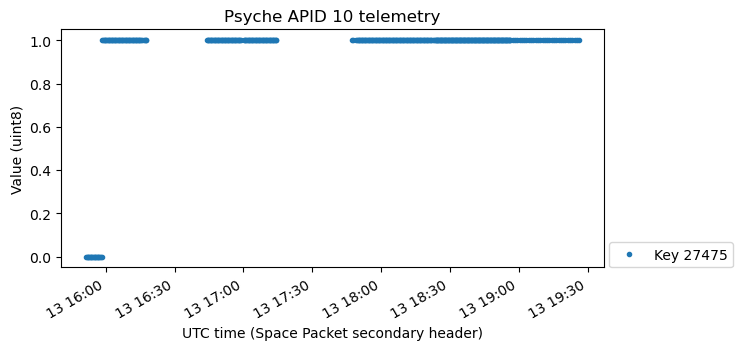

In [59]:
plot_keys([107*256+83], 'uint8')

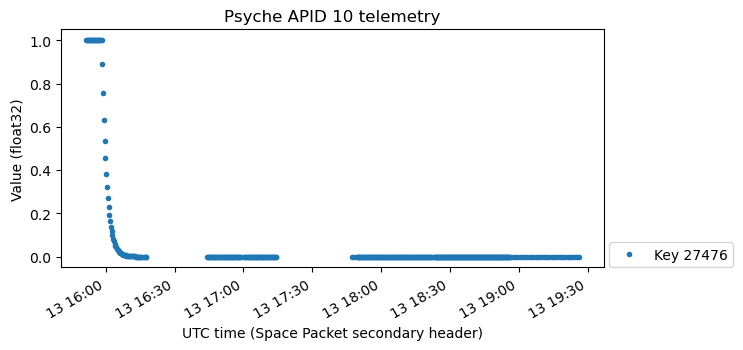

In [60]:
plot_keys([107*256+84], 'float32')

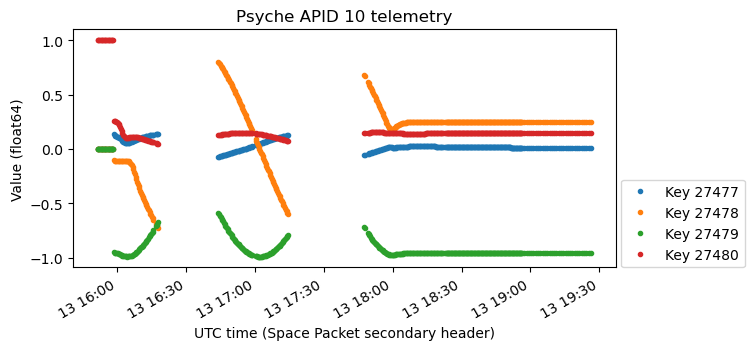

In [61]:
plot_keys(107*256+85+np.arange(4), 'float64')

In [62]:
q = Rotation.from_quat(np.stack([values_by_apid[10][107*256+85+j] for j in range(4)])
                       .view('float64').byteswap()[..., 0].T)
h = q.inv() * q[50]
V = h.as_quat()[:, :-1]
V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]
Vsign = np.sign(V[:, 0])
V *= Vsign[..., np.newaxis]

/tmp/ipykernel_32282/4100056727.py:5: RuntimeWarning: invalid value encountered in divide
  V /= np.sqrt(np.sum(V**2, axis = -1))[..., np.newaxis]


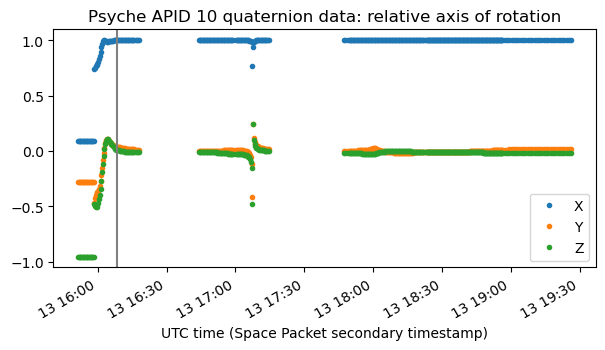

In [63]:
plt.plot(timestamps_by_apid[10][107*256+85], V, '.', label=['X', 'Y', 'Z'])
plt.axvline(x=timestamps_by_apid[10][107*256+85][50], color='grey')
plt.title('Psyche APID 10 quaternion data: relative axis of rotation')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time (Space Packet secondary timestamp)')
plt.legend();

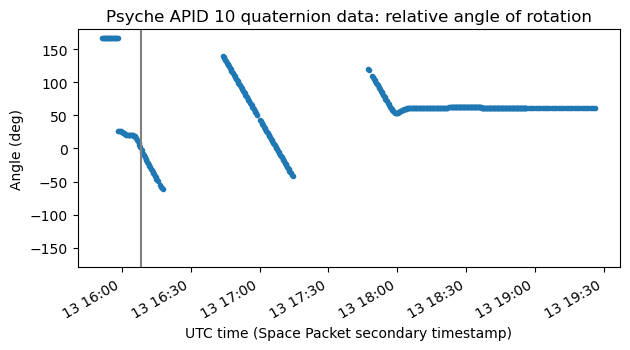

In [64]:
theta = 2 * np.arctan2(np.sqrt(np.sum(h.as_quat()[:,:-1]**2, axis = 1)), h.as_quat()[:,-1])
theta *= Vsign
plt.plot(timestamps_by_apid[10][107*256+85], np.rad2deg(theta), '.')
plt.axvline(x=timestamps_by_apid[10][107*256+85][50], color='grey')
plt.ylim(-180, 180)
plt.title('Psyche APID 10 quaternion data: relative angle of rotation')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time (Space Packet secondary timestamp)')
plt.ylabel('Angle (deg)');

In [65]:
sel = slice(80, 160)
rotation_deg_per_s = ((np.rad2deg(theta[sel][-1]) - np.rad2deg(theta[sel][0]))
 / ((timestamps_by_apid[10][107*256+85][sel][-1] - timestamps_by_apid[10][107*256+85][sel][0]) / np.timedelta64(1, 's')))
rotation_deg_per_s

array([-0.09992923])

In [66]:
r_sun = np.empty((timestamps_by_apid[10][107*256+85].size, 3))
r_ata = np.empty_like(r_sun)
for j, utc in enumerate(timestamps_by_apid[10][107*256+85].ravel()):
    et = sp.utc2et(str(utc))
    r_sun[j] = sp.spkpos('SUN', et, 'J2000', 'LT+S', '-255')[0]
    r_ata[j] = sp.spkpos('ATA', et, 'J2000', 'LT+S', '-255')[0]

for r in r_sun, r_ata:
    r /= np.sqrt(np.sum(r**2, axis=1)).reshape(-1, 1)

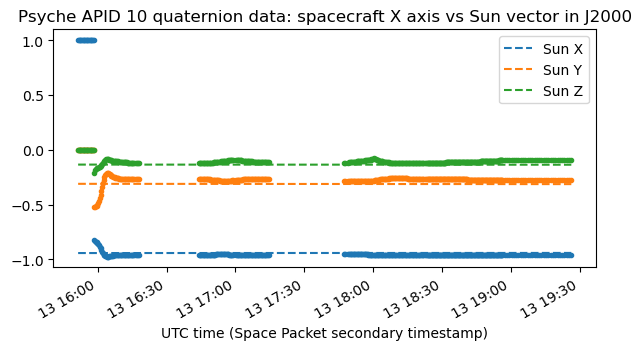

In [67]:
plt.plot(timestamps_by_apid[10][107*256+85], q.apply([1, 0, 0]), '.')
plt.gca().set_prop_cycle(None)
plt.plot(timestamps_by_apid[10][107*256+85], r_sun, '--', label=['Sun X', 'Sun Y', 'Sun Z'])
plt.legend()
plt.title('Psyche APID 10 quaternion data: spacecraft X axis vs Sun vector in J2000')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time (Space Packet secondary timestamp)');

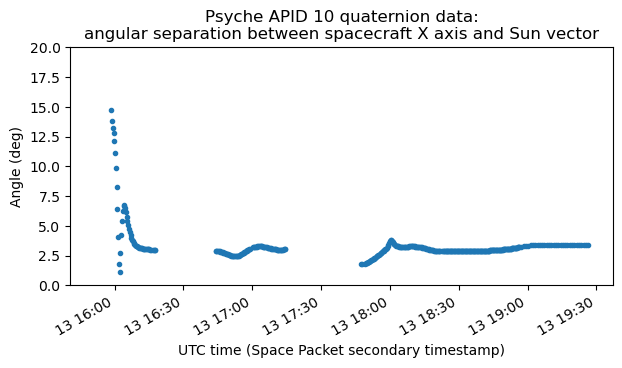

In [68]:
plt.plot(timestamps_by_apid[10][107*256+85],
         np.rad2deg(np.arccos(np.sum(q.apply([1, 0, 0]) * r_sun, axis=1))), '.')
plt.ylim(0, 20)
plt.title('Psyche APID 10 quaternion data:\nangular separation between spacecraft X axis and Sun vector')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time (Space Packet secondary timestamp)')
plt.ylabel('Angle (deg)');

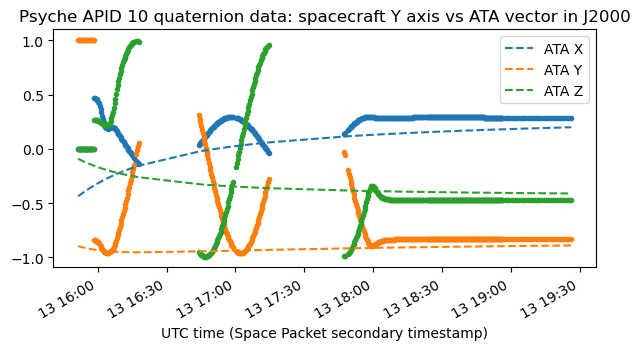

In [69]:
plt.plot(timestamps_by_apid[10][107*256+85], q.apply([0, 1, 0]), '.')
plt.gca().set_prop_cycle(None)
plt.plot(timestamps_by_apid[10][107*256+85], r_ata, '--', label=['ATA X', 'ATA Y', 'ATA Z'])
plt.legend()
plt.title('Psyche APID 10 quaternion data: spacecraft Y axis vs ATA vector in J2000')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time (Space Packet secondary timestamp)');

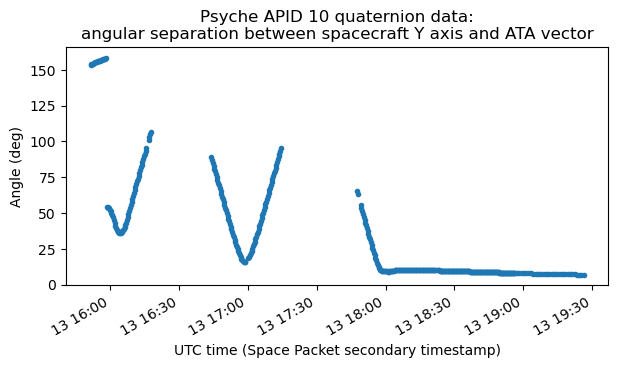

In [70]:
plt.plot(timestamps_by_apid[10][107*256+85],
         np.rad2deg(np.arccos(np.sum(q.apply([0, 1, 0]) * r_ata, axis=1))), '.')
plt.title('Psyche APID 10 quaternion data:\nangular separation between spacecraft Y axis and ATA vector')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time (Space Packet secondary timestamp)')
plt.ylabel('Angle (deg)');

In [71]:
t_ck_start = np.datetime64('2023-10-14T21:51:00')
t_ck_end = np.datetime64('2023-10-21T12:00:00')
t_ck_step = np.timedelta64(100, 's')
t_ck = t_ck_start + np.arange(int((t_ck_end - t_ck_start) / t_ck_step)) * t_ck_step

In [72]:
ck_sun = np.empty((t_ck.size, 3))
ck_earth = np.empty_like(ck_sun)
for j, utc in enumerate(t_ck):
    et = sp.utc2et(str(utc))
    ck_sun[j] = sp.spkpos('SUN', et, 'PSYC_SPACECRAFT', 'LT+S', '-255')[0]
    ck_earth[j] = sp.spkpos('EARTH', et, 'PSYC_SPACECRAFT', 'LT+S', '-255')[0]

for r in ck_sun, ck_earth:
    r /= np.sqrt(np.sum(r**2, axis=1)).reshape(-1, 1)

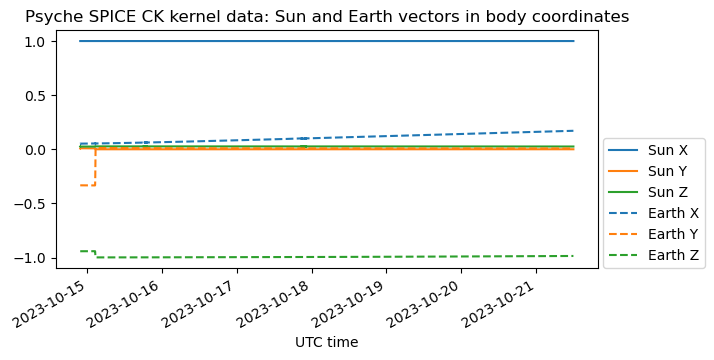

In [73]:
plt.plot(t_ck, ck_sun, label=['Sun X', 'Sun Y', 'Sun Z'])
plt.gca().set_prop_cycle(None)
plt.plot(t_ck, ck_earth, '--', label=['Earth X', 'Earth Y', 'Earth Z'])
plt.legend(loc=[1.01, 0])
plt.title('Psyche SPICE CK kernel data: Sun and Earth vectors in body coordinates')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time');

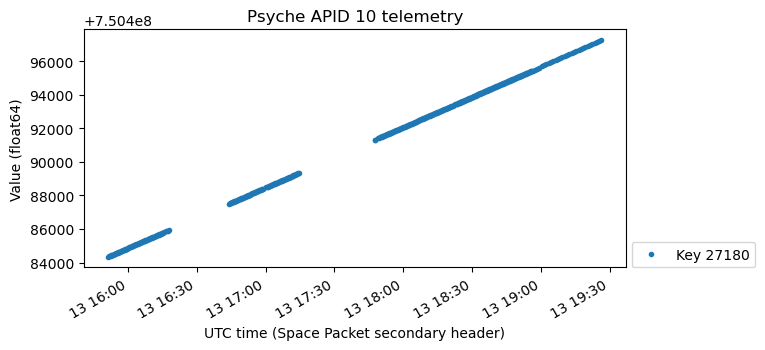

In [74]:
plot_keys([106*256+44], 'float64')

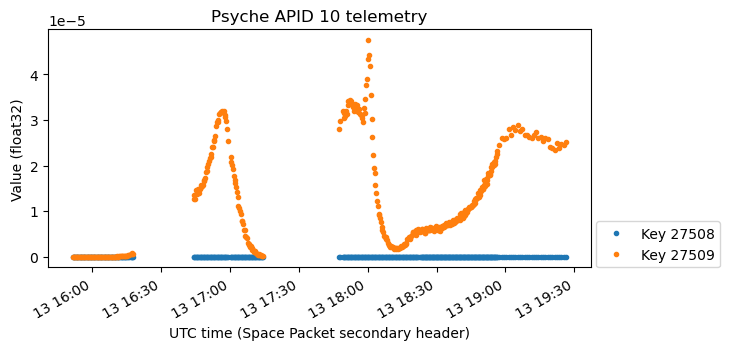

In [75]:
plot_keys(107*256+116+np.arange(2), 'float32')

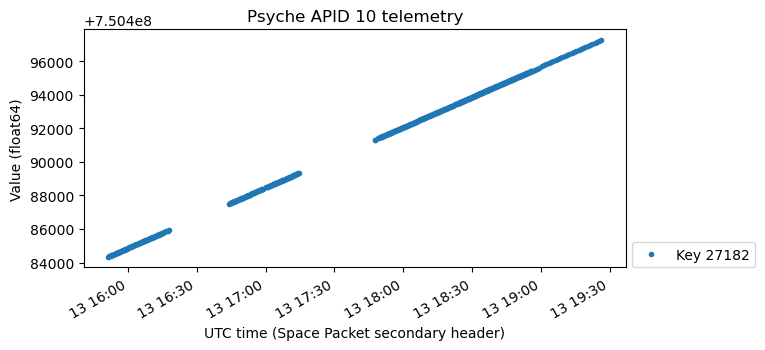

In [76]:
plot_keys([106*256+46], 'float64')

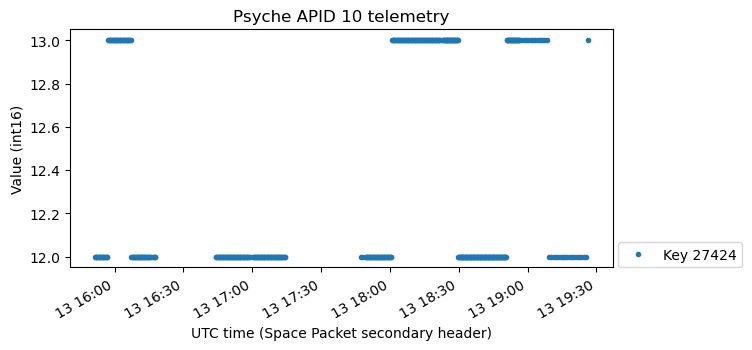

In [77]:
plot_keys([107*256+32], 'int16')

In [78]:
0.0016 * 10 * (2 * np.pi)  # gyro scale

0.10053096491487339

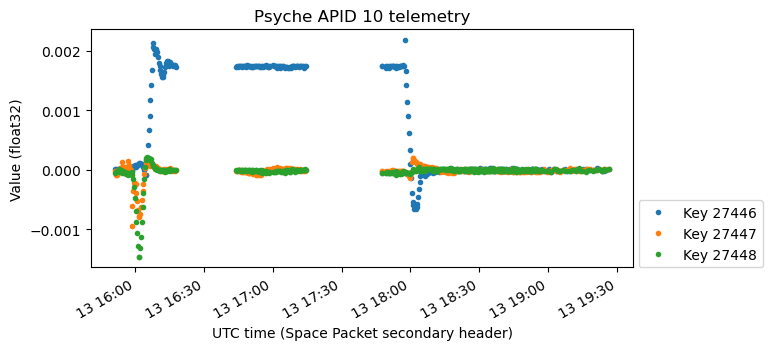

In [79]:
plot_keys(107*256+54+np.arange(3), 'float32')

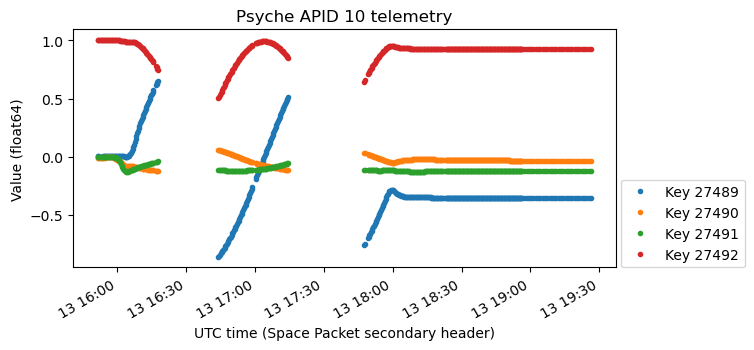

In [80]:
plot_keys(107*256+97+np.arange(4), 'float64')

In [81]:
q2 = Rotation.from_quat(np.stack([values_by_apid[10][107*256+97+j] for j in range(4)])
                        .view('float64').byteswap()[..., 0].T)

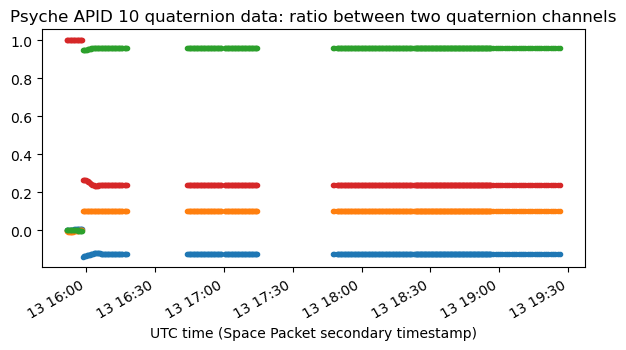

In [82]:
plt.plot(timestamps_by_apid[10][107*256+97], (q2 * q.inv()).as_quat(), '.')
plt.title('Psyche APID 10 quaternion data: ratio between two quaternion channels')
plt.gcf().autofmt_xdate()
plt.xlabel('UTC time (Space Packet secondary timestamp)');

In [83]:
q2q = (q2 * q.inv())[-1]
W = q2q.as_quat()[:-1]
W /= np.sqrt(np.sum(W**2, axis = -1))[..., np.newaxis]
W

array([-0.12849493,  0.10324201,  0.98632152])

In [84]:
phi = 2 * np.arctan2(np.sqrt(np.sum(q2q.as_quat()[:-1]**2)), q2q.as_quat()[-1])
np.rad2deg(phi)

152.3114149900083

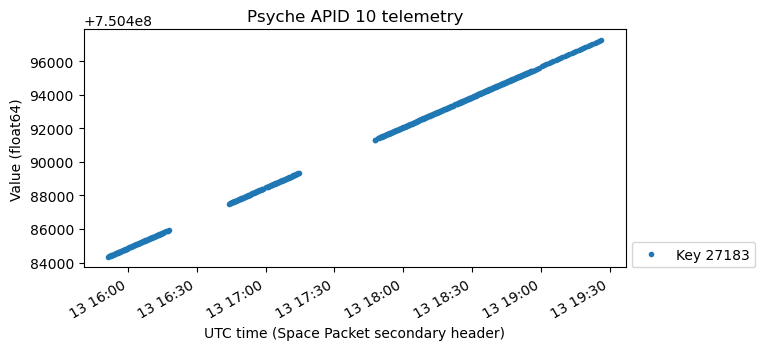

In [85]:
plot_keys([106*256+47], 'float64')

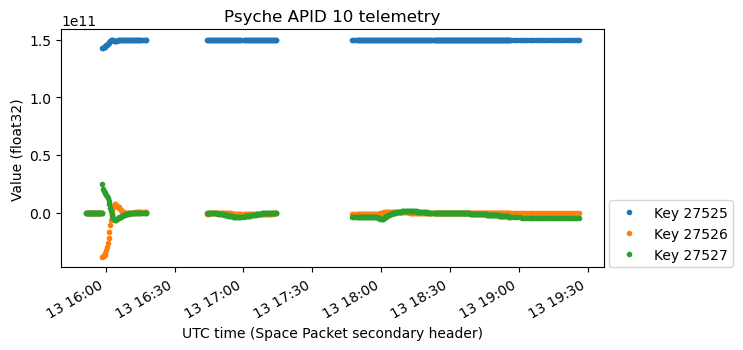

In [86]:
plot_keys(107*256+133+np.arange(3), 'float32')

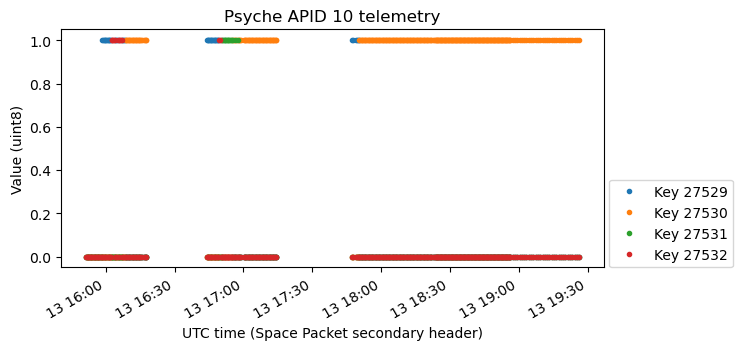

In [87]:
plot_keys(107*256+137+np.arange(4), 'uint8')

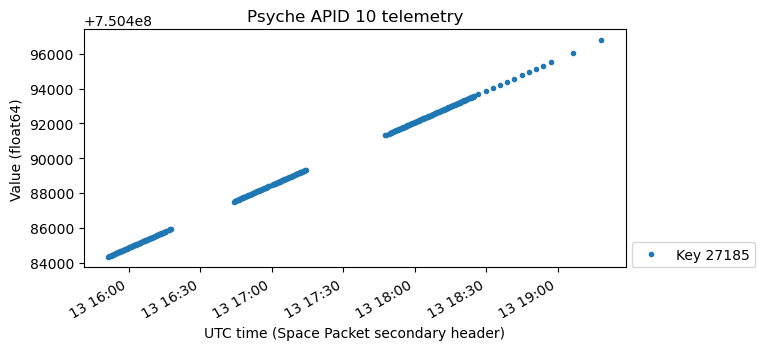

In [88]:
plot_keys([106*256+49], 'float64')

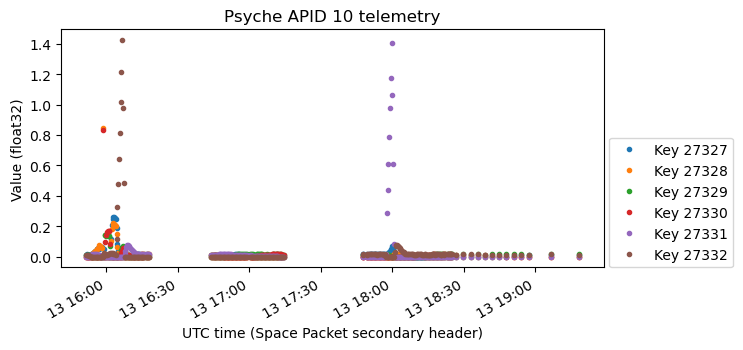

In [89]:
plot_keys(106*256+191+np.arange(6), 'float32')

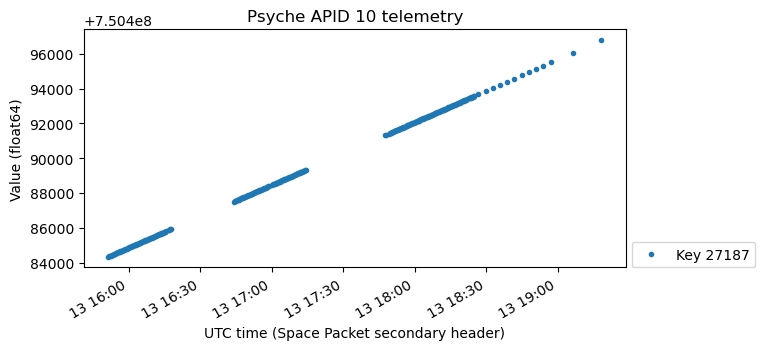

In [90]:
plot_keys([106*256+51], 'float64')

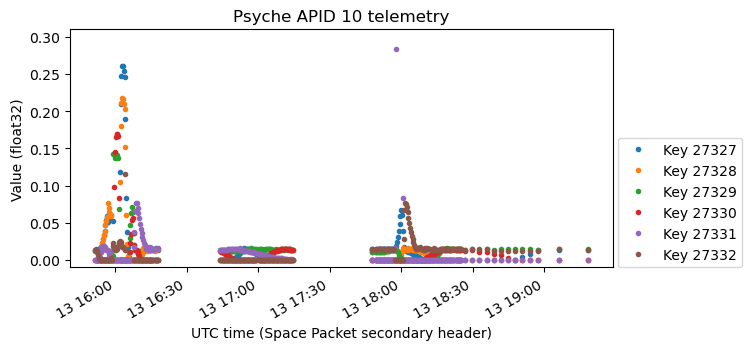

In [91]:
plot_keys(106*256+191+np.arange(6), 'float32')
plt.ylim((-0.01,0.31));

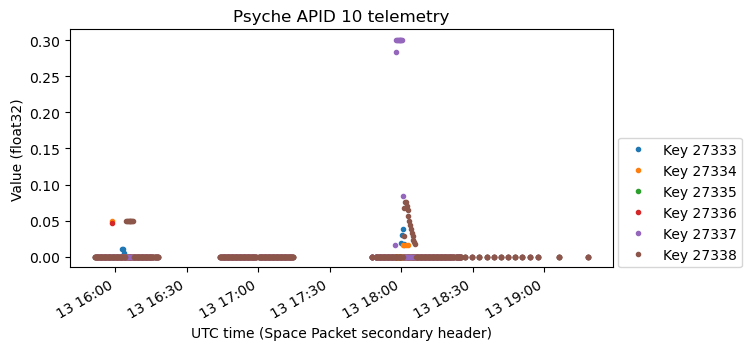

In [92]:
plot_keys(106*256+197+np.arange(6), 'float32')

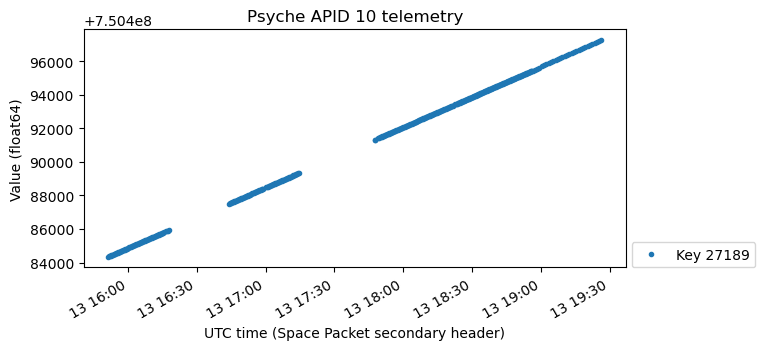

In [93]:
plot_keys([106*256+53], 'float64')

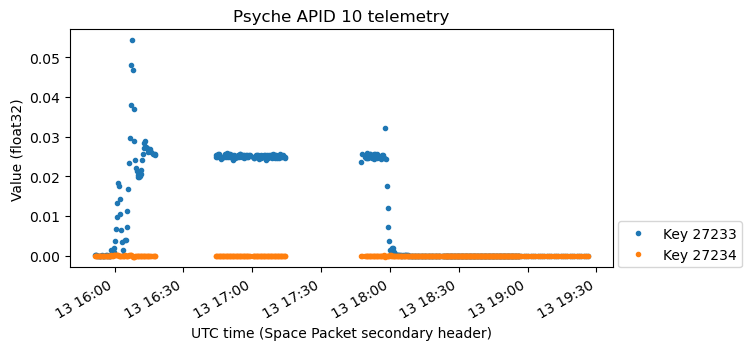

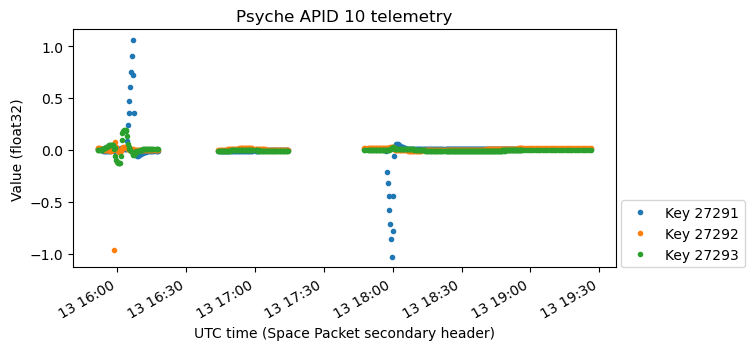

In [94]:
plot_keys(106*256+97+np.arange(2), 'float32')
plot_keys(106*256+155+np.arange(3), 'float32')

In [95]:
tstamps = timestamps_by_apid[10][106*256+97]
tsel = (tstamps >= np.datetime64('2023-10-13T16:30')) & (tstamps <= np.datetime64('2023-10-13T17:30'))
xval = np.average(values_by_apid[10][106*256+97].view('float32').byteswap()[tsel])
xval

0.025035251

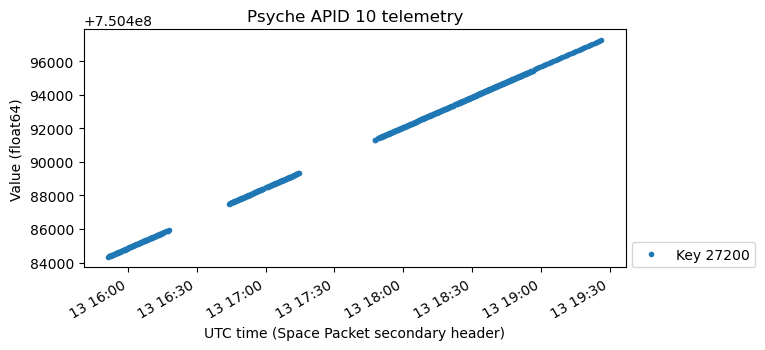

In [96]:
plot_keys([106*256+64], 'float64')

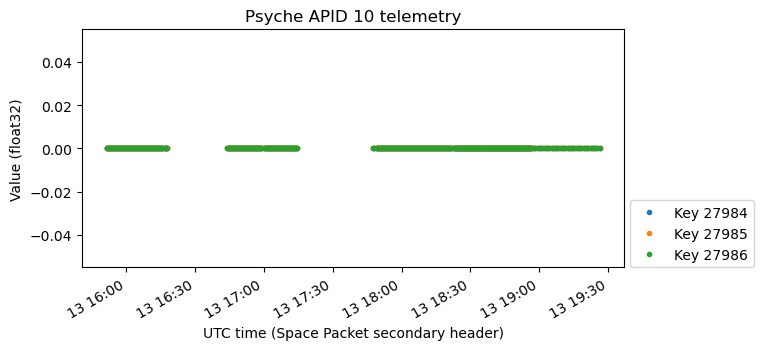

In [97]:
plot_keys(109*256+80+np.arange(3), 'float32')

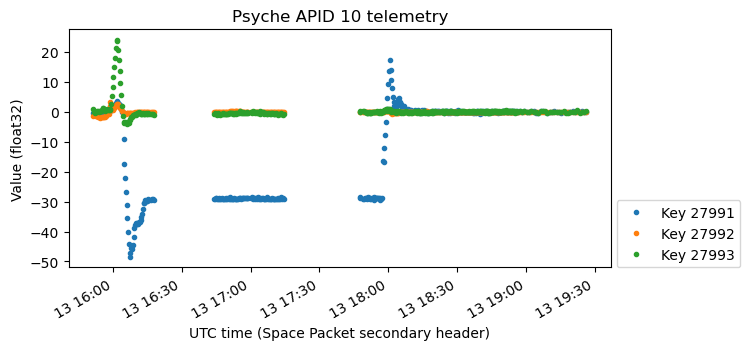

In [98]:
plot_keys(109*256+87+np.arange(3), 'float32')

In [99]:
tstamps = timestamps_by_apid[10][109*256+87]
tsel = (tstamps >= np.datetime64('2023-10-13T16:30')) & (tstamps <= np.datetime64('2023-10-13T17:30'))
xval = np.average(values_by_apid[10][109*256+87].view('float32').byteswap()[tsel])
xval

-28.936327

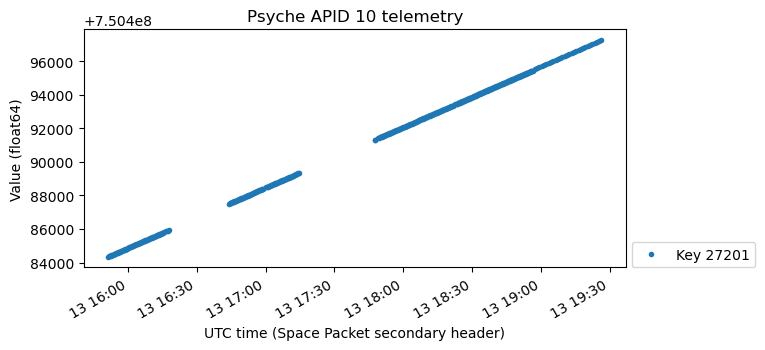

In [100]:
plot_keys([106*256+65], 'float64')

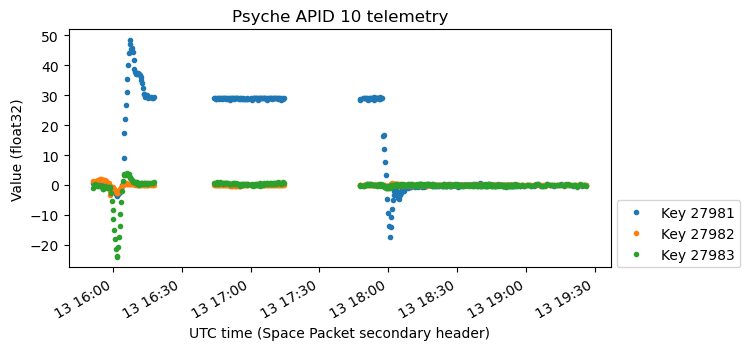

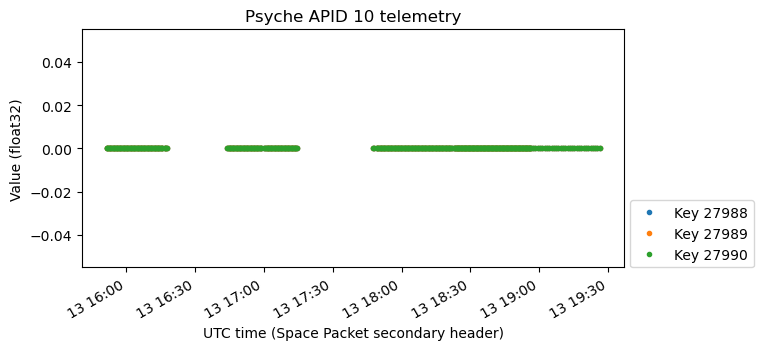

In [101]:
plot_keys(109*256+77+np.arange(3), 'float32')
plot_keys(109*256+84+np.arange(3), 'float32')

In [102]:
tstamps = timestamps_by_apid[10][109*256+77]
tsel = (tstamps >= np.datetime64('2023-10-13T16:30')) & (tstamps <= np.datetime64('2023-10-13T17:30'))
xval = np.average(values_by_apid[10][109*256+77].view('float32').byteswap()[tsel])
xval

28.936327

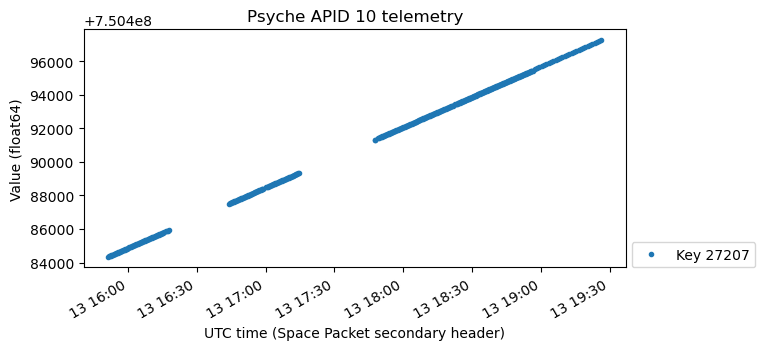

In [103]:
plot_keys([106*256+71], 'float64')

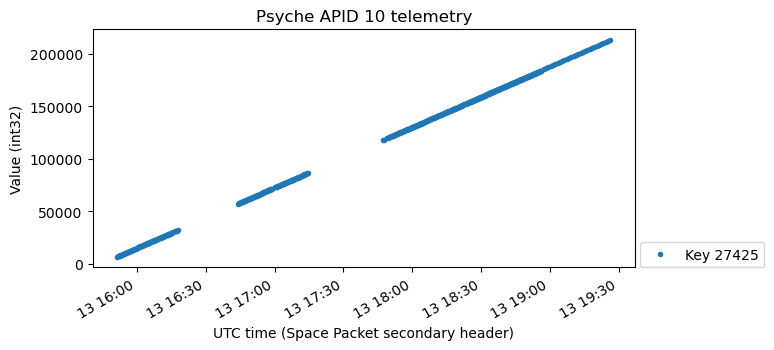

In [104]:
plot_keys([107*256+33], 'int32')

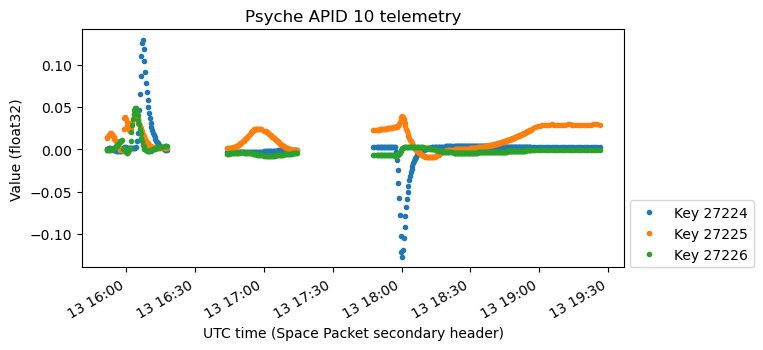

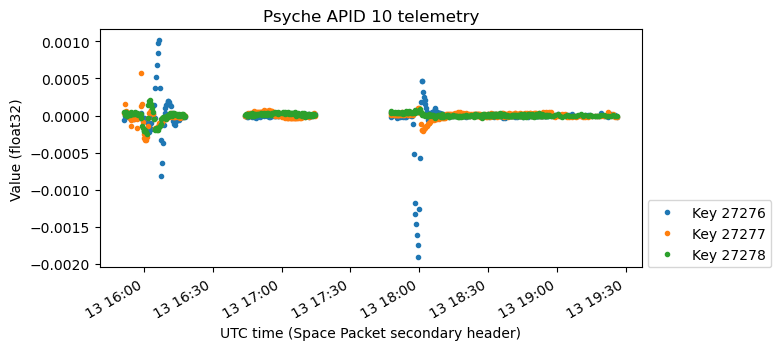

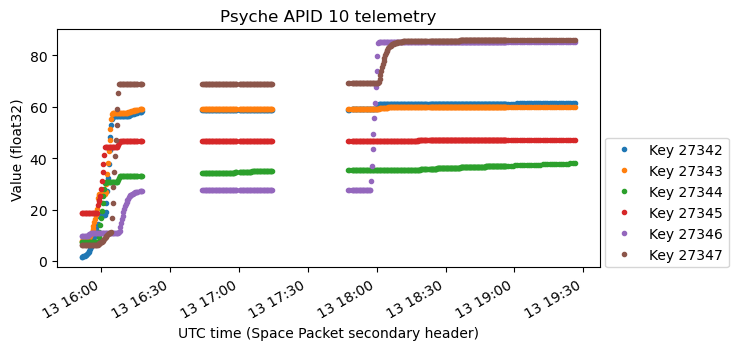

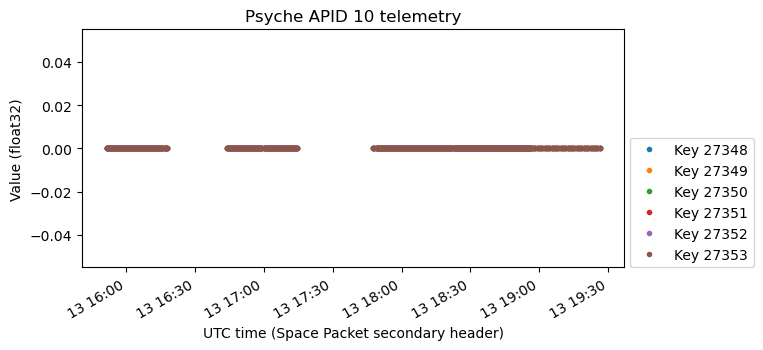

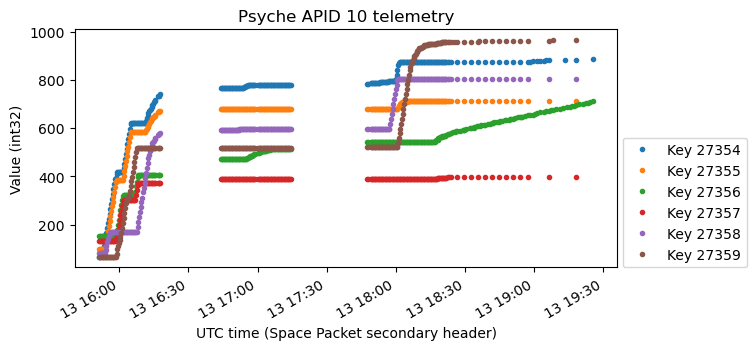

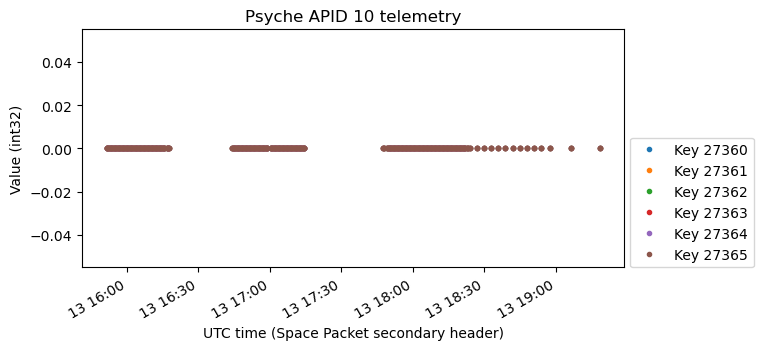

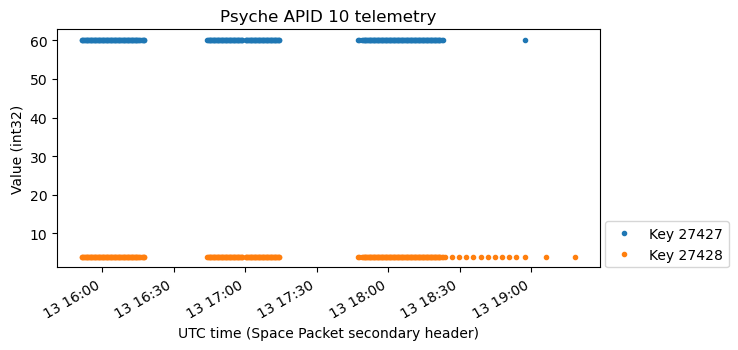

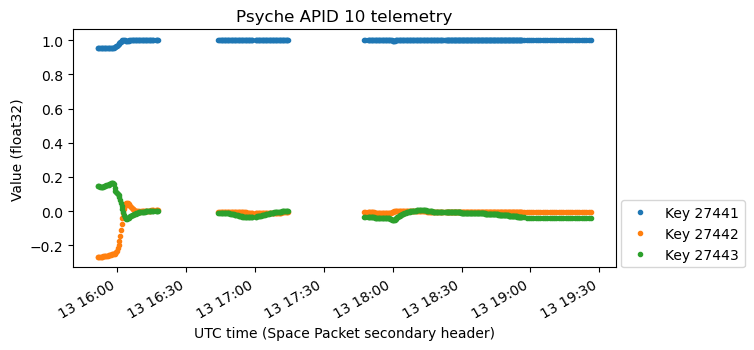

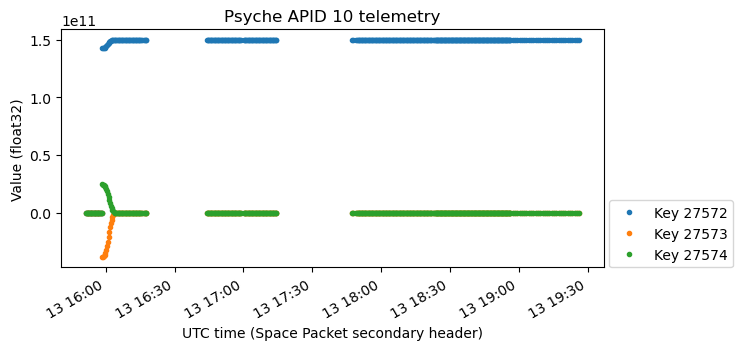

In [105]:
plot_keys(106*256+88+np.arange(3), 'float32')
plot_keys(106*256+140+np.arange(3), 'float32')
plot_keys(106*256+206+np.arange(6), 'float32')
plot_keys(106*256+206+np.arange(6, 12), 'float32')
plot_keys(106*256+206+np.arange(12, 18), 'int32')
plot_keys(106*256+206+np.arange(18, 24), 'int32')
plot_keys(107*256+35+np.arange(2), 'int32')
plot_keys(107*256+49+np.arange(3), 'float32')
plot_keys(107*256+180+np.arange(3), 'float32')

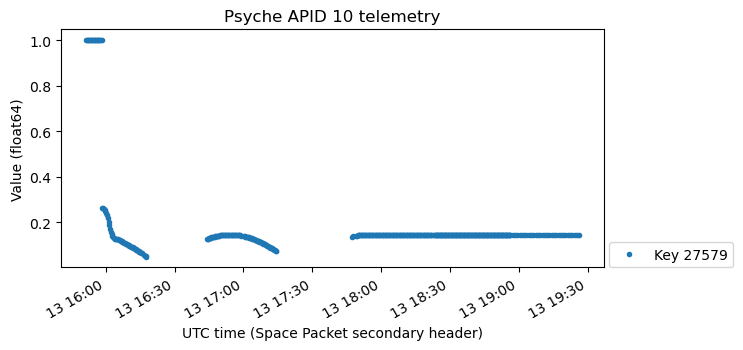

In [106]:
plot_keys([107*256+187], 'float64')

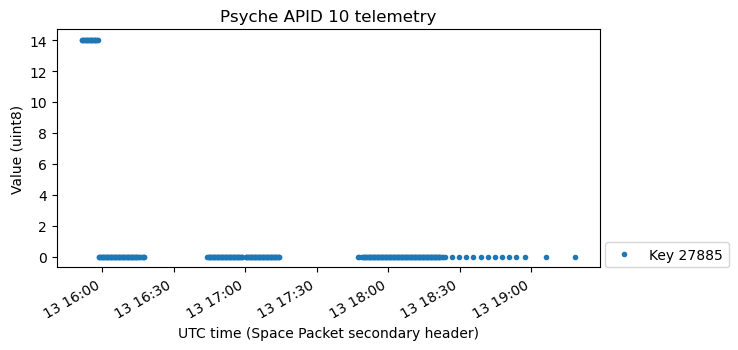

In [107]:
plot_keys([108*256+237], 'uint8')

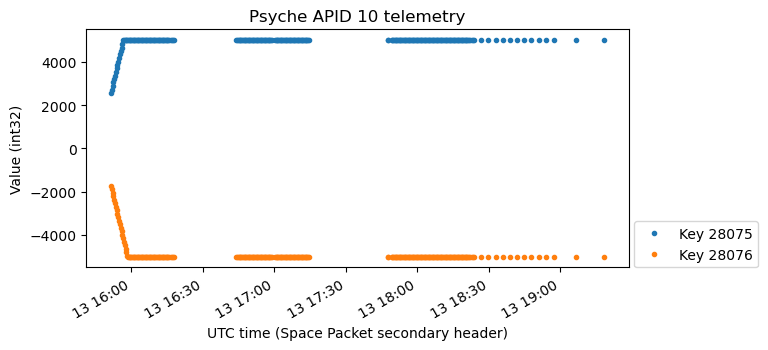

In [108]:
plot_keys(109*256+171+np.arange(2), 'int32')

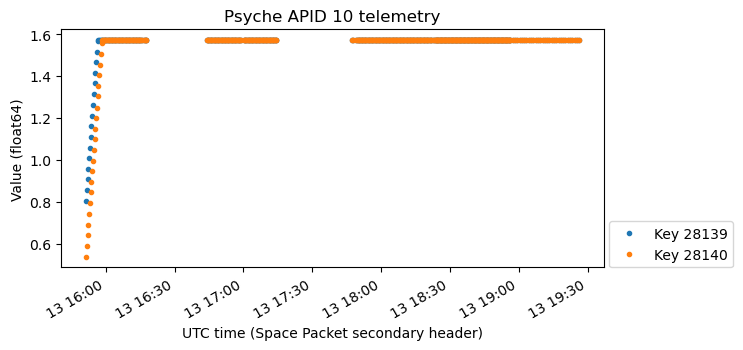

In [109]:
plot_keys(109*256+235+np.arange(2), 'float64')

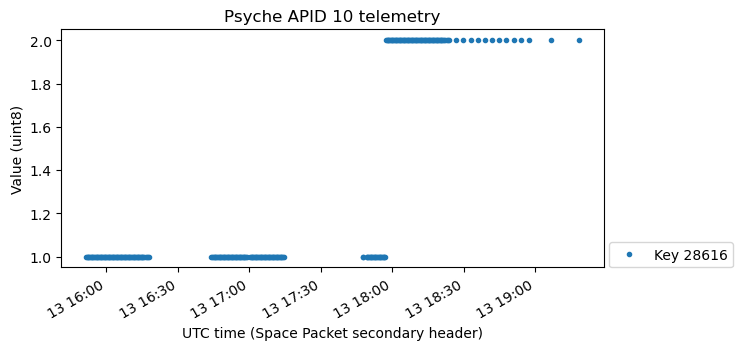

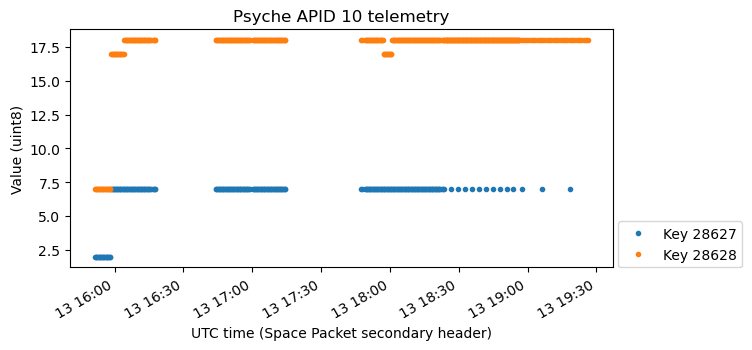

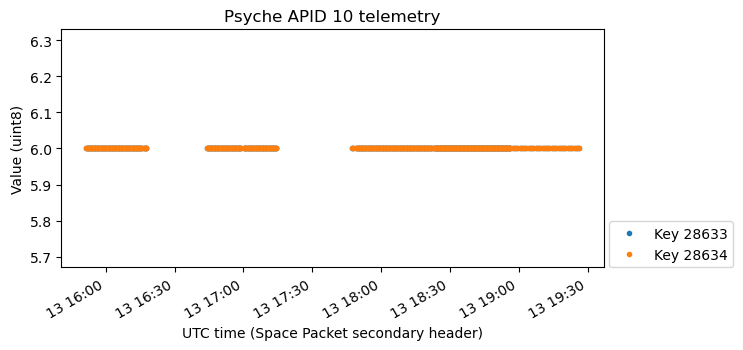

In [110]:
plot_keys([111*256+200], 'uint8')
plot_keys(111*256+211+np.arange(2), 'uint8')
plot_keys(111*256+217+np.arange(2), 'uint8')

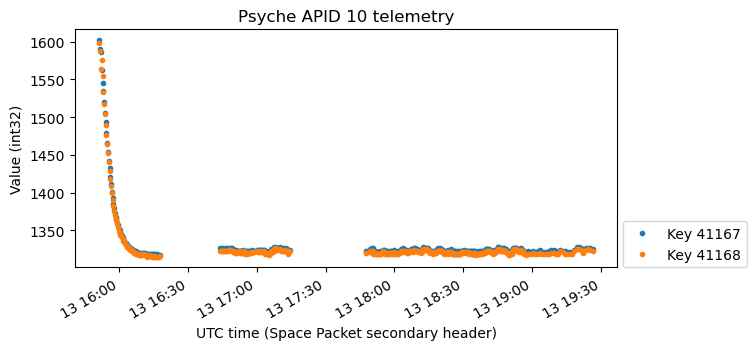

In [111]:
plot_keys(160*256+207+np.arange(2), 'int32')

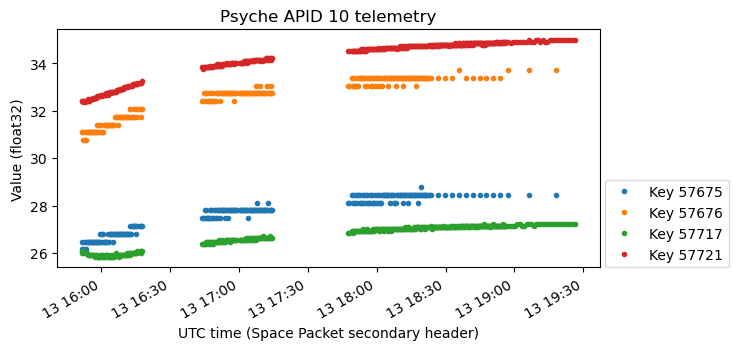

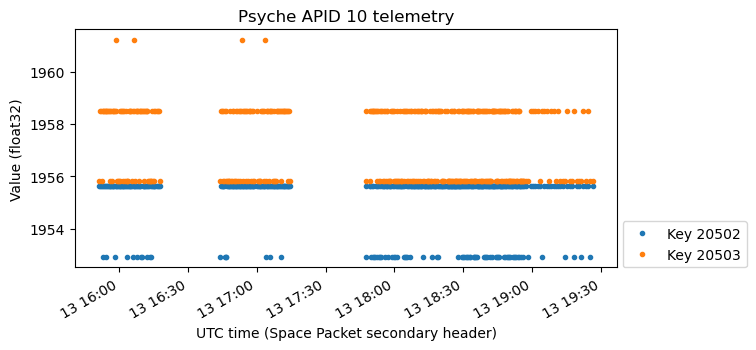

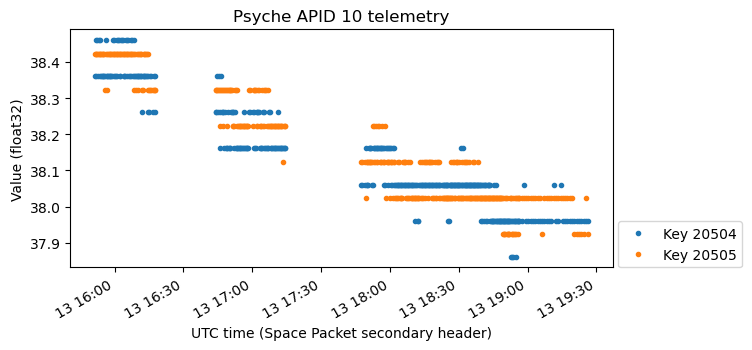

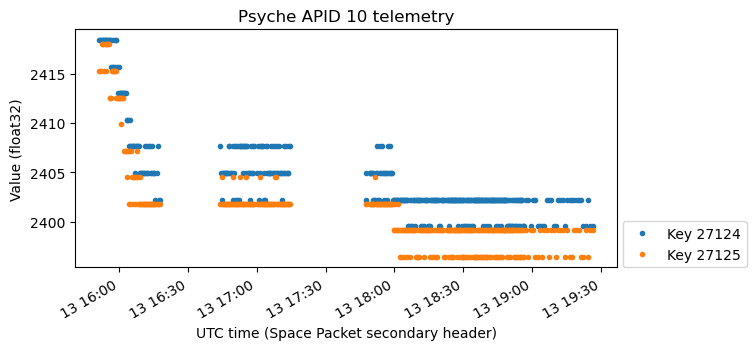

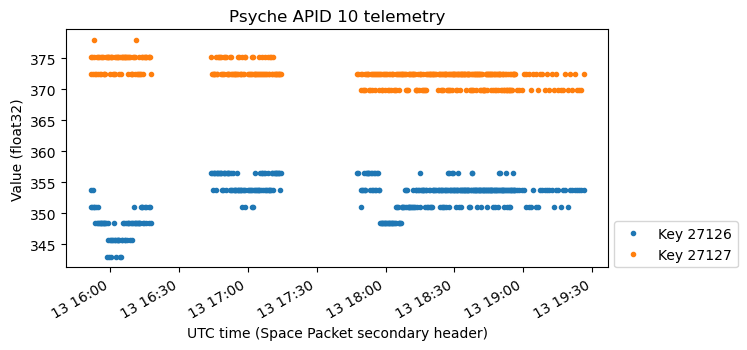

In [112]:
plot_keys(225*256+np.array([75, 76, 117, 121]), 'float32')
plot_keys(80*256+22+np.arange(2), 'float32')
plot_keys(80*256+22+np.arange(2, 4), 'float32')
plot_keys(105*256+244+np.arange(2), 'float32')
plot_keys(105*256+244+np.arange(2, 4), 'float32')

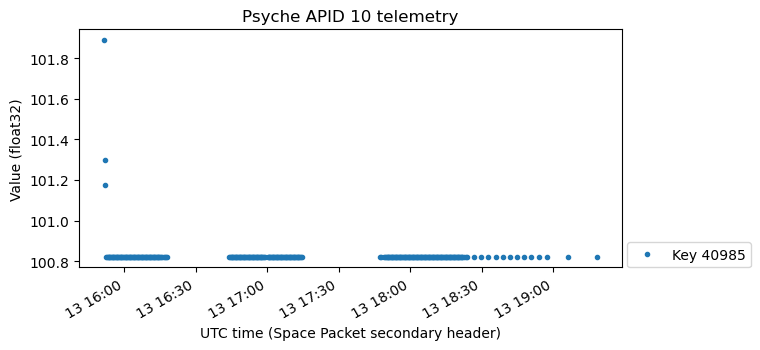

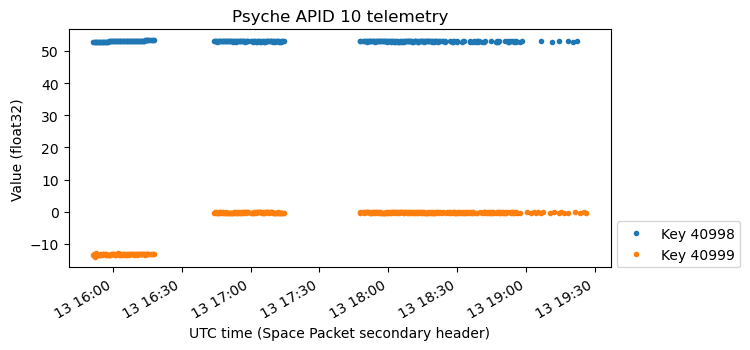

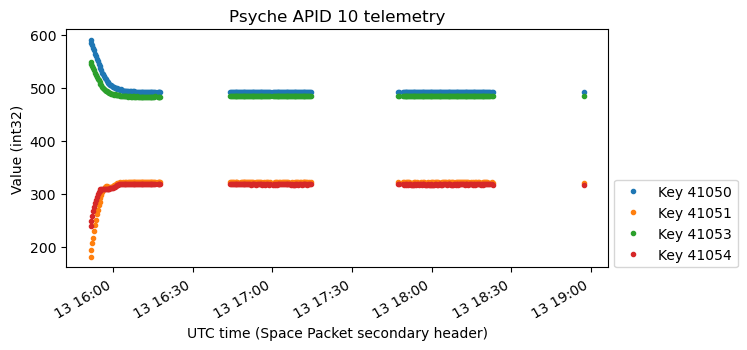

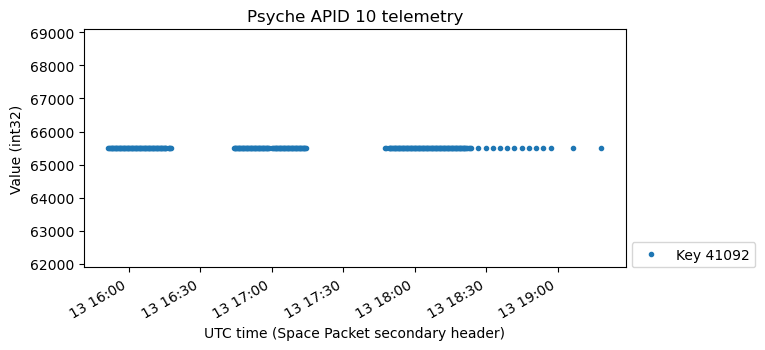

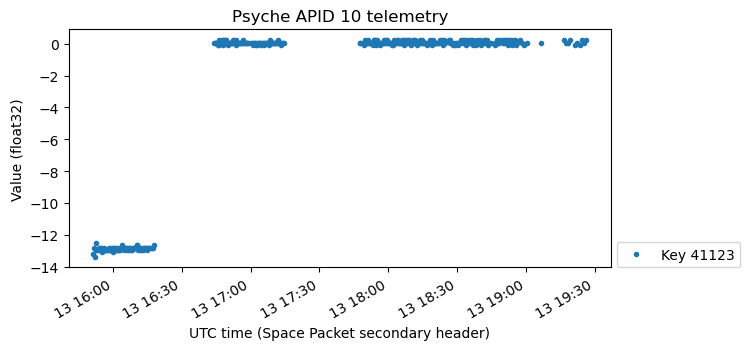

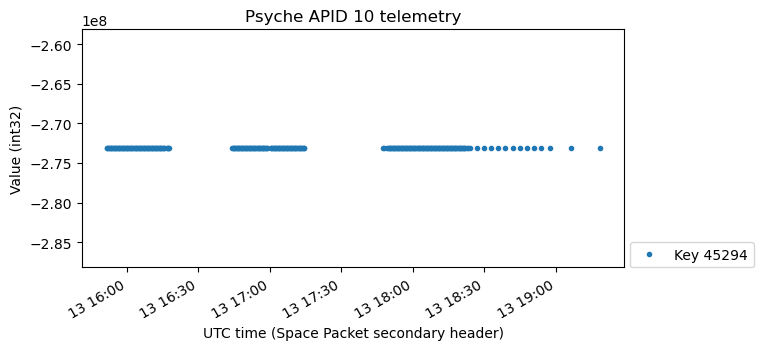

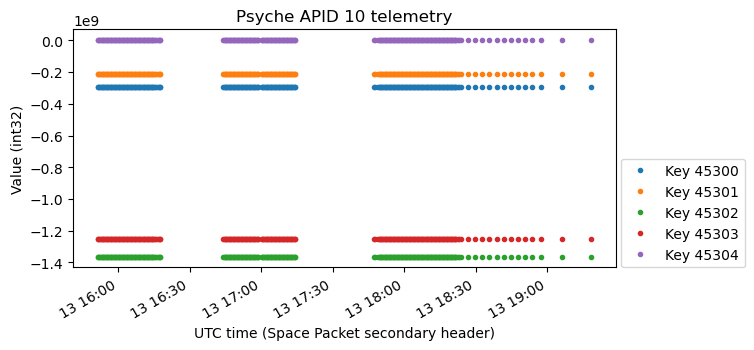

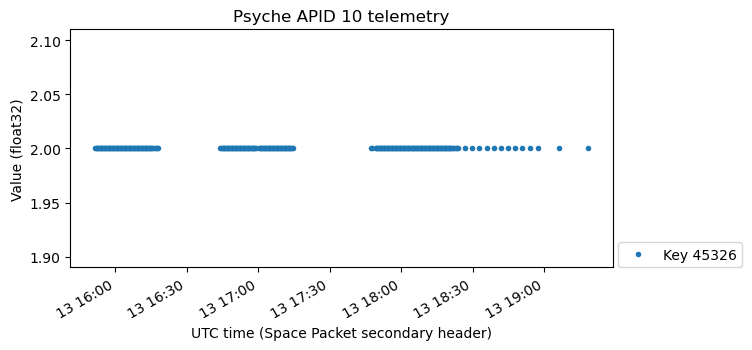

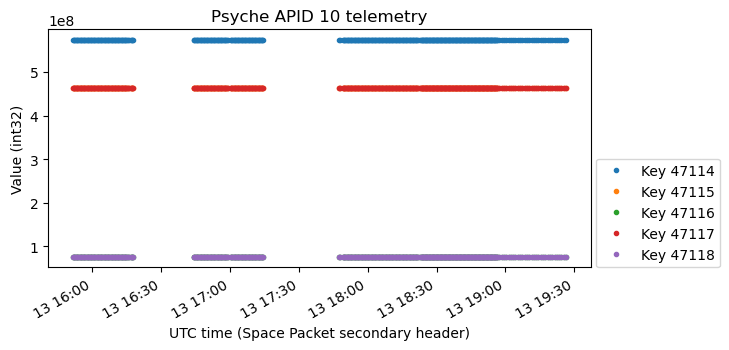

In [113]:
plot_keys([160*256+25], 'float32')
plot_keys(160*256+38+np.arange(2), 'float32')
plot_keys(160*256+np.array([90, 91, 93, 94]), 'int32')
plot_keys([160*256+132], 'int32')
plot_keys([160*256+163], 'float32')
plot_keys([176*256+238], 'int32')
plot_keys(176*256+244+np.arange(5), 'int32')
plot_keys([177*256+14], 'float32')
plot_keys(184*256+10+np.arange(5), 'int32')

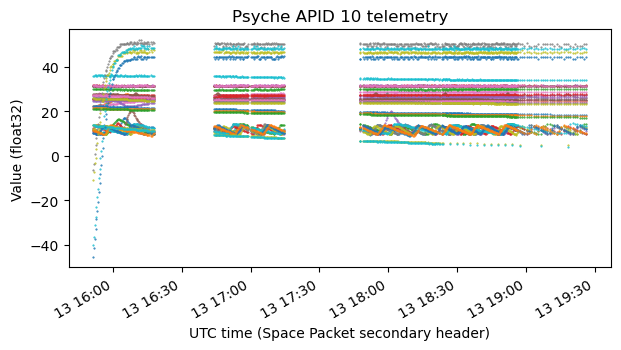

In [114]:
kselect = sorted(list({k for k, v in timestamps_by_apid[10].items()
                       if k // 256 == 224 and v[0] <= np.datetime64('2023-10-13T18:00')}))

plot_keys(np.concatenate((kselect,
                          225*256+69+np.arange(0))), 'float32', markersize=1, legend=False)

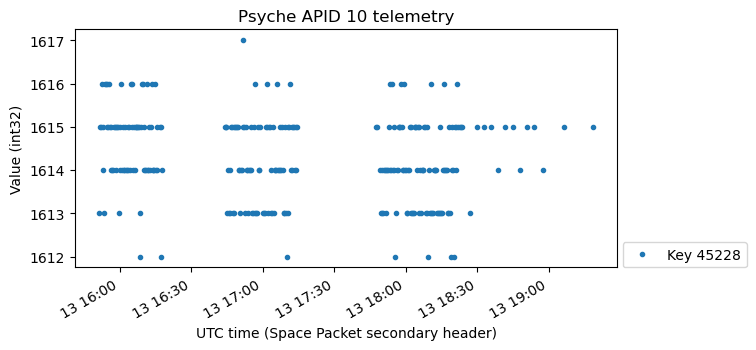

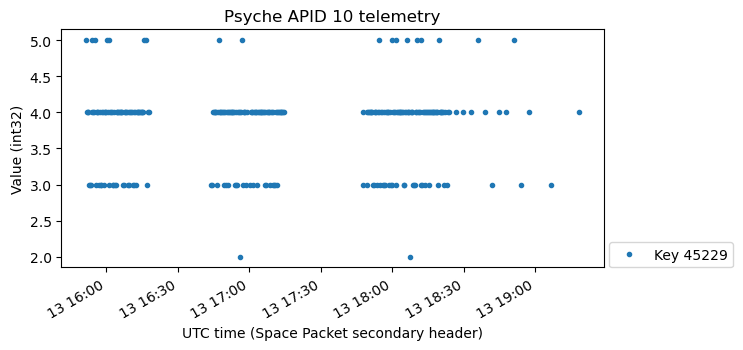

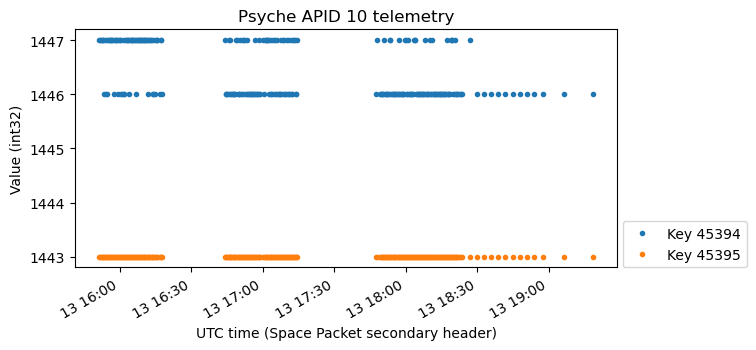

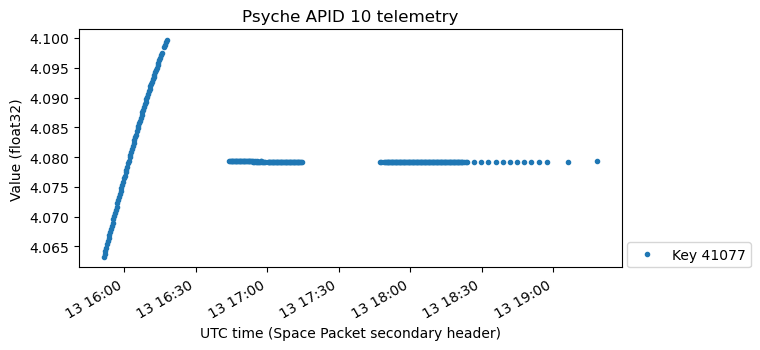

In [115]:
plot_keys([176*256+172], 'int32')
plot_keys([176*256+173], 'int32')
plot_keys(177*256+82+np.arange(2), 'int32')
plot_keys([160*256+117], 'float32')

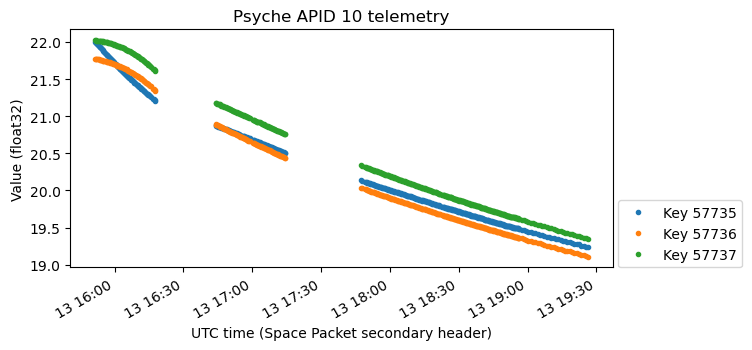

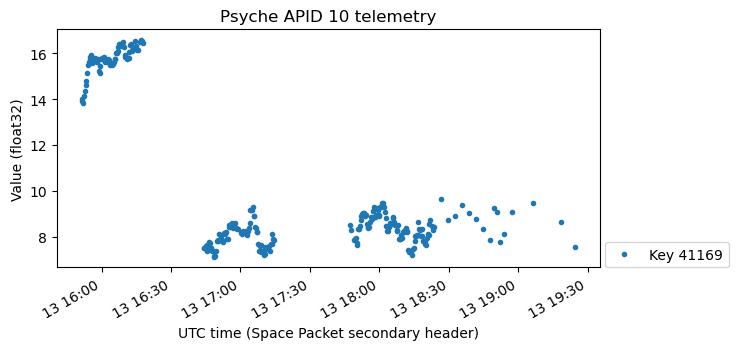

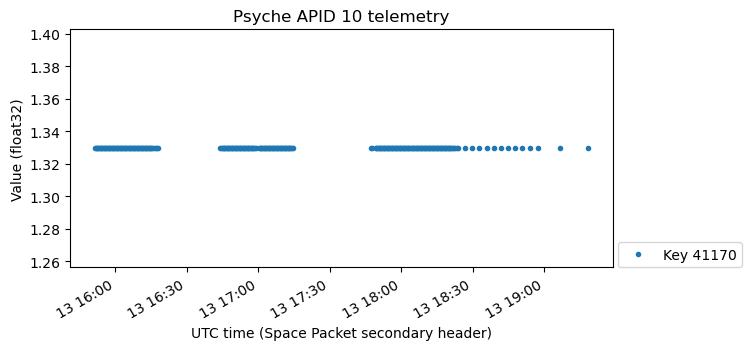

In [116]:
plot_keys(225*256+135+np.arange(3), 'float32')
plot_keys([160*256+209], 'float32')
plot_keys([160*256+210], 'float32')

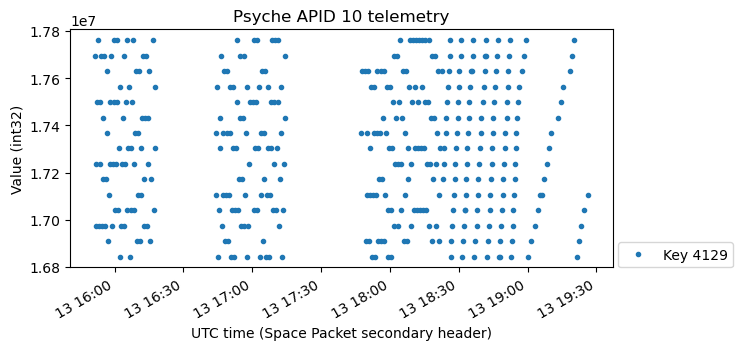

In [117]:
plot_keys([16*256+33], 'int32')

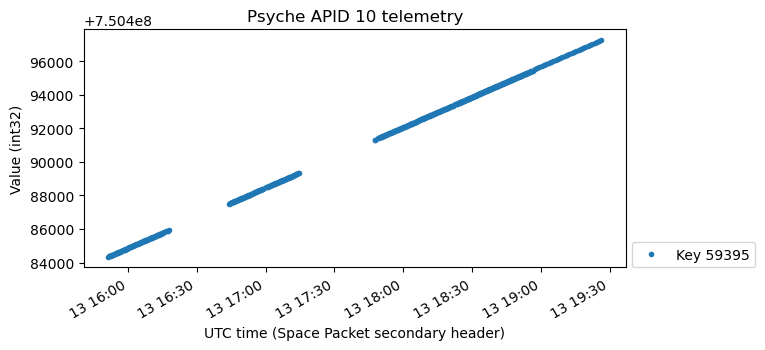

In [118]:
plot_keys([232*256+3], 'int32')

# VC 1

Virtual channel 1 is used to send files using CFDP. Files are sent in the following APIDs according to their type:

- APID 102. The files contain Space Packets from APID 24. These contain "sentences" that start by an ASCII code identifying a spacecraft subsystem.
- APID 103. The files contain Space Packets from APID 25. These contain "sentences" that start by an ASCII code identifying a spacecraft subsystem.
- APID 104. The files contain Space Packets from APID 26. These contain "sentences" that start by an ASCII code identifying a spacecraft subsystem.
- APID 107. The files contain Space Packets from APID 30, which corresponds to recorded telemetry in the same format as APID 10 (which has real-time telemetry).
- APID 300. Contains 39 byte segments that start with a 5-byte timestamp and then contain recorded telemetry in fixed fields format.
- APID 318. Contains 406 byte segments that start with a 5-byte timestamp and then contain recorded telemetry in fixed fields format.
- APID 1002.Contains 14 byte segments that start with a 5-byte timestamp and then contain recorded telemetry in fixed fields format.

In [119]:
[a.primary_header for a in tm if a.primary_header.virtual_channel_id == 1][:10]

[Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=1, virtual_channel_frame_count=39169, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=1, virtual_channel_frame_count=39170, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=1, virtual_channel_frame_count=39171, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=1, virtual_channel_frame_count=39172, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=255, virtual_channel_id=1, virtual_channel_frame_count=39173, replay_flag=False, vc_frame_count_usage_

In [120]:
packets_vc1 = list(ccsds.extract_space_packets(tm, 255, 1))

/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 1] Broken stream. Last frame count 51259, current frame count 51261
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 1] Broken stream. Last frame count 51335, current frame count 51337
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 1] Broken stream. Last frame count 51350, current frame count 51352
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame

In [121]:
headers_vc1 = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets_vc1]
apids_vc1 = collections.Counter([p.APID for p in headers_vc1])
apids_vc1

Counter({318: 1933,
         107: 800,
         300: 558,
         2047: 45,
         104: 8,
         103: 8,
         102: 6,
         1002: 3})

In [122]:
by_apid_vc1 = {apid: [p for p, h in zip(packets_vc1, headers_vc1) if h.APID == apid]
               for apid in apids_vc1}

In [123]:
by_apid_vc1[2047][0]

b'\x07\xff\xea\x05\x00\xe9A.Arslanian D.Beach M.Belete A.Bhosle Y.Brenman  \nD.Byrne R.Cheng P.Cheung M.Cisler D.Cummings     \nA.Dobrev P.Doronila B.Duckett D.Gaines L.Galdamez\nL.Hall S.Harris H.Hartounian D.Hecox Q.Ho        \nJ.Hofman Z.Hua C.Jones W.Kaye D.Ko'

In [124]:
sec_headers_vc1 = np.array([np.frombuffer(p[6:6+6], 'uint8') for p, h in zip(packets_vc1, headers_vc1)
                            if h.secondary_header_flag])
timestamps_vc1 = (sec_headers_vc1[:, :4].view('uint32').byteswap().ravel()
                  + sec_headers_vc1[:, -2:].view('uint16').byteswap().ravel() / 2**16)

In [125]:
packet_timestamps_vc1 = np.datetime64('2017-01-01T00:00:00.816') + np.timedelta64(1, 'ns') * (1e9 * (timestamps_vc1 - 536500870))
packet_timestamps_vc1[0]

numpy.datetime64('2023-10-13T15:44:07.816122080')

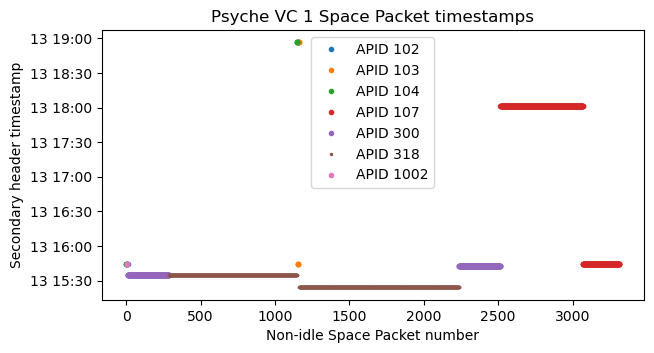

In [126]:
for apid in sorted(apids_vc1):
    if apid == 2047:
        continue
    sel = np.array([h.APID == apid for h in headers_vc1 if h.APID != 2047])
    extra = {'markersize': 3} if apid == 318 else {}
    plt.plot(np.arange(packet_timestamps_vc1.size)[sel], packet_timestamps_vc1[sel], '.',
             label=f'APID {apid}', **extra)
plt.legend()
plt.title('Psyche VC 1 Space Packet timestamps')
plt.xlabel('Non-idle Space Packet number')
plt.ylabel('Secondary header timestamp');

In [127]:
headers_noidle_vc1 = [h for h in headers_vc1 if h.APID != 2047]
packets_noidle_vc1 = [p for h, p in zip(headers_vc1, packets_vc1) if h.APID != 2047]

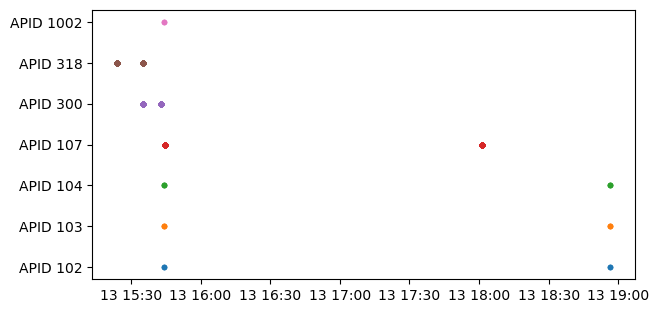

In [128]:
for j, apid in enumerate(sorted([a for a in apids_vc1 if a != 2047])):
    tstamps = np.array([t for t, h in zip(packet_timestamps_vc1, headers_noidle_vc1) if h.APID == apid])
    plt.plot(tstamps, [j] * tstamps.size, '.')
yticks = [f'APID {a}' for a in sorted(apids_vc1) if a != 2047]
plt.yticks(np.arange(len(yticks)), yticks);

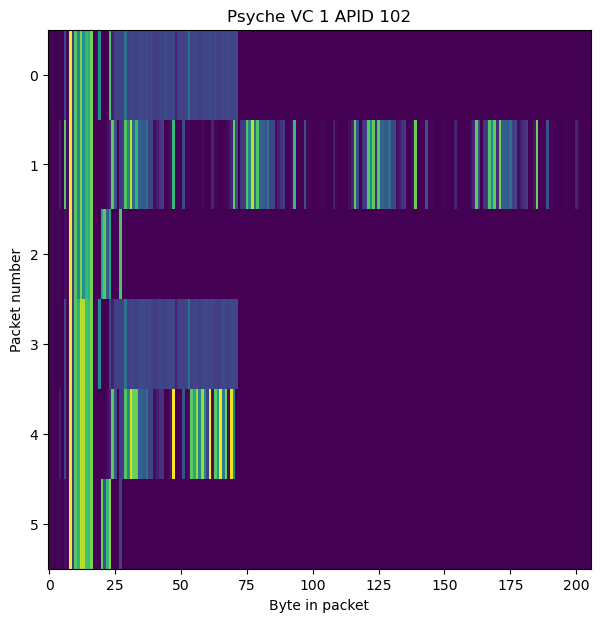

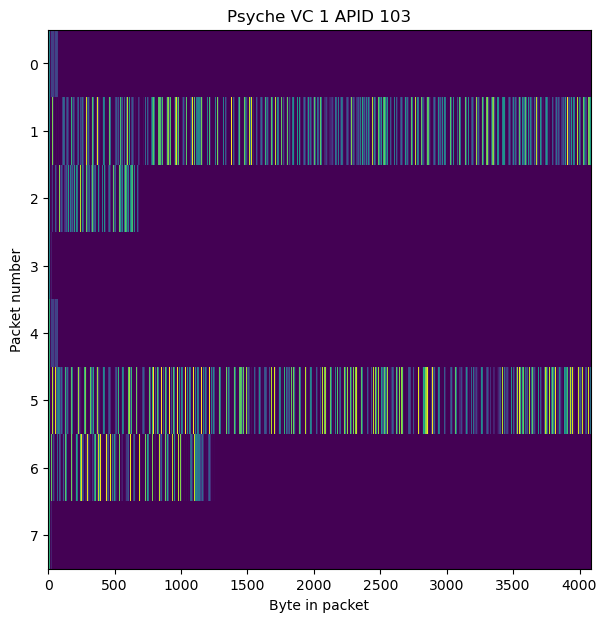

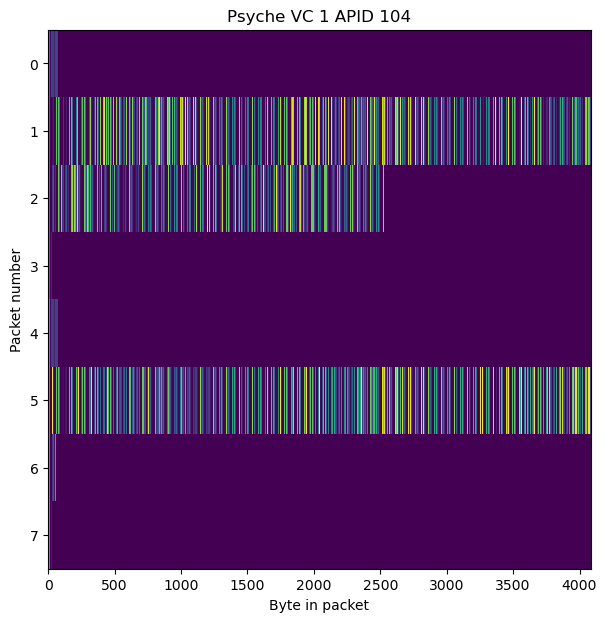

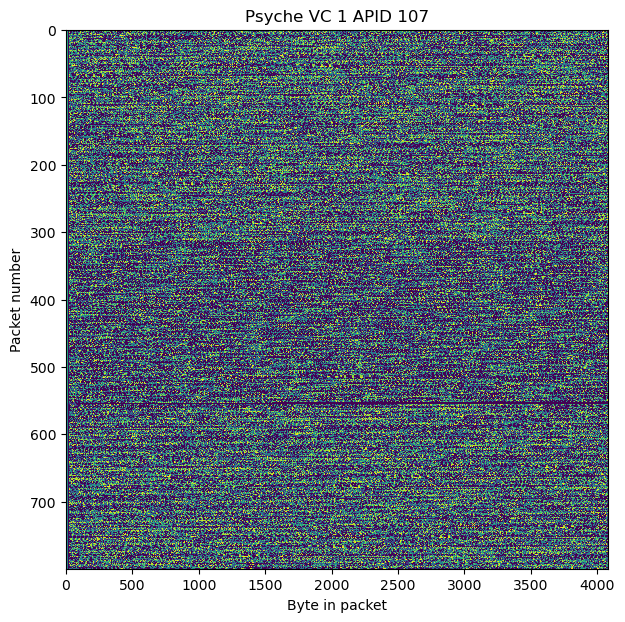

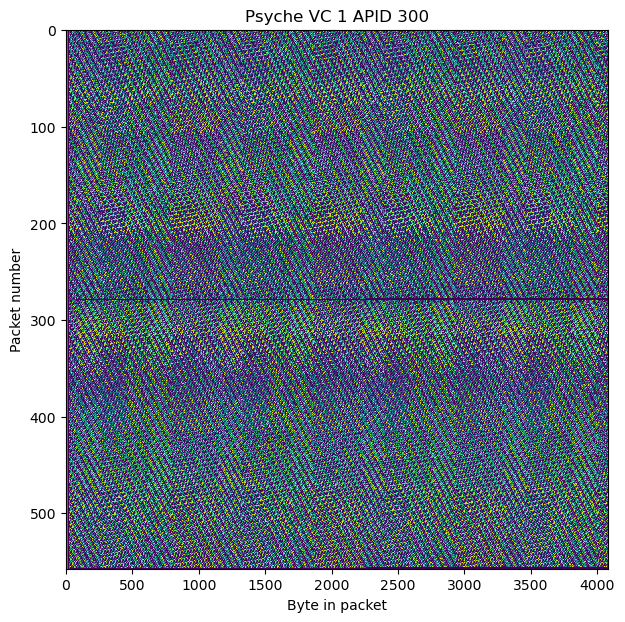

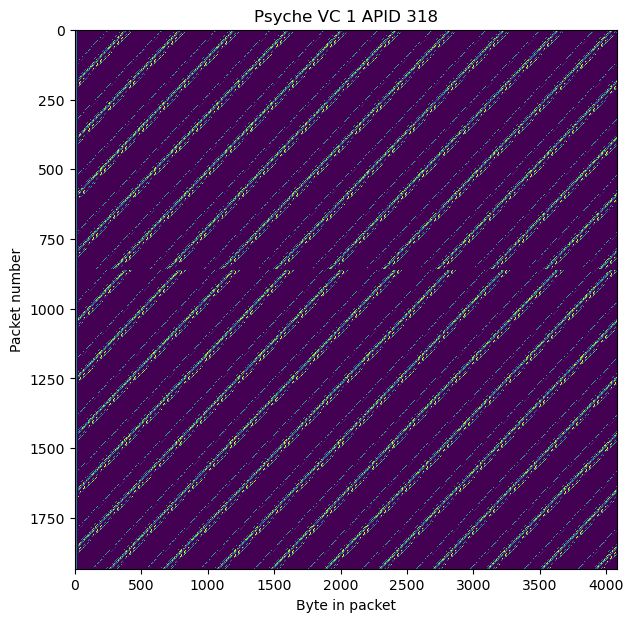

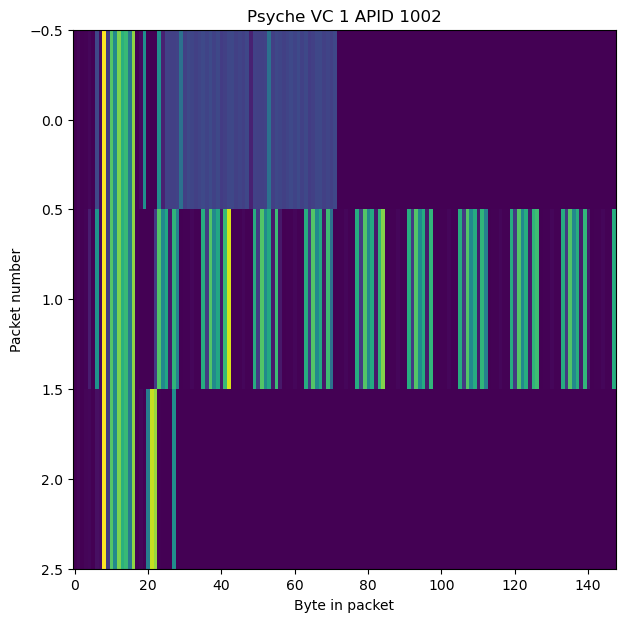

In [129]:
apid_array_vc1 = {}
for apid in sorted(apids_vc1):
    if apid == 2047:
        continue
    ps = [np.frombuffer(p[6+6:], 'uint8') for p in by_apid_vc1[apid]]
    ml = max([len(p) for p in ps])
    plt.figure(figsize=(7, 7))
    apid_array_vc1[apid] = np.array([np.concatenate((p, np.zeros(ml - len(p), 'uint8'))) for p in ps])
    plt.imshow(apid_array_vc1[apid], aspect='auto', interpolation='none')
    plt.title(f'Psyche VC 1 APID {apid}')
    plt.xlabel('Byte in packet')
    plt.ylabel('Packet number')

In [130]:
for apid in sorted(apids_vc1):
    if apid == 2047:
        continue
    print('APID', apid)
    print([p[6+6:][:4].hex() for p in by_apid_vc1[apid]])

APID 102
['00030001', '00030002', '00030003', '00030001', '00030002', '00030003']
APID 103
['00040001', '00040002', '00040003', '00040004', '00040001', '00040002', '00040003', '00040004']
APID 104
['00040001', '00040002', '00040003', '00040004', '00040001', '00040002', '00040003', '00040004']
APID 107
['022a0001', '022a0002', '022a0003', '022a0004', '022a0005', '022a0006', '022a0007', '022a0008', '022a0009', '022a000a', '022a000b', '022a000c', '022a000d', '022a000e', '022a000f', '022a0010', '022a0011', '022a0012', '022a0013', '022a0014', '022a0015', '022a0016', '022a0017', '022a0018', '022a0019', '022a001a', '022a001b', '022a001c', '022a001d', '022a001e', '022a001f', '022a0020', '022a0021', '022a0022', '022a0023', '022a0024', '022a0025', '022a0026', '022a0027', '022a0028', '022a0029', '022a002a', '022a002b', '022a002c', '022a002d', '022a002e', '022a002f', '022a0030', '022a0031', '022a0032', '022a0033', '022a0034', '022a0035', '022a0036', '022a0037', '022a0038', '022a0039', '022a003a', 

In [131]:
CFDP_PDU_Fixed_Header = BitStruct(
    'version' / Const(0, BitsInteger(3)),
    'pdu_type' / BitsInteger(1),
    'direction' / BitsInteger(1),
    'transmission_mode' / BitsInteger(1),
    'crc_flag' / Flag,
    'reserved' / BitsInteger(1),
    'pdu_data_field_length' / BitsInteger(16),
    'reserved2' / BitsInteger(1),
    'length_of_entity_ids' / BitsInteger(3),
    'reserved3' / BitsInteger(1),
    'length_of_transaction_sequence_number' / BitsInteger(3),
    'source_entity_id' / BitsInteger(8 * (this.length_of_entity_ids + 1)),
    'transaction_sequence_number' / BitsInteger(8 * (this.length_of_transaction_sequence_number + 1)),
    'destination_entity_id' / BitsInteger(8 * (this.length_of_entity_ids + 1)),
)

CFDP_LV = Struct(
    'length' / Int8ub,
    'value' / Bytes(this.length),
)

CFDP_TLV = Struct(
    'type' / Int8ub,
    'length' / Int8ub,
    'value' / Bytes(this.length),
)

CFDP_Condition_Code = Enum(
    BitsInteger(4), NoError=0, PositiveAckLimitReached=1,
    KeepAliveLimitReached=2, InvalidTransmissionMode=3,
    FilestoreRejection=4, FileChecksumFailure=5,
    FileSizeError=6, NakLimitReached=7, InactivityDetected=8,
    InvalidFileStructure=9, CheckLimitReached=10,
    SuspendRequestReceived=14, CancelRequestReceived=15)

CFDP_EOF_PDU = BitStruct(
    'condition_code' / CFDP_Condition_Code,
    'spare' / BitsInteger(4),
    'file_checksum' / BitsInteger(32),
    'file_size' / BitsInteger(32),
    'fault_location' / If(this.condition_code != CFDP_Condition_Code.NoError, CFDP_TLV),
)

CFDP_Metadata_PDU = BitStruct(
    'segmentation_control' / BitsInteger(1),
    'reserved' / BitsInteger(7),
    'length_of_file' / BitsInteger(32),
    'source_file_name' / Bytewise(CFDP_LV),
    'destination_file_name' / Bytewise(CFDP_LV),
    'options' / Bytewise(GreedyRange(CFDP_TLV)),
)

CFDP_File_Data = Struct(
    'offset' / Int32ub,
    'file_data' / GreedyBytes,
)

CFDP_PDU = Struct(
    'header' / CFDP_PDU_Fixed_Header,
    'file_directive_code' / If(this.header.pdu_type == 0, Int8ub),
    'eof_pdu' / If(this.file_directive_code == 0x04, CFDP_EOF_PDU),
    'metadata_pdu' / If(this.file_directive_code == 0x07, CFDP_Metadata_PDU),
    'file_data' / If(this.header.pdu_type == 1, CFDP_File_Data),
)

In [132]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid_vc1[1002]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1002, sequence_flags=3, packet_sequence_count_or_name=21, data_length=77),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1002, sequence_flags=3, packet_sequence_count_or_name=22, data_length=153),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1002, sequence_flags=3, packet_sequence_count_or_name=23, data_length=33)]

In [133]:
[p[6:6+6].hex() for p in by_apid_vc1[1002]]

['2cbb79cd000a', '2cbb79cd000a', '2cbb79cd000a']

In [134]:
[p[6+6:].hex() for p in by_apid_vc1[1002]]

['0003000104003607ff2cbb79cda3ac67d40107800000007e17313030325f303735303438333931372d3036373034303617313030325f303735303438333931372d30363730343036',
 '0003000214008207ff2cbb79cda3ac67d401000000002cbb799811a7700001010401019f2cbb799911adf00001010401019f2cbb799a11af100001010401019f2cbb799b11b0600001010401019f2cbb799c11a7d00001010401019f2cbb799d11a8000001010401019f2cbb799e11a8700001010401019f2cbb799f11a7b00001010401019f2cbb79a011a8100001010401019f',
 '0003000304000a07ff2cbb79cda3ac67d40104006ce9d8010000007e']

In [135]:
[CFDP_PDU.parse(p[6+6+4:]) for p in by_apid_vc1[1002]]

[Container(header=Container(version=0, pdu_type=0, direction=0, transmission_mode=1, crc_flag=False, reserved=0, pdu_data_field_length=54, reserved2=0, length_of_entity_ids=0, reserved3=0, length_of_transaction_sequence_number=7, source_entity_id=255, transaction_sequence_number=3223303882434963412, destination_entity_id=1), file_directive_code=7, eof_pdu=None, metadata_pdu=Container(segmentation_control=1, reserved=0, length_of_file=126, source_file_name=Container(length=23, value=b'1002_0750483917-0670406'), destination_file_name=Container(length=23, value=b'1002_0750483917-0670406'), options=ListContainer([])), file_data=None),
 Container(header=Container(version=0, pdu_type=1, direction=0, transmission_mode=1, crc_flag=False, reserved=0, pdu_data_field_length=130, reserved2=0, length_of_entity_ids=0, reserved3=0, length_of_transaction_sequence_number=7, source_entity_id=255, transaction_sequence_number=3223303882434963412, destination_entity_id=1), file_directive_code=None, eof_pdu

In [136]:
hex(3223303882434963412)

'0x2cbb79cda3ac67d4'

In [137]:
cfdp_files = {}
for apid in apids_vc1:
    if apid == 2047:
        continue
    for p in by_apid_vc1[apid]:
        pdu = CFDP_PDU.parse(p[6+6+4:])
        txid = pdu.header.transaction_sequence_number
        if pdu.metadata_pdu is not None:
            length = pdu.metadata_pdu.length_of_file    
            if txid in cfdp_files:
                raise ValueError('received twice a metadata PDU for the same transaction')
            cfdp_files[txid] = {'data': np.zeros(length, 'uint8'), 'valid': np.zeros(length, 'bool'),
                                'filename': pdu.metadata_pdu.destination_file_name.value, 'apid': apid}
        if pdu.eof_pdu is not None:
            cfdp_files[txid]['checksum'] = pdu.eof_pdu.file_checksum
            cfdp_files[txid]['condition_code'] = pdu.eof_pdu.condition_code
        elif pdu.header.pdu_type == 1:
            offset = pdu.file_data.offset
            length = len(pdu.file_data.file_data)
            cfdp_files[txid]['data'][offset:][:length] = np.frombuffer(pdu.file_data.file_data, 'uint8')
            cfdp_files[txid]['valid'][offset:][:length] = True

for file in cfdp_files.values():
    file['complete'] = np.all(file['valid'])

In [138]:
for file in cfdp_files.values():
    if file['complete']:
        file['data'].tofile(file['filename'])

In [139]:
cfdp_files

{3223303881898852560: {'data': array([  8,  26, 195, ..., 214, 144,   0], dtype=uint8),
  'valid': array([ True,  True,  True, ...,  True,  True,  True]),
  'filename': b'0104_0750483917-0539520',
  'apid': 104,
  'checksum': 474684782,
  'condition_code': EnumIntegerString.new(0, 'NoError'),
  'complete': True},
 3223353460317405392: {'data': array([  8,  26, 196, ..., 218, 144,   0], dtype=uint8),
  'valid': array([ True,  True,  True, ...,  True,  True,  True]),
  'filename': b'0104_0750495460-0932844',
  'apid': 104,
  'checksum': 4026716860,
  'condition_code': EnumIntegerString.new(0, 'NoError'),
  'complete': True},
 3223303882434963412: {'data': array([ 44, 187, 121, 152,  17, 167, 112,   0,   1,   1,   4,   1,   1,
         159,  44, 187, 121, 153,  17, 173, 240,   0,   1,   1,   4,   1,
           1, 159,  44, 187, 121, 154,  17, 175,  16,   0,   1,   1,   4,
           1,   1, 159,  44, 187, 121, 155,  17, 176,  96,   0,   1,   1,
           4,   1,   1, 159,  44, 187, 121, 

In [140]:
[hex(k) for k in cfdp_files.keys()]

['0x2cbb79cd83b800d0',
 '0x2cbba6e4e3bec0d0',
 '0x2cbb79cda3ac67d4',
 '0x2cbb79cd83aca0cc',
 '0x2cbba6e4e3b3b0cc',
 '0x2cbb77b063973258',
 '0x2cbb7983439c0258',
 '0x2cbb77b1d39aa27c',
 '0x2cbb7513839a327c',
 '0x2cbb79cd83b630ce',
 '0x2cbba6e4e3bd00ce',
 '0x2cbb99f0939e70d6',
 '0x2cbb79f0c39cc0d6']

In [141]:
[k >> 32 for k in cfdp_files.keys()]

[750483917,
 750495460,
 750483917,
 750483917,
 750495460,
 750483376,
 750483843,
 750483377,
 750482707,
 750483917,
 750495460,
 750492144,
 750483952]

In [142]:
[timestamp_to_utc(k >> 32) for k in cfdp_files.keys()]

[numpy.datetime64('2023-10-13T15:44:07.816000000'),
 numpy.datetime64('2023-10-13T18:56:30.816000000'),
 numpy.datetime64('2023-10-13T15:44:07.816000000'),
 numpy.datetime64('2023-10-13T15:44:07.816000000'),
 numpy.datetime64('2023-10-13T18:56:30.816000000'),
 numpy.datetime64('2023-10-13T15:35:06.816000000'),
 numpy.datetime64('2023-10-13T15:42:53.816000000'),
 numpy.datetime64('2023-10-13T15:35:07.816000000'),
 numpy.datetime64('2023-10-13T15:23:57.816000000'),
 numpy.datetime64('2023-10-13T15:44:07.816000000'),
 numpy.datetime64('2023-10-13T18:56:30.816000000'),
 numpy.datetime64('2023-10-13T18:01:14.816000000'),
 numpy.datetime64('2023-10-13T15:44:42.816000000')]

In [143]:
def extract_space_packets_from_file(file_data):
    packets = []
    while len(file_data) >= ccsds.SpacePacketPrimaryHeader.sizeof():
        header = ccsds.SpacePacketPrimaryHeader.parse(file_data)
        if header.ccsds_version != 0:
            print(len(packets), len(file_data))
            raise ValueError('invalid CCSDS version')
        packet_len = header.data_length + ccsds.SpacePacketPrimaryHeader.sizeof() + 1
        if len(file_data) < packet_len:
            return packets
        packets.append(bytes(file_data[:packet_len]))
        file_data = file_data[packet_len:]
    return packets

In [144]:
for file in cfdp_files.values():
    if file['apid'] in [102, 103, 104, 107]:
        file_stop = file['data'].size if file['complete'] else np.min(np.where(~file['valid'])[0])
        file['packets'] = extract_space_packets_from_file(file['data'][:file_stop])
        file['packet_headers'] = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in file['packets']]
        file['timestamps'] = timestamp_to_utc(np.array([np.frombuffer(p[6:10], 'uint8')
                                                        for p in file['packets']]).view('uint32').byteswap().ravel()
                                              + np.array([np.frombuffer(p[10:12], 'uint8')
                                                          for p in file['packets']]).view('uint16').byteswap().ravel() / 2**16)
    elif file['apid'] == 300:
        file['measurements'] = file['data'].reshape(-1, 39)
    elif file['apid'] == 318:
        file['measurements'] = file['data'].reshape(-1, 406)
    elif file['apid'] == 1002:
        file['measurements'] = file['data'].reshape(-1, 14)
    if file['apid'] in [300, 318, 1002]:
        file['timestamps'] = timestamp_to_utc(file['measurements'][:, :4].view('uint32').byteswap()
                                              + file['measurements'][:, 4:5].astype('float') / 256)

In [145]:
{file['filename']: file['packet_headers'] for file in cfdp_files.values() if file['apid'] == 102}

{b'0102_0750483917-0539338': [Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=24, sequence_flags=3, packet_sequence_count_or_name=59, data_length=39),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=24, sequence_flags=3, packet_sequence_count_or_name=60, data_length=39),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=24, sequence_flags=3, packet_sequence_count_or_name=61, data_length=39),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=24, sequence_flags=3, packet_sequence_count_or_name=62, data_length=39)],
 b'0102_0750495460-0932667': [Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=24, sequence_flags=3, packet_sequence_count_or_name=63, data_length=42)]}

In [146]:
{file['filename']: file['packet_headers'][:10] for file in cfdp_files.values() if file['apid'] == 103}

{b'0103_0750483917-0539491': [Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=25, sequence_flags=3, packet_sequence_count_or_name=55, data_length=74),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=25, sequence_flags=3, packet_sequence_count_or_name=56, data_length=24),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=25, sequence_flags=3, packet_sequence_count_or_name=57, data_length=38),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=25, sequence_flags=3, packet_sequence_count_or_name=58, data_length=29),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=25, sequence_flags=3, packet_sequence_count_or_name=59, data_length=24),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=25, sequence_flags=3, packet_sequence_count_or_name=60, data_length=38),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, 

In [147]:
{file['filename']: file['packet_headers'][:10] for file in cfdp_files.values() if file['apid'] == 104}

{b'0104_0750483917-0539520': [Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=26, sequence_flags=3, packet_sequence_count_or_name=972, data_length=42),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=26, sequence_flags=3, packet_sequence_count_or_name=973, data_length=42),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=26, sequence_flags=3, packet_sequence_count_or_name=974, data_length=42),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=26, sequence_flags=3, packet_sequence_count_or_name=975, data_length=42),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=26, sequence_flags=3, packet_sequence_count_or_name=976, data_length=42),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=26, sequence_flags=3, packet_sequence_count_or_name=977, data_length=42),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=

In [148]:
{file['filename']: file['packet_headers'][:10] for file in cfdp_files.values() if file['apid'] == 107}

{b'0107_0750492144-0604647': [Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=30, sequence_flags=3, packet_sequence_count_or_name=12479, data_length=3652),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=30, sequence_flags=3, packet_sequence_count_or_name=12480, data_length=3596),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=30, sequence_flags=3, packet_sequence_count_or_name=12481, data_length=3510),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=30, sequence_flags=3, packet_sequence_count_or_name=12482, data_length=3413),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=30, sequence_flags=3, packet_sequence_count_or_name=12483, data_length=3575),
  Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=30, sequence_flags=3, packet_sequence_count_or_name=12484, data_length=3569),
  Container(ccsds_version=0, packet_type=0

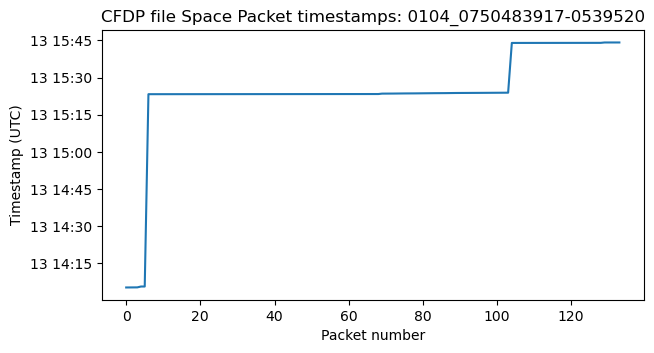

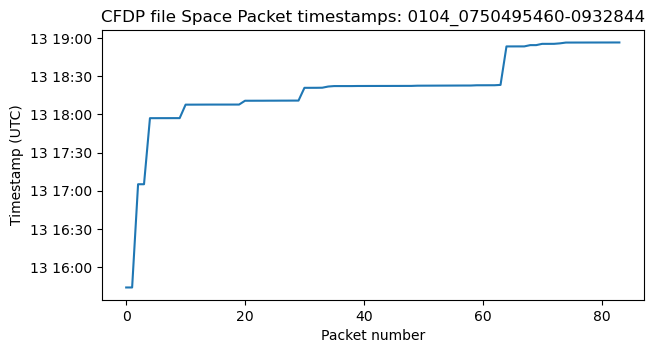

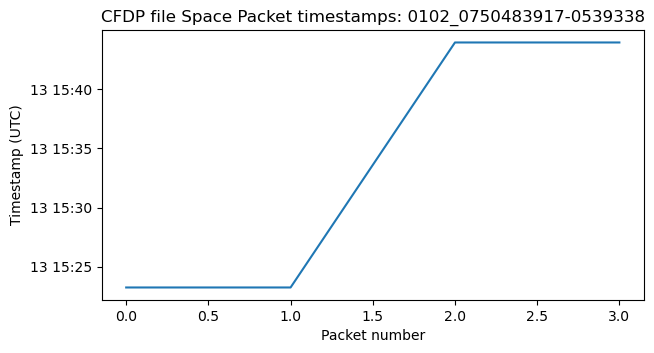

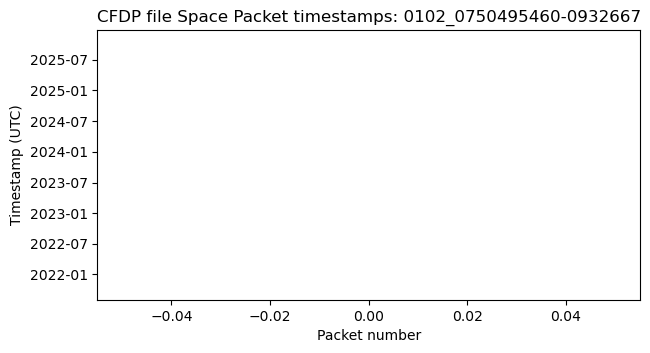

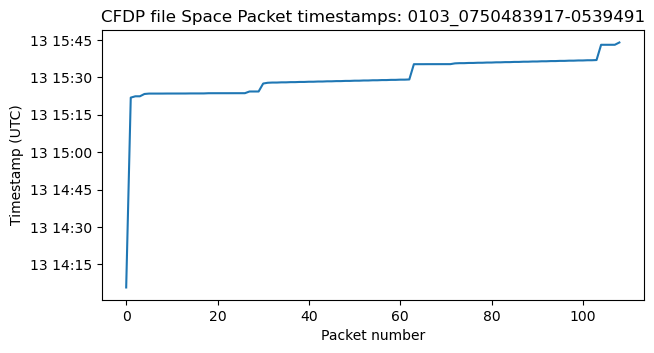

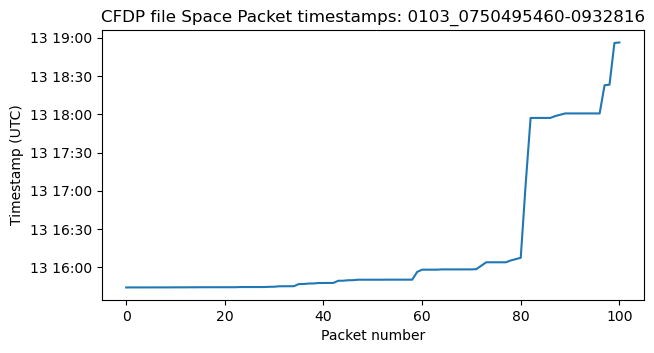

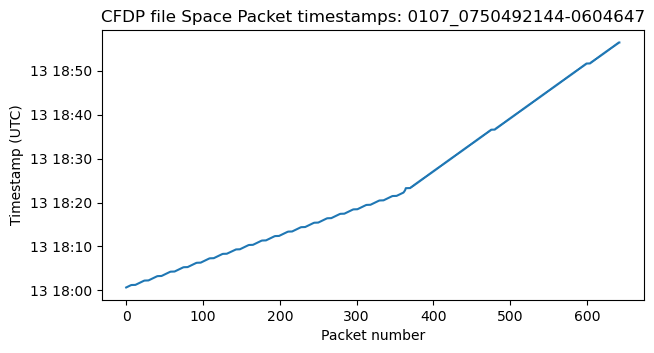

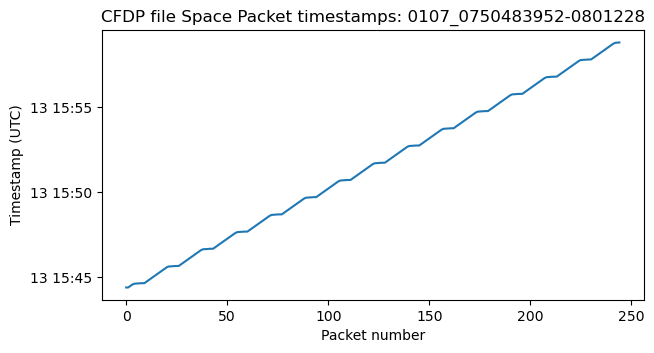

In [149]:
for file in cfdp_files.values():
    if file['apid'] not in [102, 103, 104, 107]:
        continue
    plt.figure()
    plt.plot(file['timestamps'])
    plt.title(f"CFDP file Space Packet timestamps: {str(file['filename'], encoding='ascii')}")
    plt.ylabel('Timestamp (UTC)')
    plt.xlabel('Packet number')

In [150]:
def extract_values_files(filekeys):
    data = {}
    timestamps = {}
    for k in filekeys:
        for j, packet in enumerate(cfdp_files[k]['packets']):
            sec_header = np.frombuffer(packet[6:6+6], 'uint8')
            timestamp = (sec_header[:4].view('uint32').byteswap().ravel()
                         + sec_header[-2:].view('uint16').byteswap().ravel() / 2**16)
            timestamp = np.datetime64('2017-01-01T00:00:00.816') + np.timedelta64(1, 'ns') * (1e9 * (timestamp - 536500870))
            buff = np.frombuffer(packet[6+6:], 'uint8')
            while buff.size:
                key = buff[:2].view('uint16').byteswap()[0]
                len = keys[key]
                data.setdefault(key, []).append(buff[2:][:len])
                timestamps.setdefault(key, []).append(timestamp)
                buff = buff[2+len:]
    for k, v in data.items():
        data[k] = np.array(v)
    for k, v in timestamps.items():
        timestamps[k] = np.array(v)
    return data, timestamps

values_apid30, timestamps_apid30 = extract_values_files([3223304033294663894, 3223339216861556950])

In [151]:
# APID 102
[p[6+6:] for p in cfdp_files[3223303881898107084]['packets']]

[b'PLD_16\x08\x14",\x00\x00\n\xab\x00\x00\x00;\x03\x04\x00\x00\x00\x00\x04\x00\x00\x00\x18\x04\x00\x00\x00\x00',
 b'PLD_16\x08\x14",\x00\x00\n\xac\x00\x00\x00<\x03\x04\x00\x00\x00\x01\x04\x00\x00\x00\x18\x04\x00\x00\x00\x00',
 b'PLD_16\x08\x14",\x00\x00\r\xc6\x00\x00\x00=\x03\x04\x00\x00\x00\x00\x04\x00\x00\x00\x18\x04\x00\x00\x00\x00',
 b'PLD_16\x08\x14",\x00\x00\r\xc7\x00\x00\x00>\x03\x04\x00\x00\x00\x01\x04\x00\x00\x00\x18\x04\x00\x00\x00\x00']

In [152]:
[p[6+6:] for p in cfdp_files[3223353460316680396]['packets']]

[b'GNC_16\t\x15$%\x00\x00\x0e\xff\x00\x00\x00?\x02\x08\xbf\x9a\xdav\xd9{0\xfc\x08\xbf\x8e\xfbm\xca\x07\xf6o']

In [153]:
# APID 103
[p[6+6:] for p in cfdp_files[3223303881898733774]['packets']]

[b'DWN_16\x04\x13 \x05\x00\x00\n#\x00\x00\x002\n\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01\x04\x00\x00\x00\x00\x04\x00\x00\x00\x01\x04\x00\x00\x07\xd0\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01\x04\x00\x00\x00\x06\x04\x00\x00\x00\x00',
 b'EXE_16\x07\x13 G\x00\x00\nU\x00\x00\x003\x00',
 b'EXE_16\x07\x13 \x1d\x00\x00\nZ\x00\x00\x004\x02\x04\x00\x00\x00\x01\x08@\xe2\xe4o\xa5\xa6\x10\xd5',
 b'EXE_16\x07\x13 \x16\x00\x00\n[\x00\x00\x005\x01\x04\x00\x00\x00\x03',
 b'NVM_16\x06\x14 \x01\x00\x00\x0bD\x00\x00\x006\x00',
 b'EXE_16\x07\x13 \x1d\x00\x00\x0b\x84\x00\x00\x007\x02\x04\x00\x00\x00\x00\x08@\xe2\xec\x9b\xa3"\xf0k',
 b'EXE_16\x07\x13 \x14\x00\x00\x0b\x85\x00\x00\x008\x01\x04\x00\x00\x00\x02',
 b'EXE_16\x07\x13 \x14\x00\x00\x0b\x86\x00\x00\x009\x01\x04\x00\x00\x00\t',
 b'GNC_16\t\x15 \x01\x00\x00\x0b\x87\x00\x00\x00:\x03\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01',
 b'GNC_16\t\x15 \x01\x00\x00\x0b\x8d\x00\x00\x00;\x03\x04\x00\x00\x00\x02\x04\x00\x00\x00\x01

In [154]:
[p[6+6:] for p in cfdp_files[3223353460317290702]['packets']]

[b'DWN_16\x04\x14 \x11\x00\x00\x0e\x7f\x00\x00\x00\x9f\x02\x04\x00\x01\xf4\xe8\x1d/eng/eha_selcrit_sys_safe_cgs',
 b'EXE_16\x07\x13 \x1d\x00\x00\x0e\x8f\x00\x00\x00\xa0\x02\x04\x00\x00\x00\x00\x08@\xe3\x88\xfbGP\xa9S',
 b'EXE_16\x07\x13 \x14\x00\x00\x0e\x90\x00\x00\x00\xa1\x01\x04\x00\x00\x00\x06',
 b'GNC_16\t\x15 \x0f\x00\x00\x0e\x91\x00\x00\x00\xa2\x04\x04\x00\x00\x00\x00\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01',
 b'GNC_16\t\x15 \x0f\x00\x00\x0e\x92\x00\x00\x00\xa3\x04\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01\x04\x00\x00\x00\x01',
 b'GNC_16\t\x15 \x01\x00\x00\x0e\x93\x00\x00\x00\xa4\x03\x04\x00\x00\x00\x01\x04\x00\x00\x00\x03\x04\x00\x00\x00\x01',
 b'GNC_16\t\x15 \x01\x00\x00\x0e\x99\x00\x00\x00\xa5\x03\x04\x00\x00\x00\x02\x04\x00\x00\x00\x01\x04\x00\x00\x00\x02',
 b'GNC_16\t\x15 \x01\x00\x00\x0e\x9a\x00\x00\x00\xa6\x03\x04\x00\x00\x00\x1c\x04\x00\x00\x00\x02\x04\x00\x00\x00\x03',
 b'GNC_16\t\x15(\x01\x00\x00\x0e\x9c\x00\x00\x00\xa7\x02\x04\x00\

In [155]:
# APID 104
[p[6+6:] for p in cfdp_files[3223303881898852560]['packets']]

[b'UPL_16\x03\x12 \x08\x00\x00\n\x19\x00\x00\x03\xcc\x04\x02\xfcF\x04\x00\x00\x00\x00\x04,\xbbb\xa4\x04\x19\xdd\xb0\x00',
 b'UPL_16\x03\x12 \n\x00\x00\n\x1b\x00\x00\x03\xcd\x04\x02\xfcF\x04\x00\x00\x00\x00\x04,\xbbb\xa4\x04)\xd6\xb0\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\n\x1c\x00\x00\x03\xce\x04\x02\xfcF\x04\x00\x00\x00\x00\x04,\xbbb\xa6\x04i\xdc\xd0\x00',
 b'UPL_16\x03\x12 \n\x00\x00\n\x1e\x00\x00\x03\xcf\x04\x02\xfcF\x04\x00\x00\x00\x00\x04,\xbbb\xa6\x04y\xd6\xd0\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\n \x00\x00\x03\xd0\x04\x02\xfcJ\x04\x00\x00\x00\x00\x04,\xbbb\xbb\x049\xdd \x00',
 b'UPL_16\x03\x12 \n\x00\x00\n"\x00\x00\x03\xd1\x04\x02\xfcJ\x04\x00\x00\x00\x00\x04,\xbbb\xbb\x04I\xd6\x90\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\n\xc3\x00\x00\x03\xd2\x04\x02\xfc,\x04\x00\x00\x00\x04\x04,\xbbt\xe9\x04\xd9\xd6`\x00',
 b'UPL_16\x03\x12 \n\x00\x00\n\xc4\x00\x00\x03\xd3\x04\x02\xfc,\x04\x00\x00\x00\x04\x04,\xbbt\xe9\x04\xe9\xd5\xd0\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\n\xc6\x00\x00\x03\xd4\x04\x0

In [156]:
[p[6+6:] for p in cfdp_files[3223353460317405392]['packets']]

[b'UPL_16\x03\x12 \x08\x00\x00\x0ea\x00\x00\x04R\x04\x02\xb7R\x04\x00\x00\x00\x04\x04,\xbby\xcd\x04\xf9\xd8@\x00',
 b'UPL_16\x03\x12 \n\x00\x00\x0ec\x00\x00\x04S\x04\x02\xb7R\x04\x00\x00\x00\x04\x04,\xbby\xce\x04\t\xd6\xe0\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\x0f\x14\x00\x00\x04T\x04\x02\xfb\xc8\x04\x00\x00\x00\x00\x04,\xbb\x8c\xcd\x04\xa9\xdf\xc0\x00',
 b'UPL_16\x03\x12 \n\x00\x00\x0f\x15\x00\x00\x04U\x04\x02\xfb\xc8\x04\x00\x00\x00\x00\x04,\xbb\x8c\xcd\x04\xb9\xd8\xf0\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\x0f!\x00\x00\x04V\x04\x02\xb1C\x04\x00\x00\x00\x04\x04,\xbb\x98\xf6\x04Y\xd6\x00\x00',
 b'UPL_16\x03\x12 \n\x00\x00\x0f#\x00\x00\x04W\x04\x02\xb1C\x04\x00\x00\x00\x04\x04,\xbb\x98\xf6\x04y\xd80\x00',
 b'UPL_16\x03\x12 \x08\x00\x00\x0f$\x00\x00\x04X\x04\x02\x006\x04\x00\x00\x00\x04\x04,\xbb\x98\xf7\x04Y\xd5\xd0\x00',
 b'UPL_16\x03\x12 \n\x00\x00\x0f&\x00\x00\x04Y\x04\x02\x006\x04\x00\x00\x00\x04\x04,\xbb\x98\xf7\x04y\xd9\x00\x00',
 b"UPL_16\x03\x12 \x08\x00\x00\x0f'\x00\x00\x04Z\x04\x

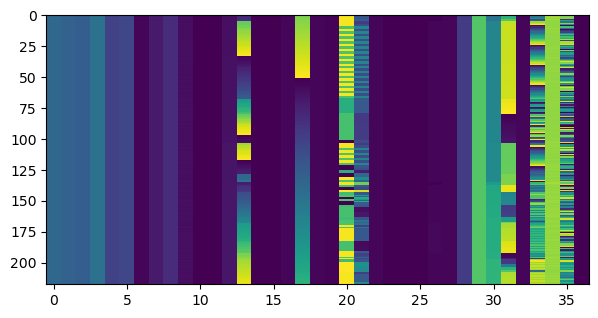

In [157]:
apid104 = np.array([np.frombuffer(p[6+6:], 'uint8')
                    for k in [3223303881898852560, 3223353460317405392]
                    for p in cfdp_files[k]['packets']])
t_apid104 = np.concatenate([cfdp_files[k]['timestamps']
                            for k in [3223303881898852560, 3223353460317405392]])
plt.imshow(apid104, interpolation='none', aspect='auto')

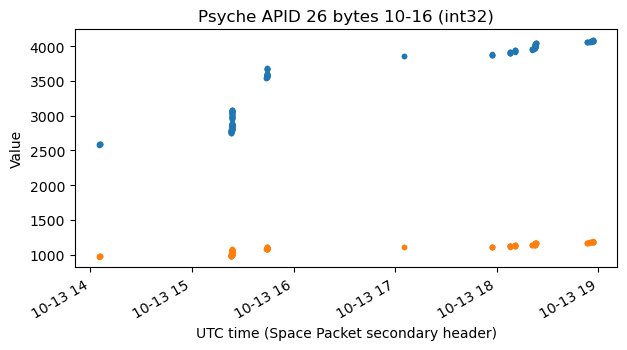

In [158]:
plt.plot(t_apid104, apid104[:, 10:][:, :2*4].view('int32').byteswap(), '.')
plt.gcf().autofmt_xdate()
plt.title('Psyche APID 26 bytes 10-16 (int32)')
plt.xlabel('UTC time (Space Packet secondary header)')
plt.ylabel('Value');

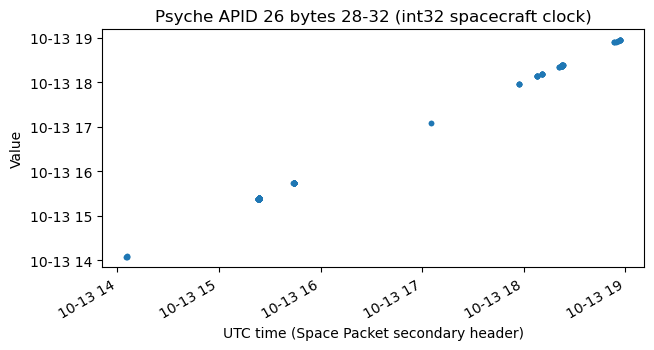

In [159]:
plt.plot(t_apid104, timestamp_to_utc(apid104[:, 28:][:, :4].view('int32').byteswap()), '.')
plt.gcf().autofmt_xdate()
plt.title('Psyche APID 26 bytes 28-32 (int32 spacecraft clock)')
plt.xlabel('UTC time (Space Packet secondary header)')
plt.ylabel('Value');

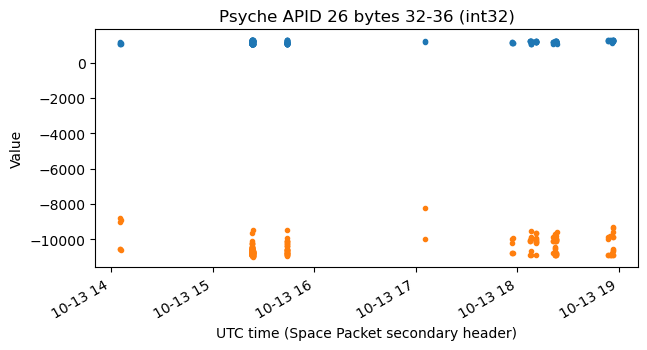

In [160]:
plt.plot(t_apid104, apid104[:, 32:][:, :4].view('int16').byteswap(), '.')
plt.gcf().autofmt_xdate()
plt.title('Psyche APID 26 bytes 32-36 (int32)')
plt.xlabel('UTC time (Space Packet secondary header)')
plt.ylabel('Value');

In [161]:
len(values_apid30.keys()), len(values_by_apid[10].keys())

(4748, 4748)

In [162]:
values_apid30.keys() == values_by_apid[10].keys()

True

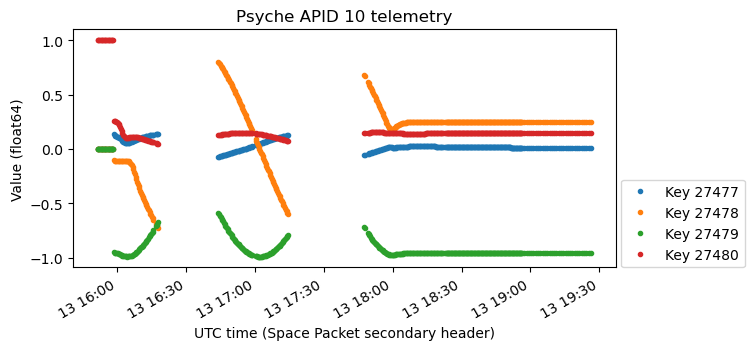

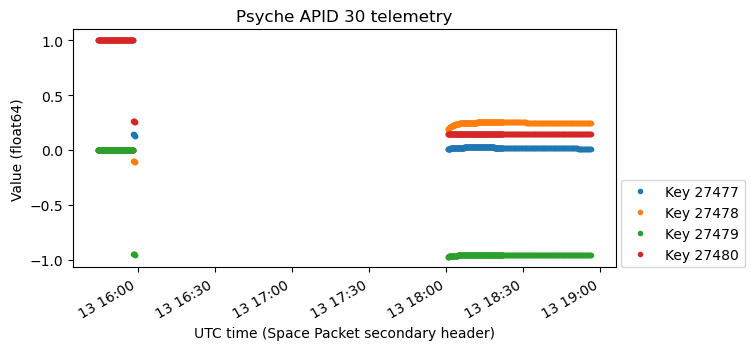

In [163]:
plot_keys(107*256+85+np.arange(4), 'float64')
plot_keys(107*256+85+np.arange(4), 'float64', apid=30)

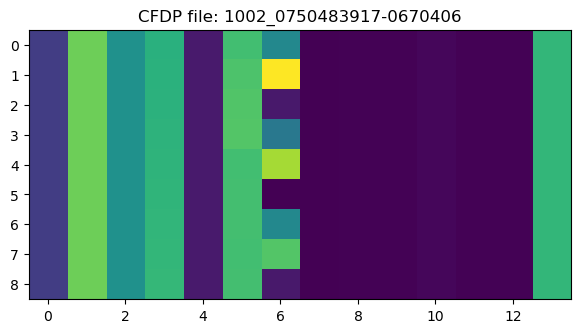

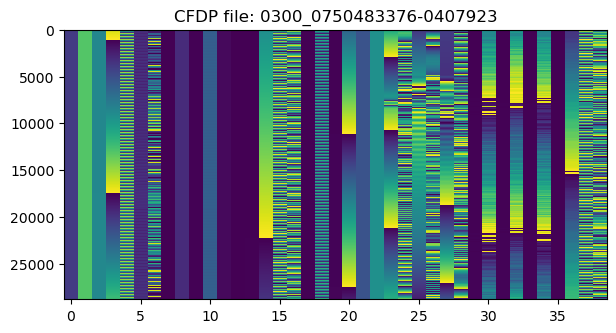

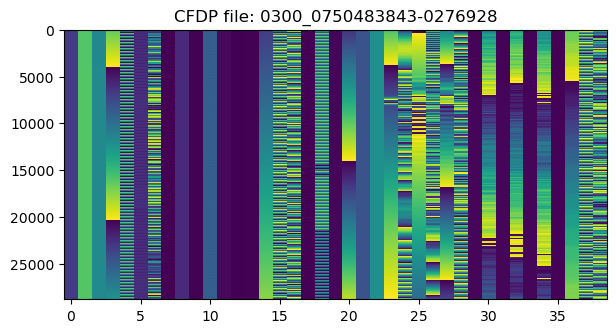

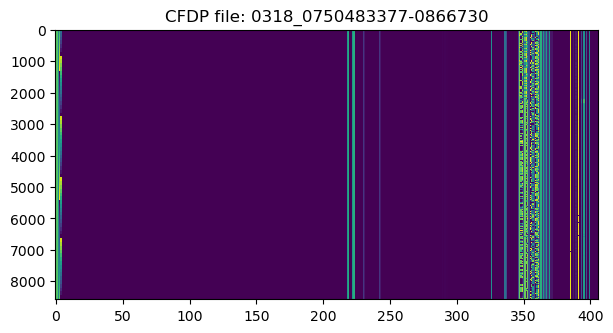

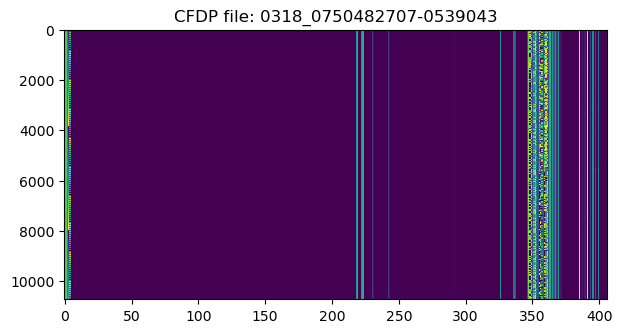

In [164]:
for file in cfdp_files.values():
    if file['apid'] not in [300, 318, 1002]:
        continue
    plt.figure()
    plt.imshow(file['measurements'], aspect='auto', interpolation='none')
    plt.title(f"CFDP file: {str(file['filename'], encoding='ascii')}")

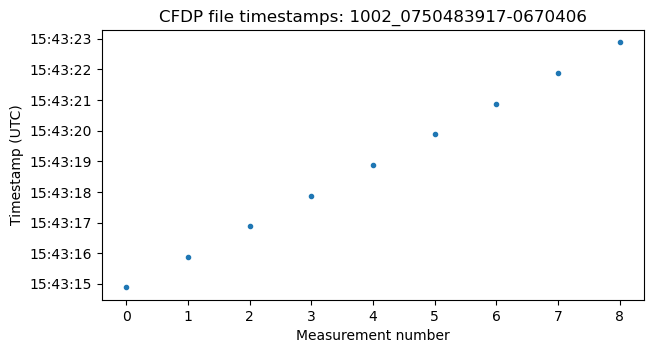

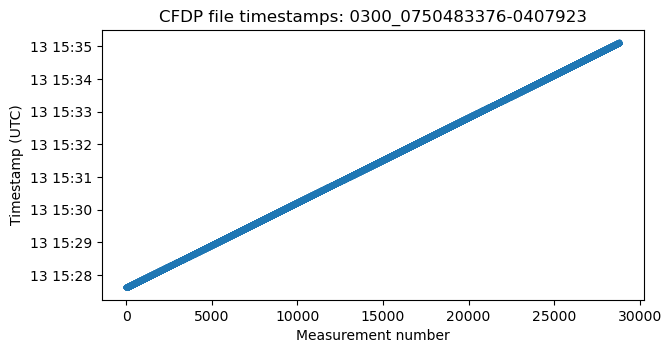

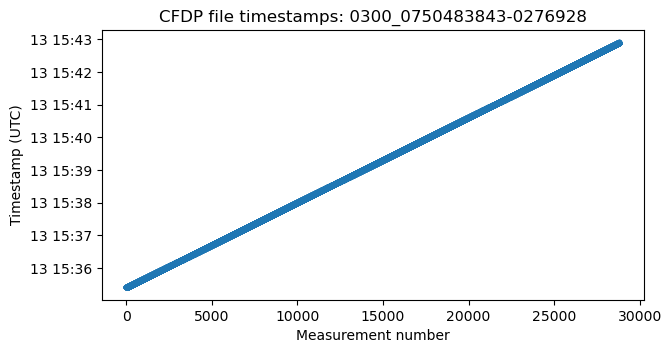

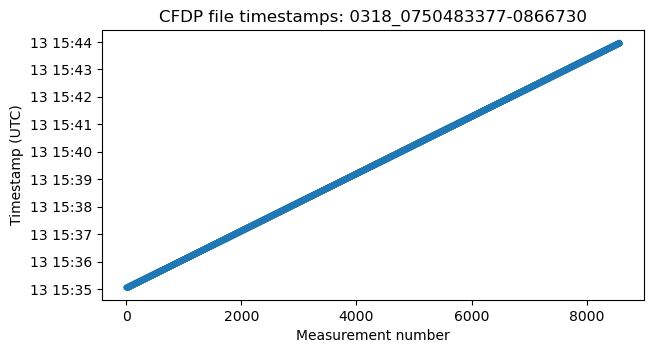

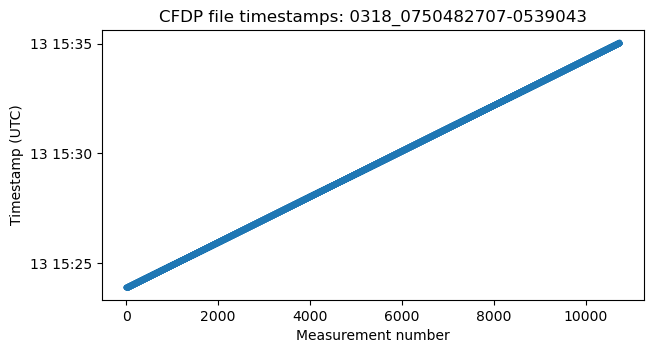

In [165]:
for file in cfdp_files.values():
    if file['apid'] not in [300, 318, 1002]:
        continue
    plt.figure()
    plt.plot(file['timestamps'], '.')
    plt.title(f"CFDP file timestamps: {str(file['filename'], encoding='ascii')}")
    plt.ylabel('Timestamp (UTC)')
    plt.xlabel('Measurement number')

In [166]:
measurements_300 = np.concatenate([cfdp_files[k]['measurements']
                                   for k in [3223301557782524504, 3223303562995696216]])
timestamps_300 = np.concatenate([cfdp_files[k]['timestamps']
                                 for k in [3223301557782524504, 3223303562995696216]])

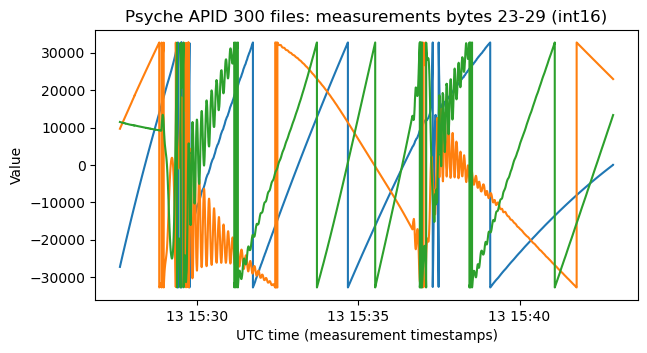

In [167]:
plt.plot(timestamps_300, measurements_300[:, 23:][:, :6].view('int16').byteswap())
plt.title('Psyche APID 300 files: measurements bytes 23-29 (int16)')
plt.xlabel('UTC time (measurement timestamps)')
plt.ylabel('Value');

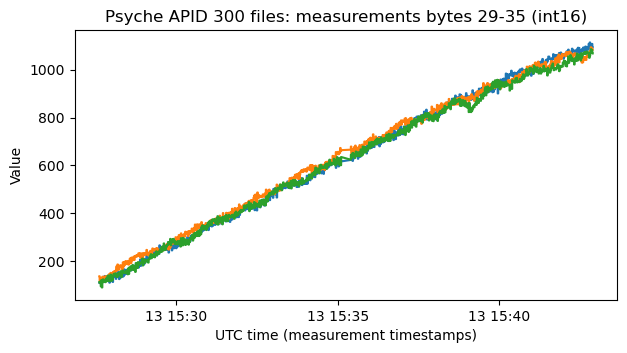

In [168]:
plt.plot(timestamps_300, measurements_300[:, 29:][:, :6].view('int16').byteswap());
plt.title('Psyche APID 300 files: measurements bytes 29-35 (int16)')
plt.xlabel('UTC time (measurement timestamps)')
plt.ylabel('Value');

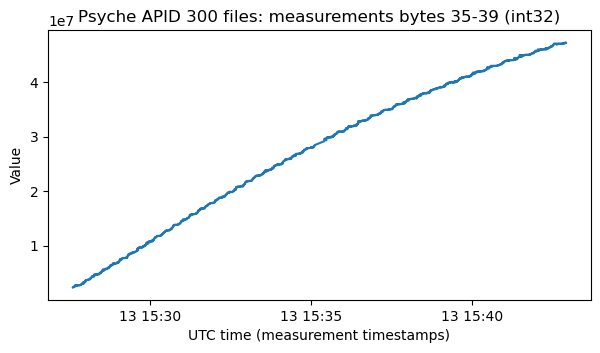

In [169]:
plt.plot(timestamps_300, measurements_300[:, 35:][:, :4].view('int32').byteswap())
plt.title('Psyche APID 300 files: measurements bytes 35-39 (int32)')
plt.xlabel('UTC time (measurement timestamps)')
plt.ylabel('Value');

In [170]:
measurements_318 = np.concatenate([cfdp_files[k]['measurements']
                                   for k in [3223298684986471036, 3223301563956765308]])
timestamps_318 = np.concatenate([cfdp_files[k]['timestamps']
                                 for k in [3223298684986471036, 3223301563956765308]])

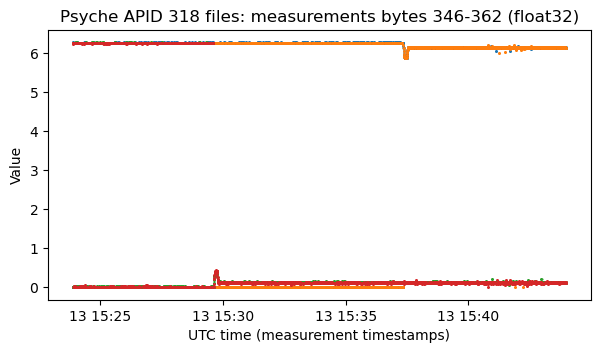

In [171]:
plt.plot(timestamps_318, measurements_318[:, 346:][:, :4*4].view('float32').byteswap(),
         '.', markersize=1)
plt.title('Psyche APID 318 files: measurements bytes 346-362 (float32)')
plt.xlabel('UTC time (measurement timestamps)')
plt.ylabel('Value');

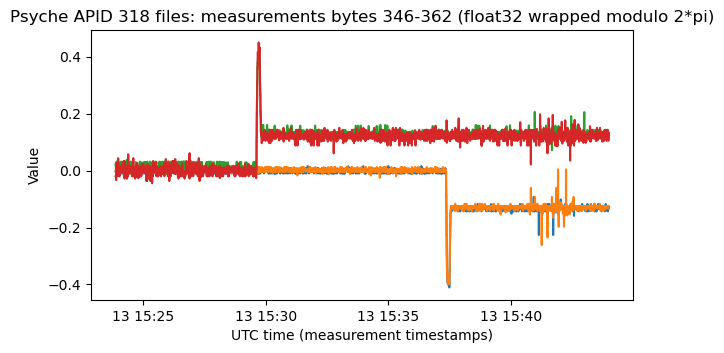

In [172]:
plt.plot(timestamps_318, (measurements_318[:, 346:][:, :4*4].view('float32').byteswap() + np.pi) % (2*np.pi) - np.pi)
plt.title('Psyche APID 318 files: measurements bytes 346-362 (float32 wrapped modulo 2*pi)')
plt.xlabel('UTC time (measurement timestamps)')
plt.ylabel('Value');

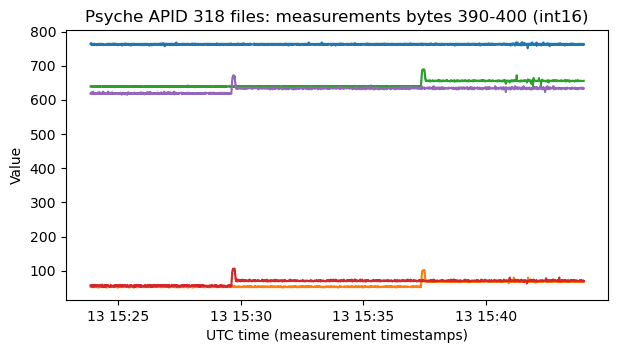

In [173]:
plt.plot(timestamps_318, measurements_318[:, 390:][:, :2*5].view('int16').byteswap())
plt.title('Psyche APID 318 files: measurements bytes 390-400 (int16)')
plt.xlabel('UTC time (measurement timestamps)')
plt.ylabel('Value');

# VC 63

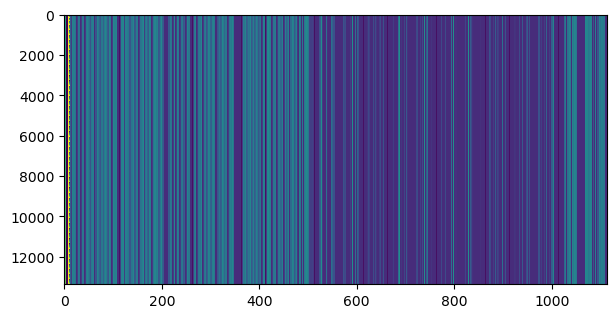

In [174]:
plt.imshow(frames[vcid == 63], aspect='auto', interpolation='none')

In [175]:
packets_vc63 = list(ccsds.extract_space_packets(tm, 255, 63))

/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 63] Broken stream. Last frame count 626978, current frame count 626982
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 63] Broken stream. Last frame count 626987, current frame count 627103
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/Psyche/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 255 VC 63] Broken stream. Last frame count 627171, current frame count 627175
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame cou

In [176]:
all([p[ccsds.SpacePacketPrimaryHeader.sizeof():] == packets_vc63[0][ccsds.SpacePacketPrimaryHeader.sizeof():] for p in packets_vc63])

True

In [177]:
len(packets_vc63[0])

1105

In [178]:
collections.Counter([(a.m_pdu_header.rsv_spare, a.m_pdu_header.first_header_pointer)
                     for a in tm if a.primary_header.virtual_channel_id == 63])

Counter({(0, 0): 13373})

In [179]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets_vc63[:5]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12812, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12813, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12815, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12817, data_length=1098),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=12818, data_length=1098)]

In [180]:
easter_egg = packets_vc63[0][ccsds.SpacePacketPrimaryHeader.sizeof():]
easter_egg

b"A.Arslanian D.Beach M.Belete A.Bhosle Y.Brenman  \nD.Byrne R.Cheng P.Cheung M.Cisler D.Cummings     \nA.Dobrev P.Doronila B.Duckett D.Gaines L.Galdamez\nL.Hall S.Harris H.Hartounian D.Hecox Q.Ho        \nJ.Hofman Z.Hua C.Jones W.Kaye D.Kou S.Kroese     \nD.Leang L.Manglapus J.Masci B.Morin R.Nemiroff   \nC.Oda J.Pavek V.Reddy J.Sawoniewicz              \nA.Shearer L.Stewart G.Sun J.Thoma D.Tran R.Tsao  \nM.Tuszynski I.Uchenik M.Wade V.Wong R.Woo M.Yang \nW.Yasin H.Yun ** Rohan the Destroyer b.12/9/21 **\n        @@&J!~...       ^$$~      ^JPG@@@        \n        @#7!: .       ..~$$~     ^Y ~PP@@        \n        &77:..      :$$J: '     .5:  !##@        \n        Y!~.:      !J^ ~P ''    J5    G#&        \n        77:    !. !Y:   ~7!!7JY^^!Y   $&#        \n        77:    !.:5!         :^. ~~   $##        \n        5!~    ~:!5J777$$!            G#&        \n        @$7^    .^!JJJ$:5P.       ^^ $##@        \n        @&J$^      :.   YG.     .:J7J##@@        \n        @@@5$!.    :..  P&.  

In [181]:
print(str(easter_egg, 'ascii'))

A.Arslanian D.Beach M.Belete A.Bhosle Y.Brenman  
D.Byrne R.Cheng P.Cheung M.Cisler D.Cummings     
A.Dobrev P.Doronila B.Duckett D.Gaines L.Galdamez
L.Hall S.Harris H.Hartounian D.Hecox Q.Ho        
J.Hofman Z.Hua C.Jones W.Kaye D.Kou S.Kroese     
D.Leang L.Manglapus J.Masci B.Morin R.Nemiroff   
C.Oda J.Pavek V.Reddy J.Sawoniewicz              
A.Shearer L.Stewart G.Sun J.Thoma D.Tran R.Tsao  
M.Tuszynski I.Uchenik M.Wade V.Wong R.Woo M.Yang 
W.Yasin H.Yun ** Rohan the Destroyer b.12/9/21 **
        @@&J!~...       ^$$~      ^JPG@@@        
        @#7!: .       ..~$$~     ^Y ~PP@@        
        &77:..      :$$J: '     .5:  !##@        
        Y!~.:      !J^ ~P ''    J5    G#&        
        77:    !. !Y:   ~7!!7JY^^!Y   $&#        
        77:    !.:5!         :^. ~~   $##        
        5!~    ~:!5J777$$!            G#&        
        @$7^    .^!JJJ$:5P.       ^^ $##@        
        @&J$^      :.   YG.     .:J7J##@@        
        @@@5$!.    :..  P&.   ^.!!!L.Park        
